Survey Response Analysis
---
Author: Peter Zhang

This notebook performs the core survey analysis for the results in the paper.

# Setup

Import packages, read cleaned data.

In [7]:
from collections import Counter
import datetime as dt
from itertools import product
from os.path import join
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, pearsonr, brunnermunzel
import seaborn as sns
from sklearn.calibration import calibration_curve
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
from wordcloud import WordCloud

import config

In [8]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [9]:
data_folder = "../data/cleaned_responses"
participant_df = pd.read_csv(join(data_folder, "responses_0425_responses.csv"))
question_df = pd.read_csv(join(data_folder, "responses_0425_features.csv"))

# printout info
question_num = len(question_df)
print(f"The dataset includes {question_num} observations.")
participant_num = len(participant_df)
print(f"There were {participant_num} unique participants.")
unique_questions_num = len(question_df['question'].unique())
print(f"Participants were shown {unique_questions_num} unique questions.")

The dataset includes 2828 observations.
There were 118 unique participants.
Participants were shown 684 unique questions.


# EDA

From the section `Appendix B.1`.

## Summary Statistics

Counts of participants in each condition.

In [10]:
question_df.columns

Index(['init_choiceA', 'init_choiceB', 'init_choiceC', 'init_choiceD',
       'init_time', 'adjusted_choiceA', 'adjusted_choiceB', 'adjusted_choiceC',
       'adjusted_choiceD', 'adjusted_time', 'question_num', 'question',
       'optionA', 'optionB', 'optionC', 'optionD', 'correct_answer',
       'justification', 'advice_answer', 'topic', 'participant_id', 'source',
       'advisor', 'give_justification', 'score', 'major', 'time',
       'usage_description', 'heard_of', 'used', 'used_in_class', 'answered_mc',
       'familiarity_1', 'familiarity_2', 'familiarity_3', 'familiarity_4',
       'familiarity_5', 'familiarity_6', 'familiarity_7', 'familiarity_8',
       'weight_on_advice', 'fam_topic', 'topic_familiarity', 'net_familiarity',
       'usage_level', 'question_group', 'question_id', 'advice_is_correct',
       'last_advice_is_correct', 'correct_advice_count',
       'incorrect_advice_count', 'init_advice_confidence',
       'advice_confidence'],
      dtype='object')

In [11]:
print(question_df.groupby(['advisor', 'give_justification']).agg({'participant_id':'nunique'}))
print(f"Participants answered an average of {question_num/participant_num:.2f} questions.")
print(f"{sum(question_df.groupby('participant_id').agg({'question_num':'nunique'})['question_num'] == 40)} participants answered all 40 questions.")

                               participant_id
advisor    give_justification                
AI chatbot no                              24
           yes                             32
expert     no                              28
           yes                             34
Participants answered an average of 23.97 questions.
8 participants answered all 40 questions.


Generates tables of summary statistics.

In [12]:
# summary stat columns
# woa, init advice conf, advice confidence, advisor, give justification, advice correct

cols_1 = ["question_num", "weight_on_advice", "init_advice_confidence", "advice_confidence", "advice_is_correct", "advisor", "give_justification"]
summary_df = question_df[cols_1].copy()
summary_df["advice_is_correct"] = summary_df["advice_is_correct"].astype(int)
summary_df["advisor:AI chatbot"] = (summary_df['advisor'] == 'AI chatbot').astype(int)
summary_df["give_justification:yes"] = (summary_df['give_justification'] == 'yes').astype(int)
# round to 2 decimals
summary_df.describe().round(3).style.to_latex("../tables/summary_stats_1.tex")
print(summary_df.describe().round(2).to_string())
# question num, net familiarity, usage level, past question correct, past quesiton incorrect

cols_2 = ["net_familiarity","usage_level","correct_advice_count","incorrect_advice_count","init_time","adjusted_time"]
summary_df = question_df[cols_2].copy()
# round to 2 decimals
summary_df.describe().round(3).style.to_latex("../tables/summary_stats_2.tex")
print(summary_df.describe().round(2).to_string())

       question_num  weight_on_advice  init_advice_confidence  advice_confidence  advice_is_correct  advisor:AI chatbot  give_justification:yes
count       2828.00           2828.00                 2828.00            2828.00            2828.00             2828.00                 2828.00
mean          13.10              0.34                    0.36               0.59               0.64                0.46                    0.57
std            8.15              0.40                    0.31               0.36               0.48                0.50                    0.50
min            1.00              0.00                    0.00               0.00               0.00                0.00                    0.00
25%            6.00              0.00                    0.16               0.28               0.00                0.00                    0.00
50%           12.00              0.15                    0.25               0.57               1.00                0.00                 

For `Appendix A.1` on question distribution.

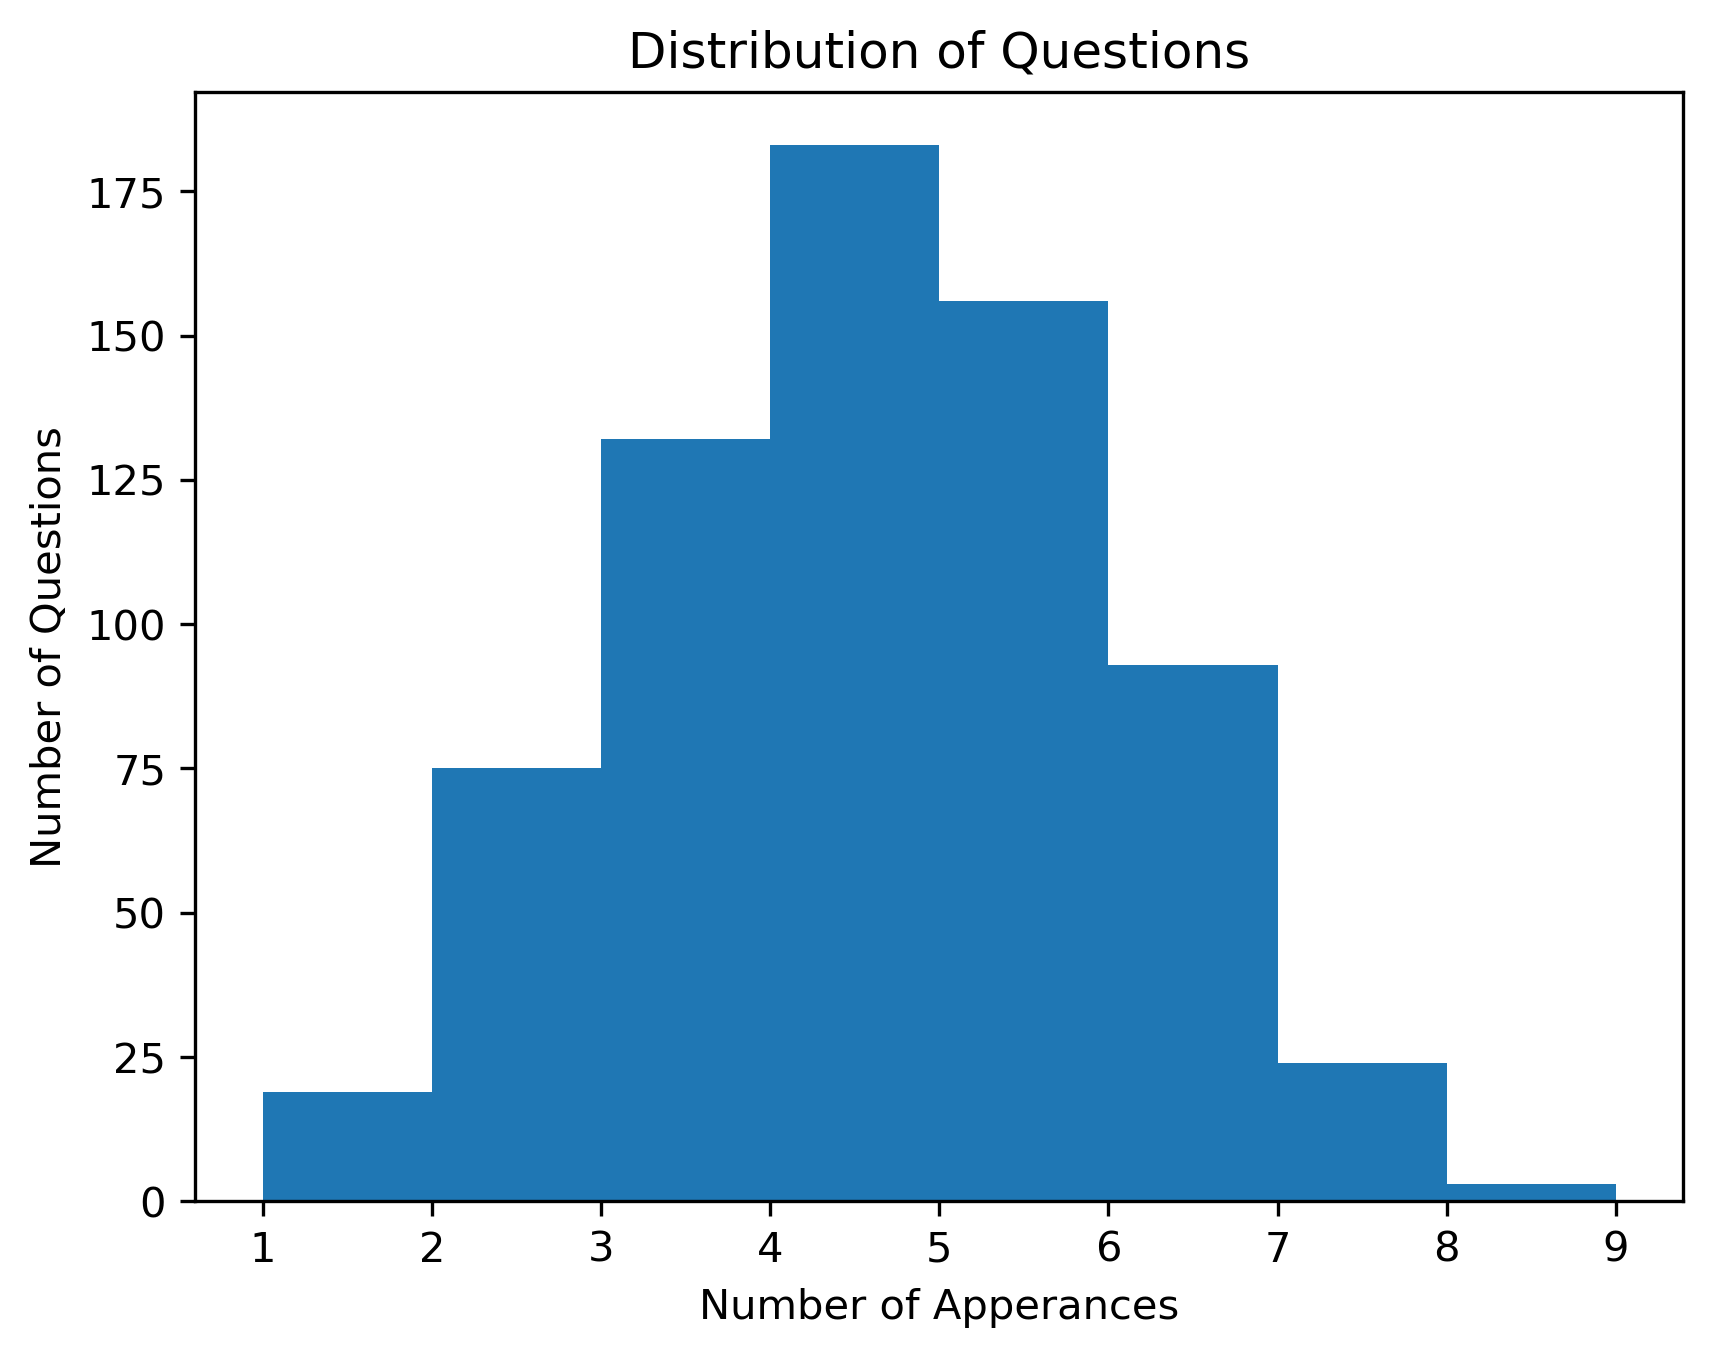

In [13]:
question_df["participant+question_id"] = question_df["participant_id"].astype(str) + question_df["question_id"].astype(str)
plt.hist(list(question_df['question_id'].value_counts()), bins=max(question_df['question_id'].value_counts() - 1))
plt.xlabel("Number of Apperances")
plt.ylabel("Number of Questions")
plt.title("Distribution of Questions")
plt.savefig('../figures/question_distribution.png')

Plot distribution of weight on advice.

Average WoA was 0.337 with a standard deviation of 0.395
Proportion of WoA set to 0: 40.45%


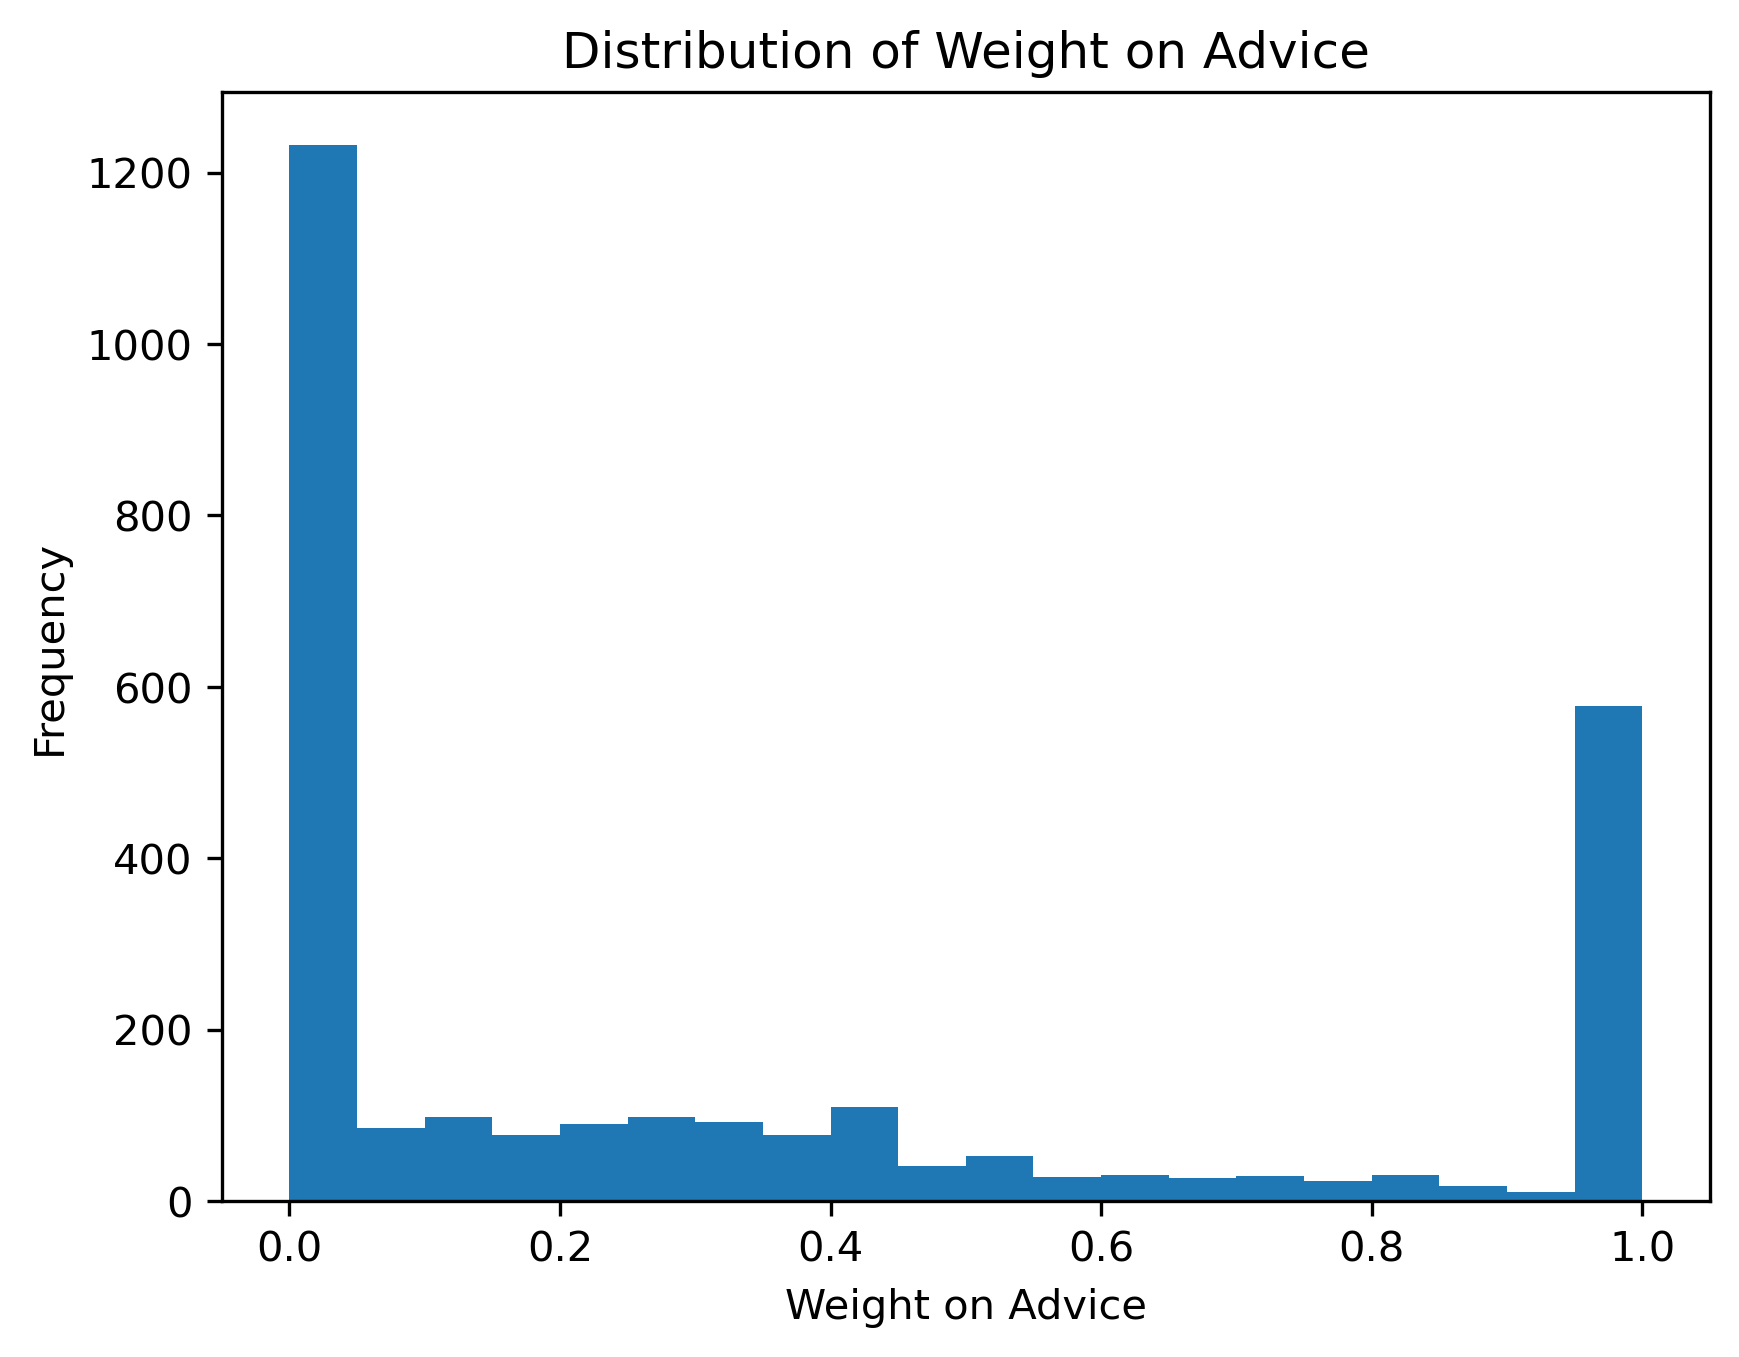

In [14]:
print(f"Average WoA was {question_df['weight_on_advice'].mean():.3f} with a standard deviation of {question_df['weight_on_advice'].std():.3f}")
print(f"Proportion of WoA set to 0: {(question_df['weight_on_advice'] == 0).mean():.2%}")
question_df['weight_on_advice'].plot.hist(bins=20)
plt.title("Distribution of Weight on Advice")
plt.xlabel("Weight on Advice")
plt.ylabel("Frequency")
plt.savefig("../figures/weight_on_advice_dist.png")
plt.show()

## Question Count

Plot dropoff in questions answered after 20.

Participants answered an average of 24.0 questions.
Number of participant who answered 25 questions or less: 92
Number of participant who answered more than 25 questions: 26


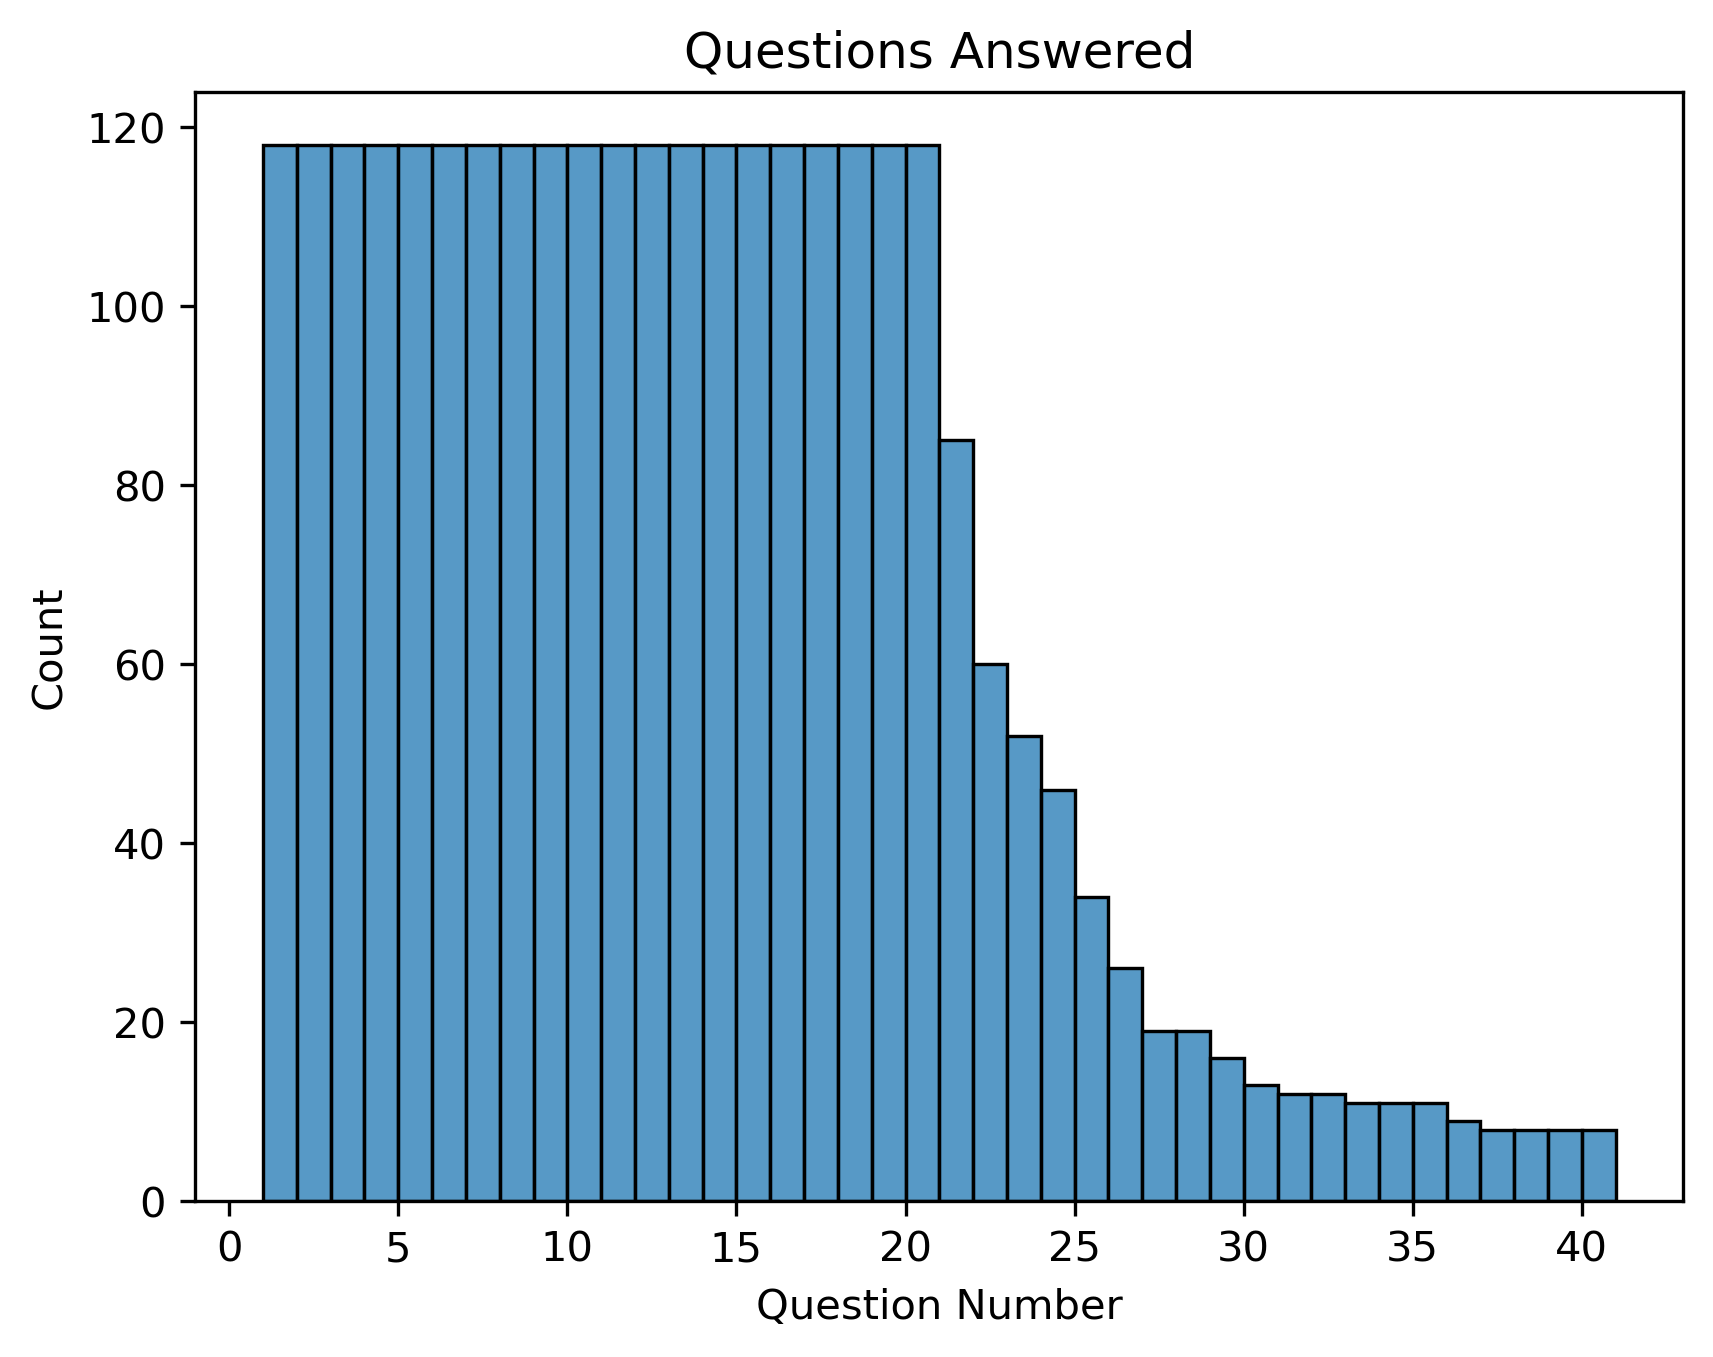

In [15]:
print(f"Participants answered an average of {question_df.groupby('participant_id')['question_num'].count().mean():.1f} questions.")
print(f"Number of participant who answered 25 questions or less: {len(question_df.groupby('participant_id').filter(lambda x: len(x) <= 25)['participant_id'].unique())}")
print(f"Number of participant who answered more than 25 questions: {len(question_df.groupby('participant_id').filter(lambda x: len(x) > 25)['participant_id'].unique())}")
sns.histplot(data=question_df, x="question_num", bins=np.arange(1, 42))
plt.xlabel("Question Number")
plt.title("Questions Answered")
plt.savefig('../figures/questions_answered.png')
plt.show()

Plot average weight on advice through the experiment.

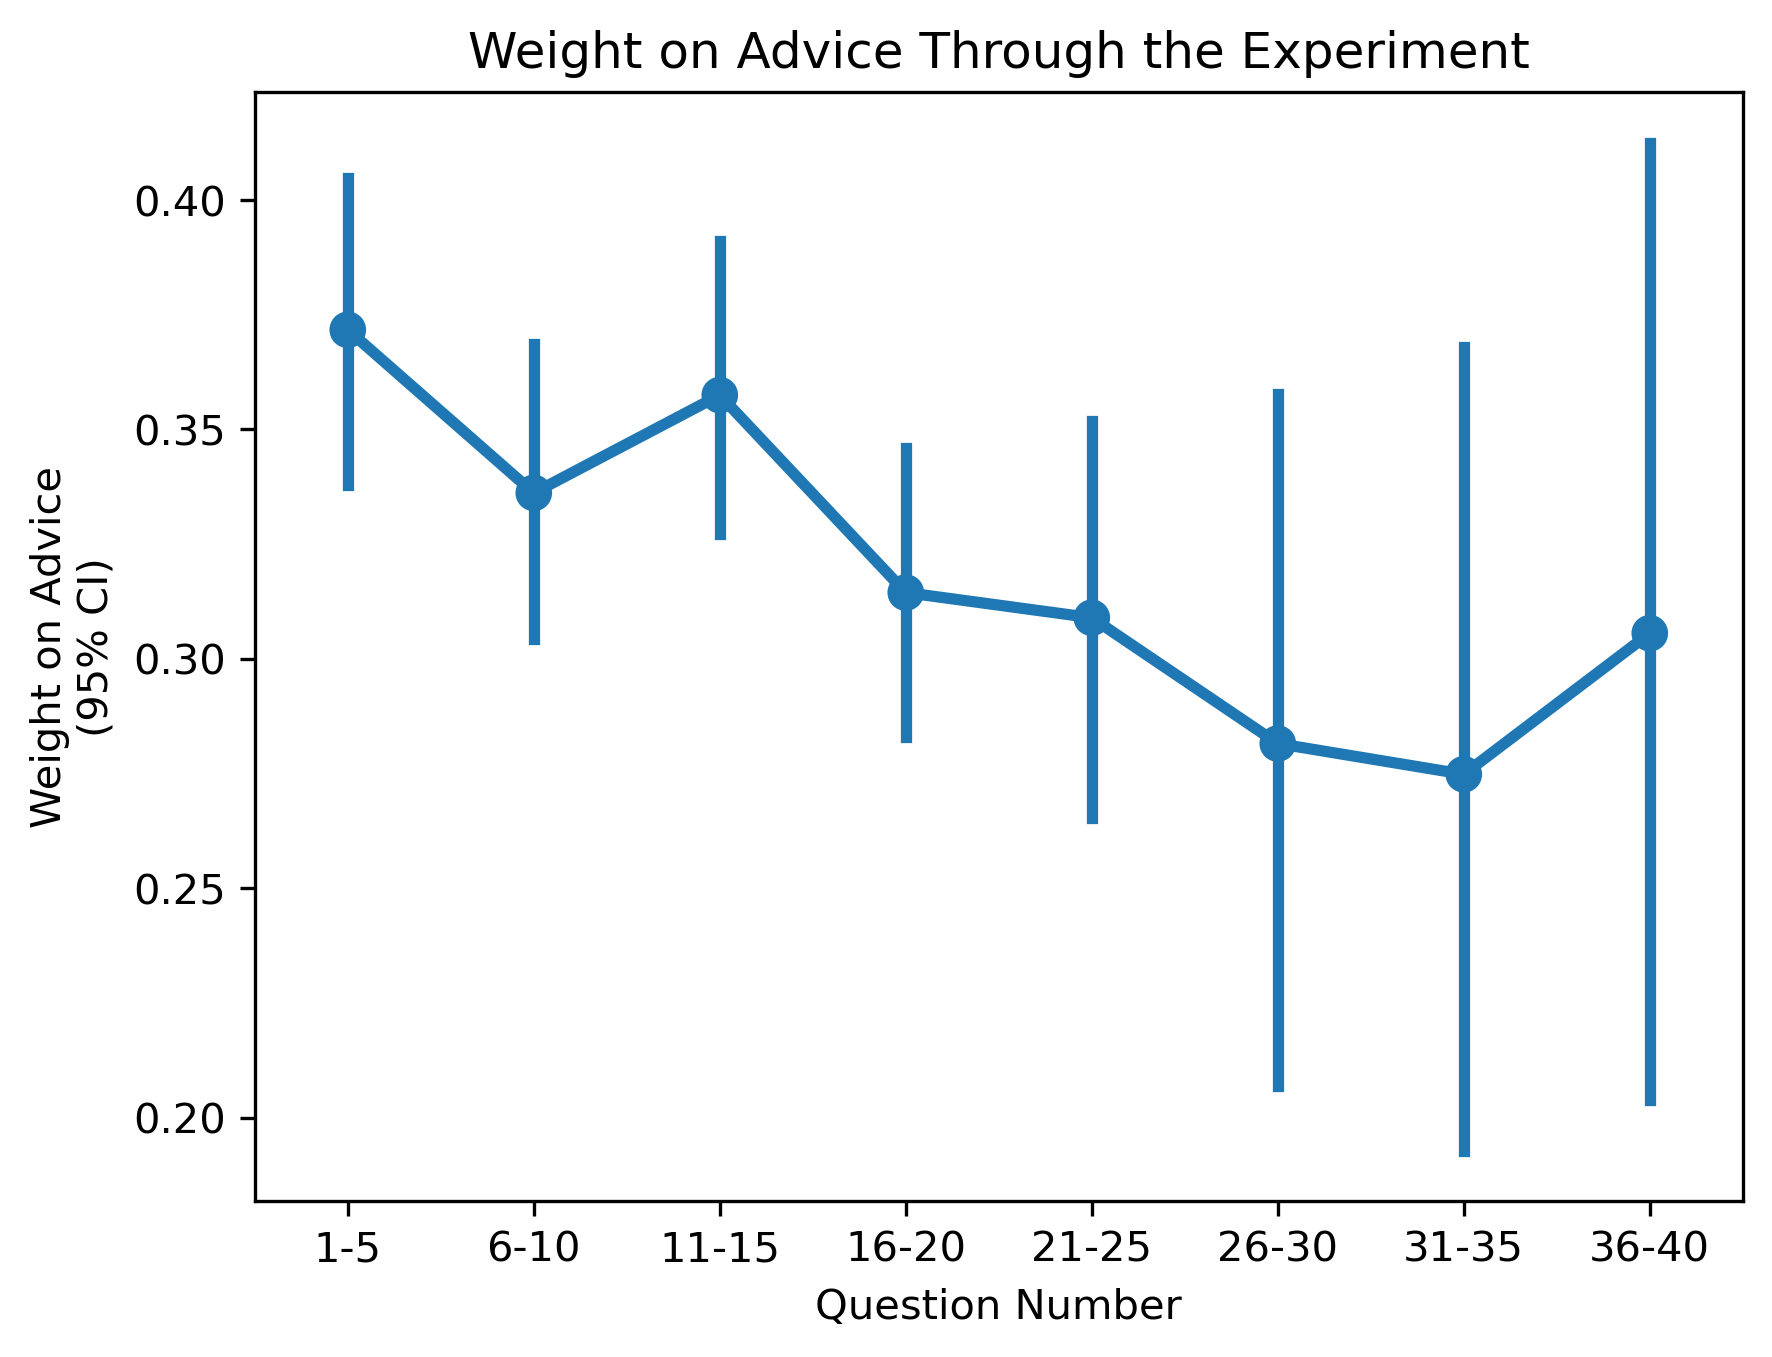

In [16]:
g = sns.pointplot(data=question_df, x="question_group", y="weight_on_advice", errorbar=('ci',95))
plt.title('Weight on Advice Through the Experiment')
plt.xlabel('Question Number')
g.set_xticklabels(labels=[f'{i}-{i+4}' for i in range(1, 41, 5)])
plt.ylabel('Weight on Advice\n(95% CI)')
plt.savefig('../figures/over_questions.png')
plt.show()

Analysis of variance for question group.

In [17]:
model = smf.ols('weight_on_advice ~ C(question_group)', data=question_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq      df         F   PR(>F)
C(question_group)    2.022631     7.0  1.853575  0.07317
Residual           439.599849  2820.0       NaN      NaN

Participant majors.

## Topic Familiarity

From the section `Appendix B.2`. First calculate overall accuracy.

In [18]:
def pick_answer(row: pd.Series, type=str) -> str:
    """Pick answer based on confidence and randomly tiebreak."""
    assert type in ('init', 'adjusted', 'simulated'), 'type must be init or adjusted'

    random.seed(0)
    choices = [row[f'{type}_choice{letter}'] for letter in ['A', 'B', 'C', 'D']]
    max_conf = max(choices)
    choices = [letter for letter, conf in zip(['A', 'B', 'C', 'D'], choices) if conf == max_conf]
    return random.choice(choices)

question_df['init_answer'] = question_df.apply(pick_answer, axis=1, type='init')
question_df['init_answer_correct'] = question_df['init_answer'] == question_df['correct_answer']
question_df['adjusted_answer'] = question_df.apply(pick_answer, axis=1, type='adjusted')
question_df['adjusted_answer_correct'] = question_df['adjusted_answer'] == question_df['correct_answer']

In [19]:
ANSWER_COLS = ['init_answer_correct', 'adjusted_answer_correct', 'advice_is_correct']
COMFORT_LEVELS = ["Combined", 'Uncomfortable', 'Neutral', 'Comfortable']
def eval_accuracy(df, comfort_level, answer_col):
    """Evaluates the mean and standard error of accuracy for a given comfort level."""
    assert answer_col in ANSWER_COLS
    assert comfort_level in COMFORT_LEVELS

    if comfort_level != "Combined":
        df = df[df['topic_familiarity'] == comfort_level]
    
    accuracy = df[answer_col].mean()
    se = df[answer_col].sem()

    return accuracy, se

In [20]:
# evaluate and plot
accuracy_data = []
for answer_col, comfort_level in product(ANSWER_COLS, COMFORT_LEVELS):
    accuracy, se = eval_accuracy(question_df, comfort_level, answer_col)
    accuracy_data.append({'answer_col': answer_col, 'comfort_level': comfort_level, 'accuracy': accuracy, 'se': se})
accuracy_df = pd.DataFrame(accuracy_data, columns=['answer_col', 'comfort_level', 'accuracy', 'se'])

# evaluate which accuracies are significantly different from combined
sig_diff = []
for answer_col in ANSWER_COLS:
    combined_accuracy = accuracy_df[(accuracy_df['answer_col'] == answer_col) & (accuracy_df['comfort_level'] == 'Combined')]['accuracy'].values[0]
    for comfort_level in COMFORT_LEVELS:
        accuracy = accuracy_df[(accuracy_df['answer_col'] == answer_col) & (accuracy_df['comfort_level'] == comfort_level)]['accuracy'].values[0]
        se = accuracy_df[(accuracy_df['answer_col'] == answer_col) & (accuracy_df['comfort_level'] == comfort_level)]['se'].values[0] * 1.96
        if accuracy - se > combined_accuracy or accuracy + se < combined_accuracy:
            sig_diff.append((answer_col, comfort_level))

Display accuracy by topic familiarity level.

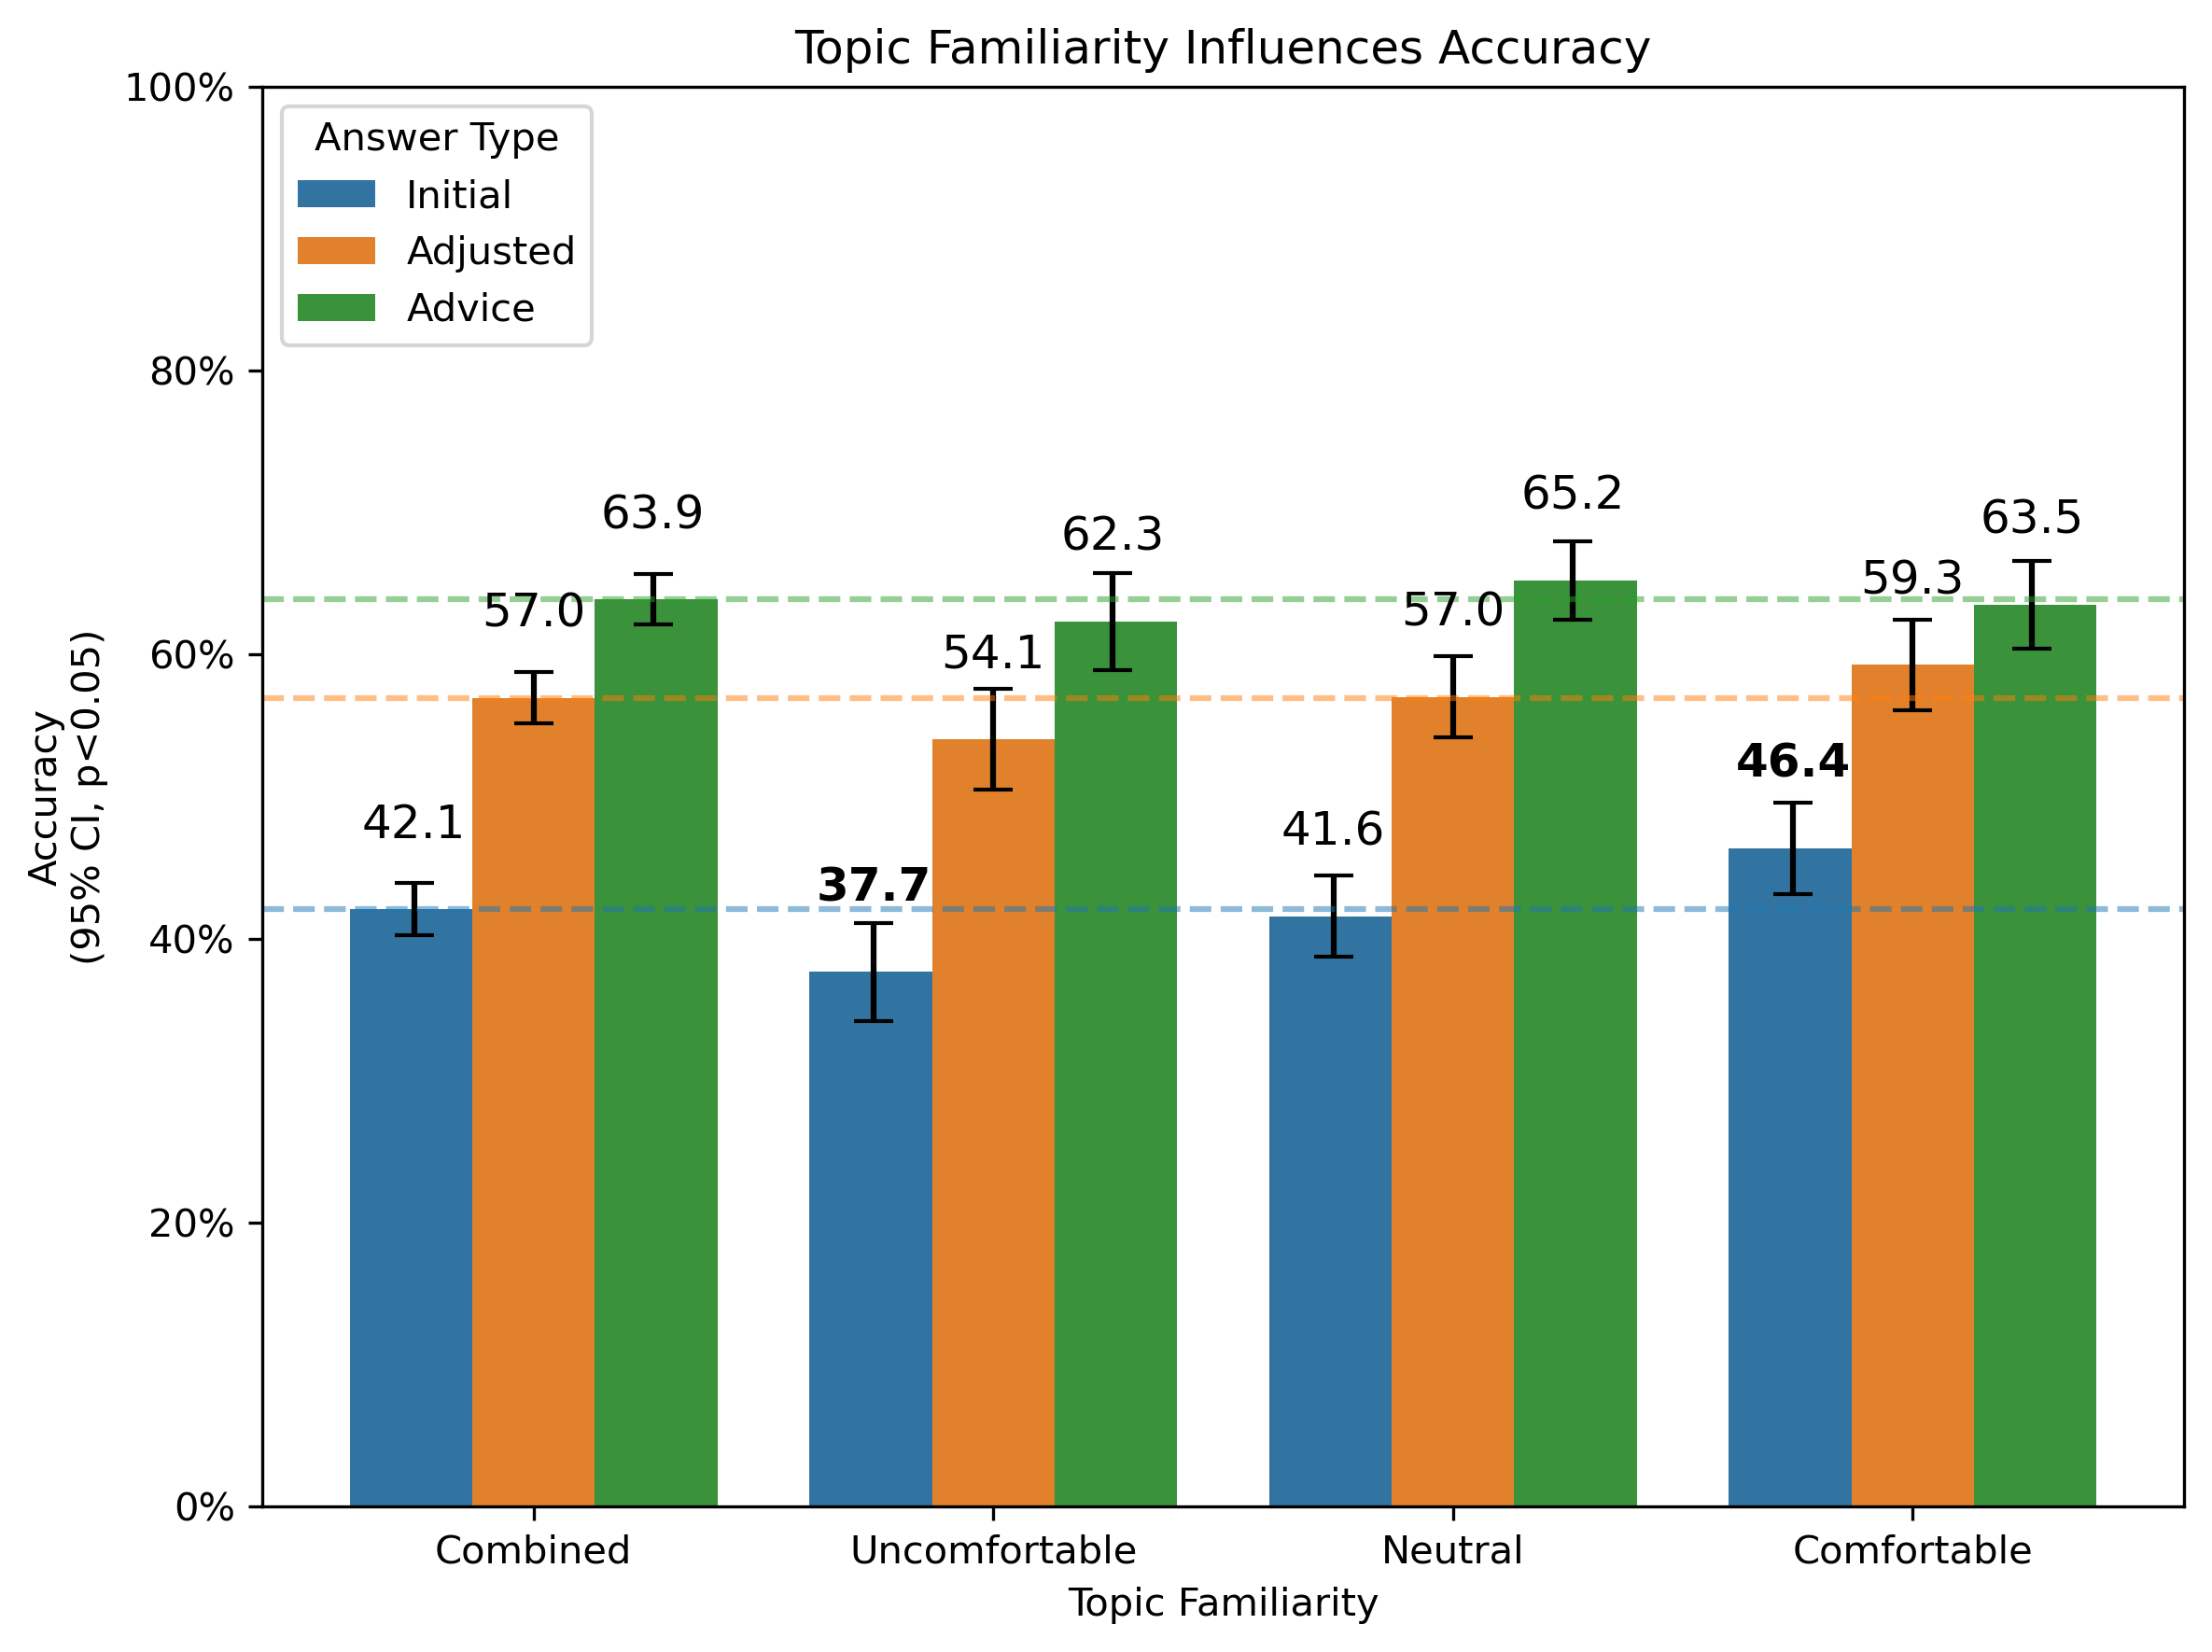

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=accuracy_df, x='comfort_level', y='accuracy', hue='answer_col', ax=ax)
ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy\n(95% CI, p<0.05)')
ax.set_xlabel('Topic Familiarity')
ax.set_title('Topic Familiarity Influences Accuracy')

# plot error bars
for i, answer_col in enumerate(ANSWER_COLS):
    for j, comfort_level in enumerate(COMFORT_LEVELS):
        accuracy = accuracy_df[(accuracy_df['answer_col'] == answer_col) & (accuracy_df['comfort_level'] == comfort_level)]['accuracy'].values[0]
        se = accuracy_df[(accuracy_df['answer_col'] == answer_col) & (accuracy_df['comfort_level'] == comfort_level)]['se'].values[0] * 1.96
        ax.errorbar(j + i * 0.26 - 0.26, accuracy, yerr=se, fmt='none', color='black', capsize=5)

# draw horizontal lines for combined accuracy
for i, answer_col in enumerate(ANSWER_COLS):
    combined_accuracy = accuracy_df[(accuracy_df['answer_col'] == answer_col) & (accuracy_df['comfort_level'] == 'Combined')]['accuracy'].values[0]
    color = {
        'init_answer_correct': 'tab:blue',
        'adjusted_answer_correct': 'tab:orange',
        'advice_is_correct': 'tab:green'
    }[answer_col]
    ax.axhline(combined_accuracy, color=color, linestyle='--', alpha=0.5)

# annotate accuracy at top of each bar
for i, answer_col in enumerate(ANSWER_COLS):
    for j, comfort_level in enumerate(COMFORT_LEVELS):
        accuracy = accuracy_df[(accuracy_df['answer_col'] == answer_col) & (accuracy_df['comfort_level'] == comfort_level)]['accuracy'].values[0]

        # bold if significantly different from combined
        fontweight = 'bold' if (answer_col, comfort_level) in sig_diff else 'normal'
        ax.annotate(f"{accuracy * 100:.1f}", xy=(j + i * 0.26 - 0.26, accuracy + 0.05), ha='center', fontsize=12, fontweight=fontweight)

# rename legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Initial', 'Adjusted', 'Advice'], title='Answer Type', loc='upper left')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.savefig('../figures/accuracy_by_answer_type_and_comfort_level.png')
plt.show()

Comfort summary statistics.

In [22]:
fam_topic_data = []
for i, topic in enumerate(config.fam_topics):
    for c in participant_df[f"familiarity_{i+1}"]:
        fam_topic_data.append({
            "fam_topic":topic,
            "net_familiarity":config.comfort_map[c]
        })
fam_topic_df = pd.DataFrame(fam_topic_data)

In [23]:
sorted_topics = fam_topic_df.groupby('fam_topic')['net_familiarity'].mean().sort_values().index

Plot familiarity by topic area. Figure from `Appendix B.1`.

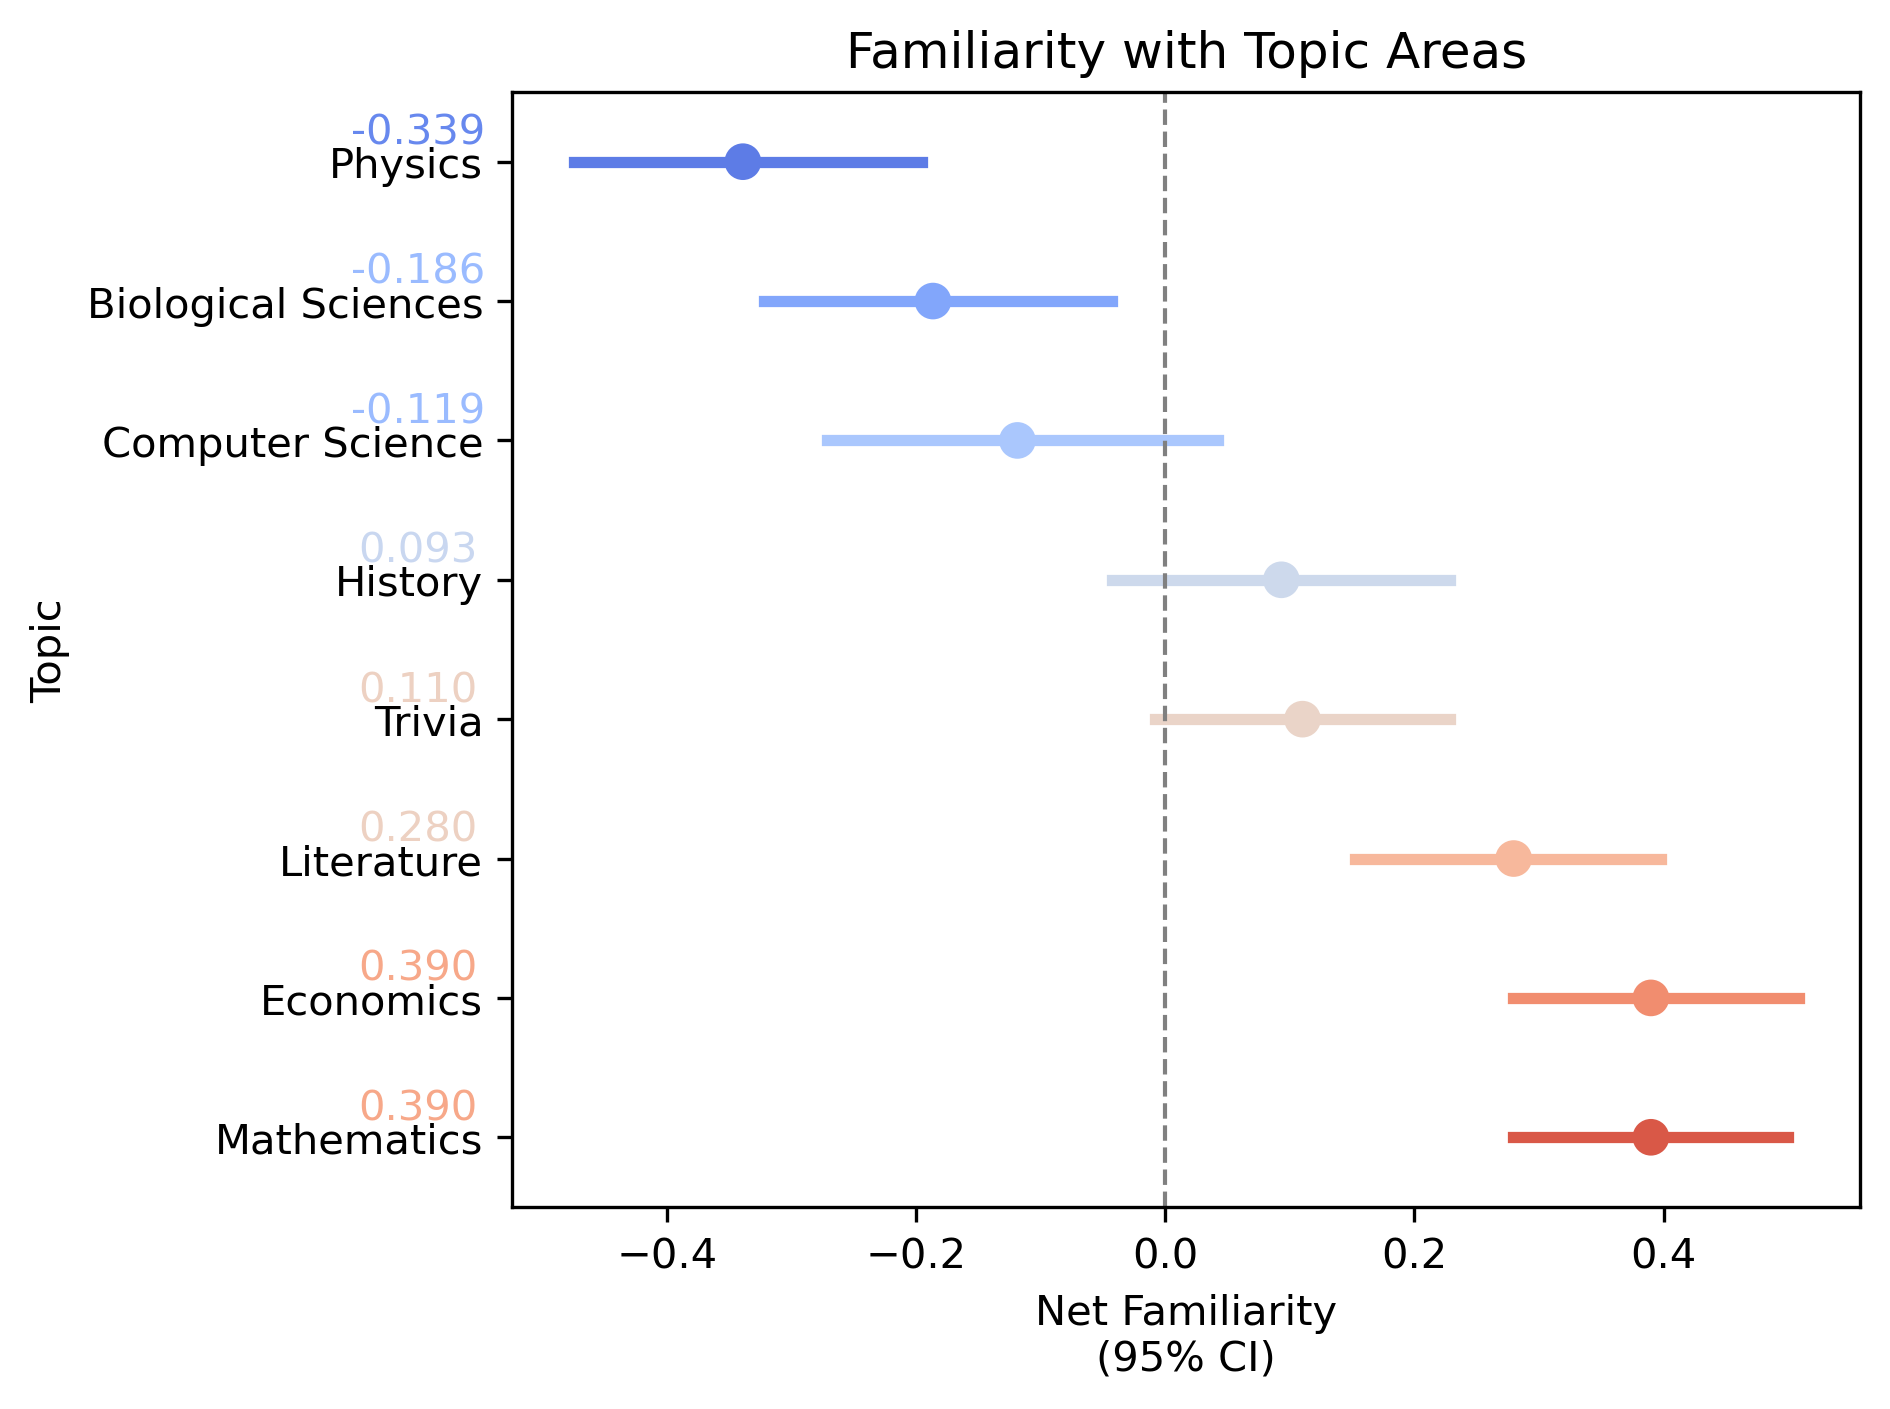

In [24]:
sorted_topics = fam_topic_df.groupby('fam_topic')['net_familiarity'].mean().sort_values().index
sns.pointplot(x='net_familiarity', y='fam_topic', data=fam_topic_df, hue_order=COMFORT_LEVELS, palette="coolwarm", order=sorted_topics, orient='h')
# annotate net mean
for i, label in enumerate(plt.gca().get_yticklabels()):
    mean_net_comfort = fam_topic_df[fam_topic_df['fam_topic'] == label._text]['net_familiarity'].mean()
    color = sns.color_palette("coolwarm")[round(5*mean_net_comfort) + 2]
    plt.gca().text(-.6, i-.13, f"{mean_net_comfort:.3f}", ha='center', color=color)
plt.gca().axvline(0, color='grey', linestyle='--', linewidth=1)  # add thin zero line
# pad top
plt.gca().set_yticklabels(sorted_topics)

plt.ylabel('Topic')
plt.xlabel('Net Familiarity\n(95% CI)')
plt.title('Familiarity with Topic Areas')
plt.tight_layout()
plt.savefig('../figures/familiarity.png')
plt.show()

## Usage

Plot weight on advice by usage level for each displayed advisor.

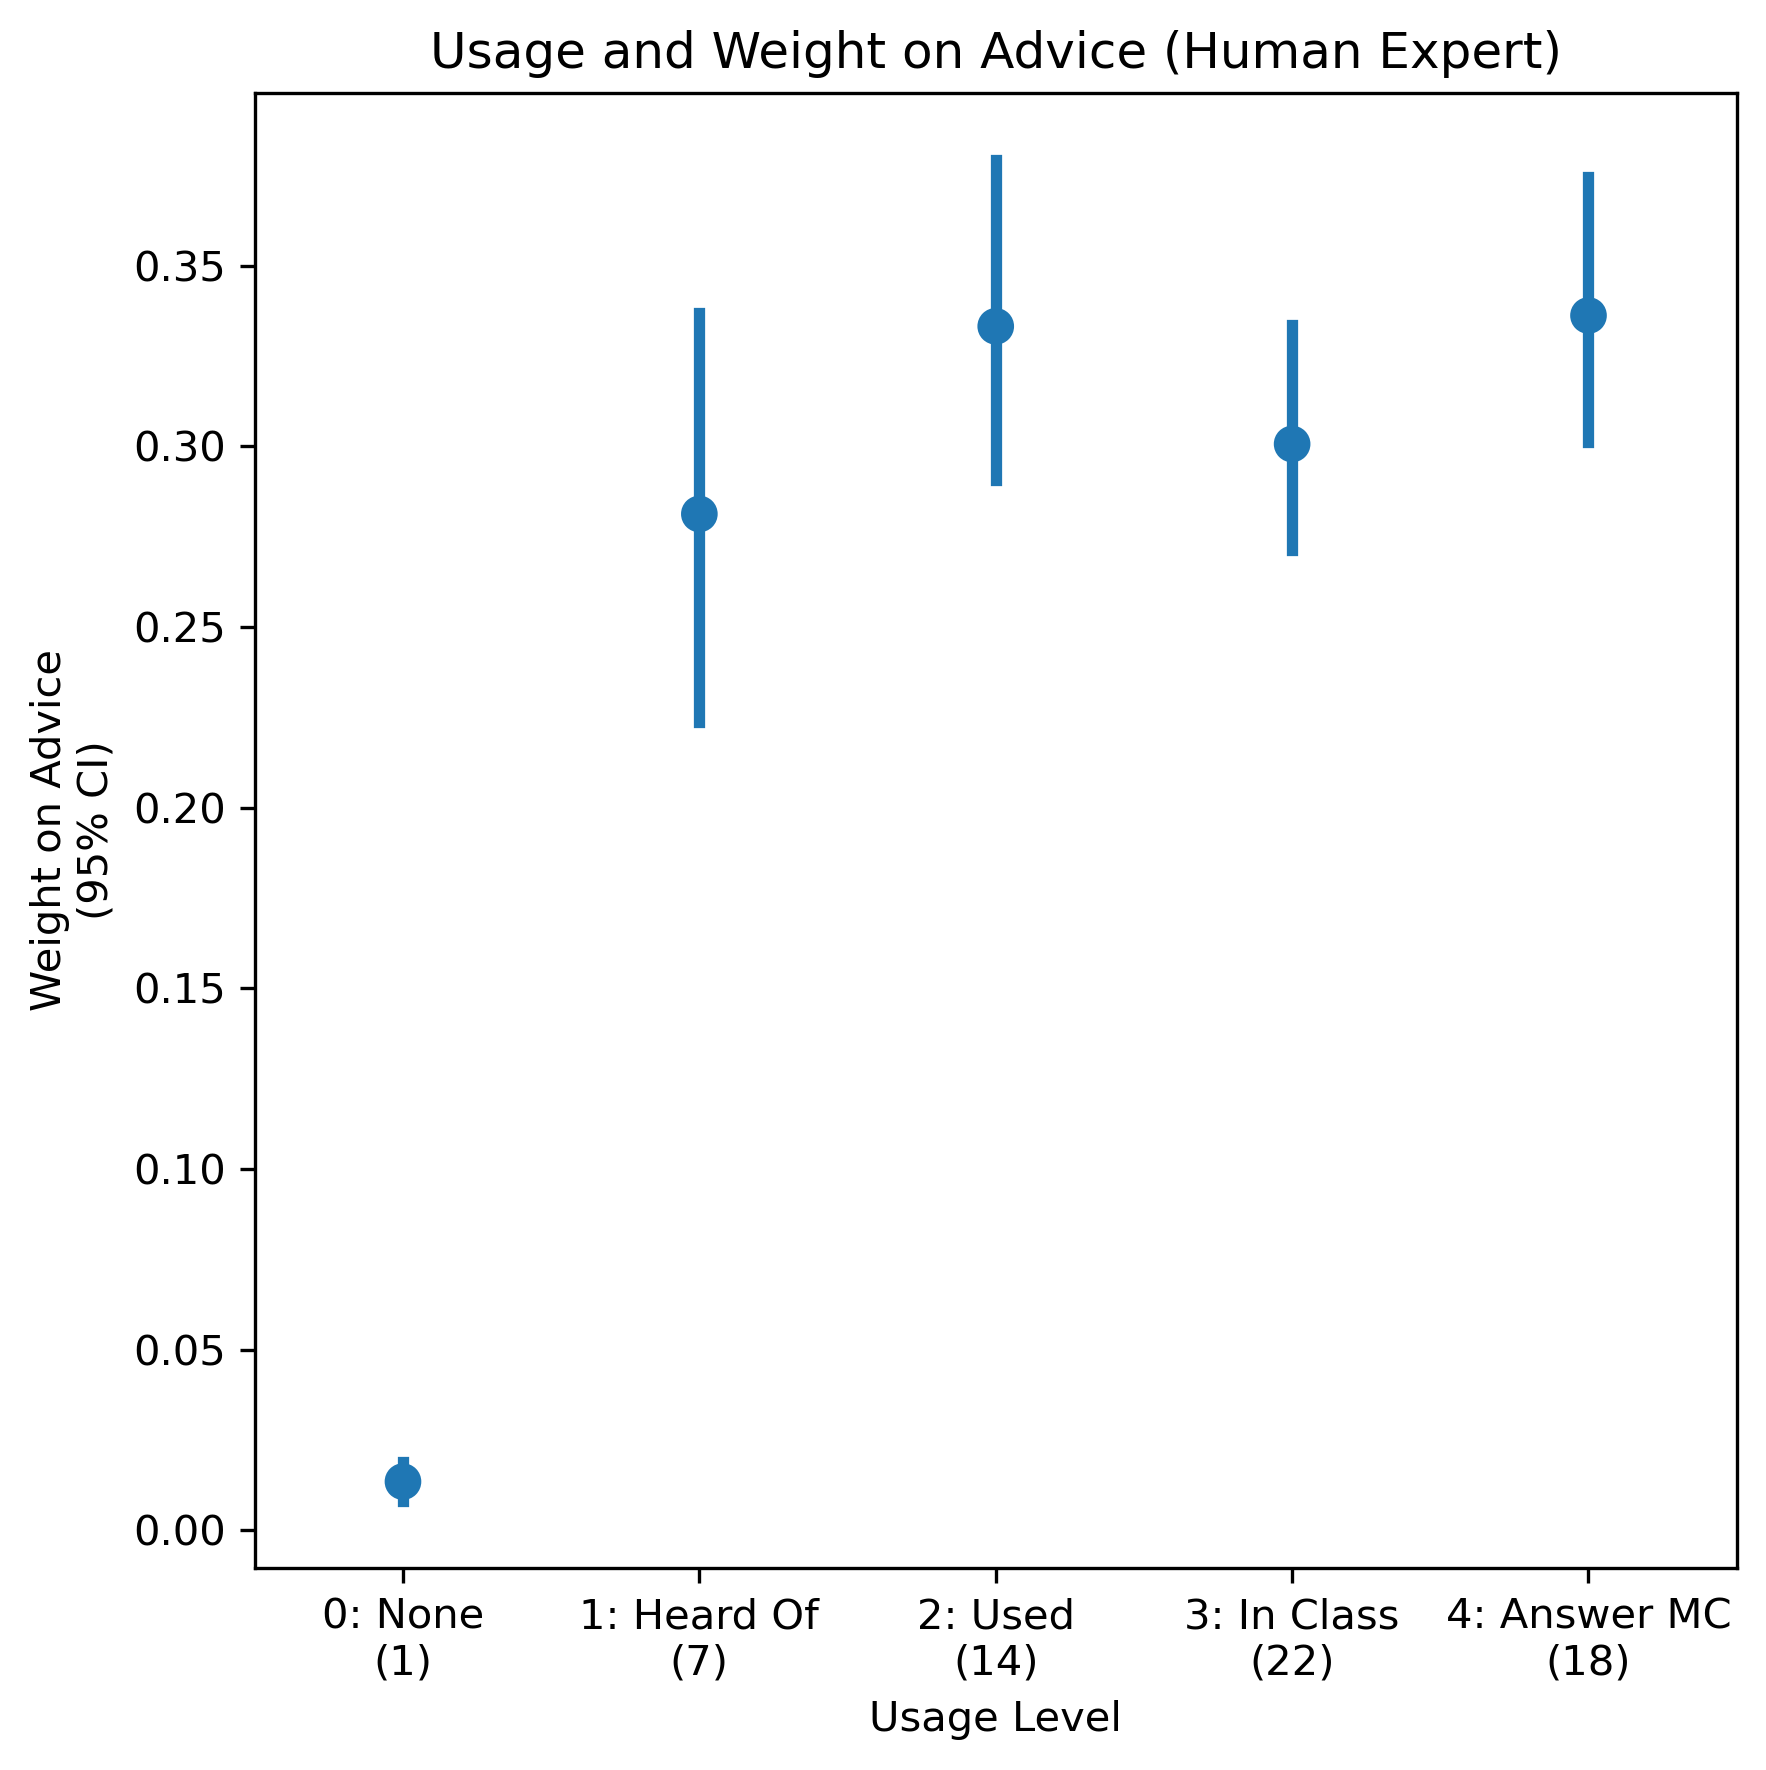

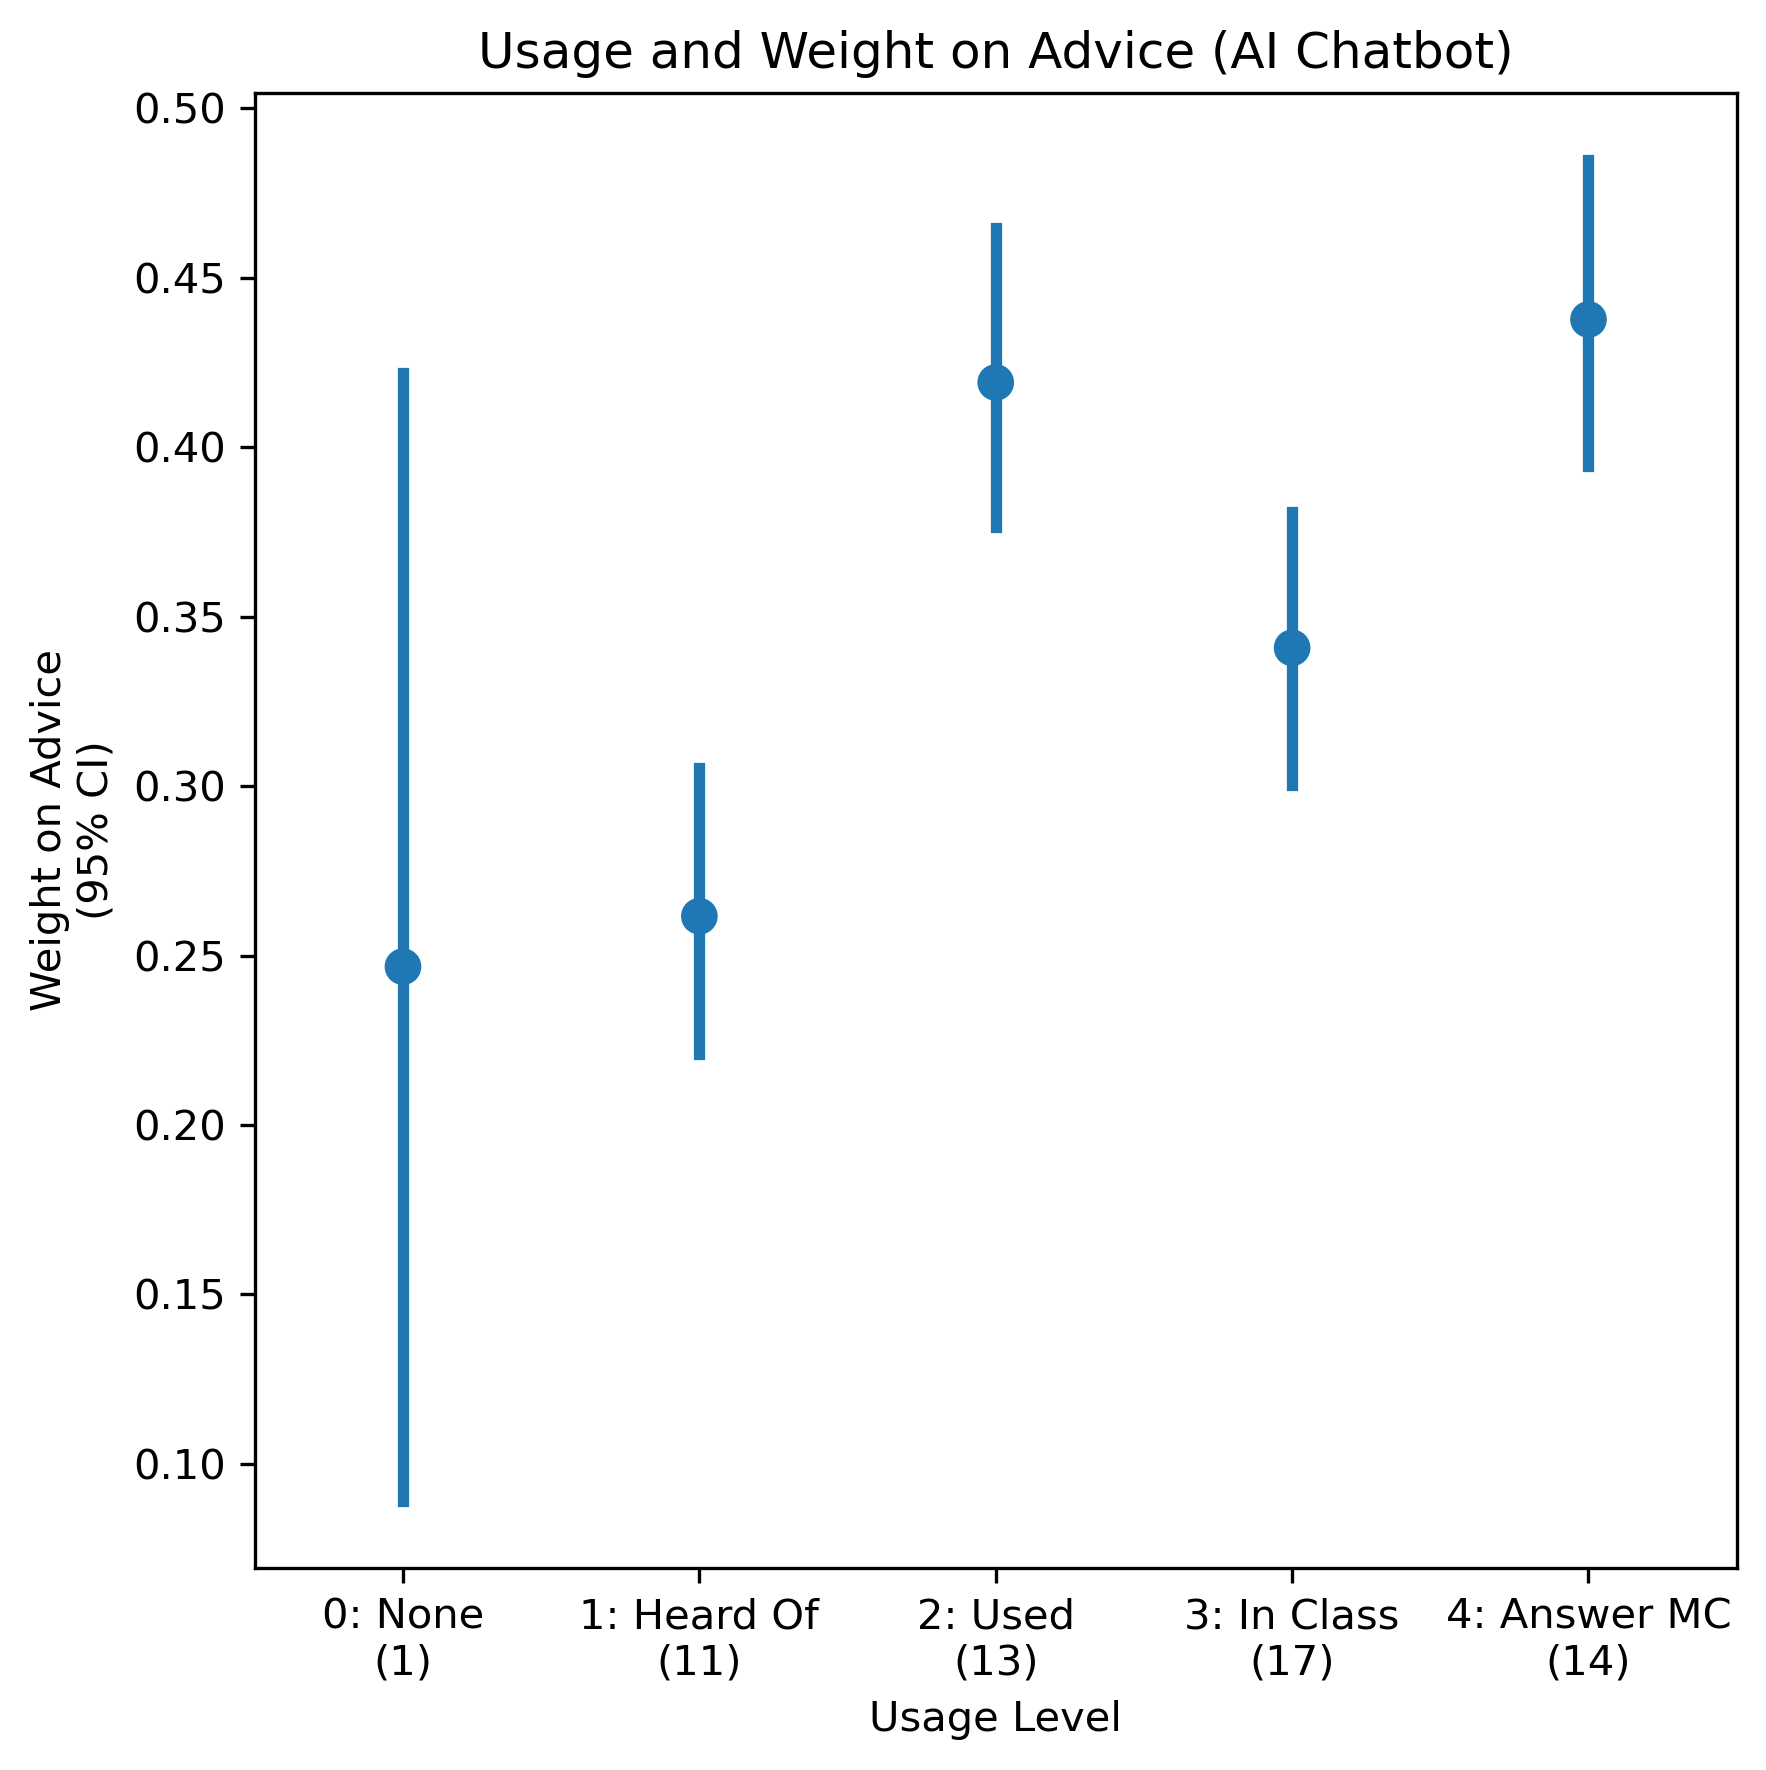

In [25]:
for advisor in ("expert", "AI chatbot"):
    condition_name = "AI Chatbot" if advisor == 'AI chatbot' else "Human Expert"
    # plot woa by usage level
    advisor_df = question_df[question_df['advisor'] == advisor].copy()
    plt.figure(figsize=(6, 6))
    sns.pointplot(x='usage_level', y='weight_on_advice', data=advisor_df, errorbar=('ci',95), join=False)
    plt.title(f'Usage and Weight on Advice ({condition_name})')
    plt.xlabel('Usage Level')
    plt.ylabel('Weight on Advice\n(95% CI)')
    usage_levels = ['None', 'Heard Of', 'Used', 'In Class', 'Answer MC']
    x_labels = []
    for i, level in enumerate(usage_levels):
        participant_count = len(advisor_df[advisor_df['usage_level'] == i]['participant_id'].unique())
        x_labels.append(f"{i}: {level}\n({participant_count})")
    plt.gca().set_xticklabels(x_labels)
    plt.tight_layout()
    plt.savefig(f"../figures/woa_by_advisor_{advisor}.png")

## Advice Confidence

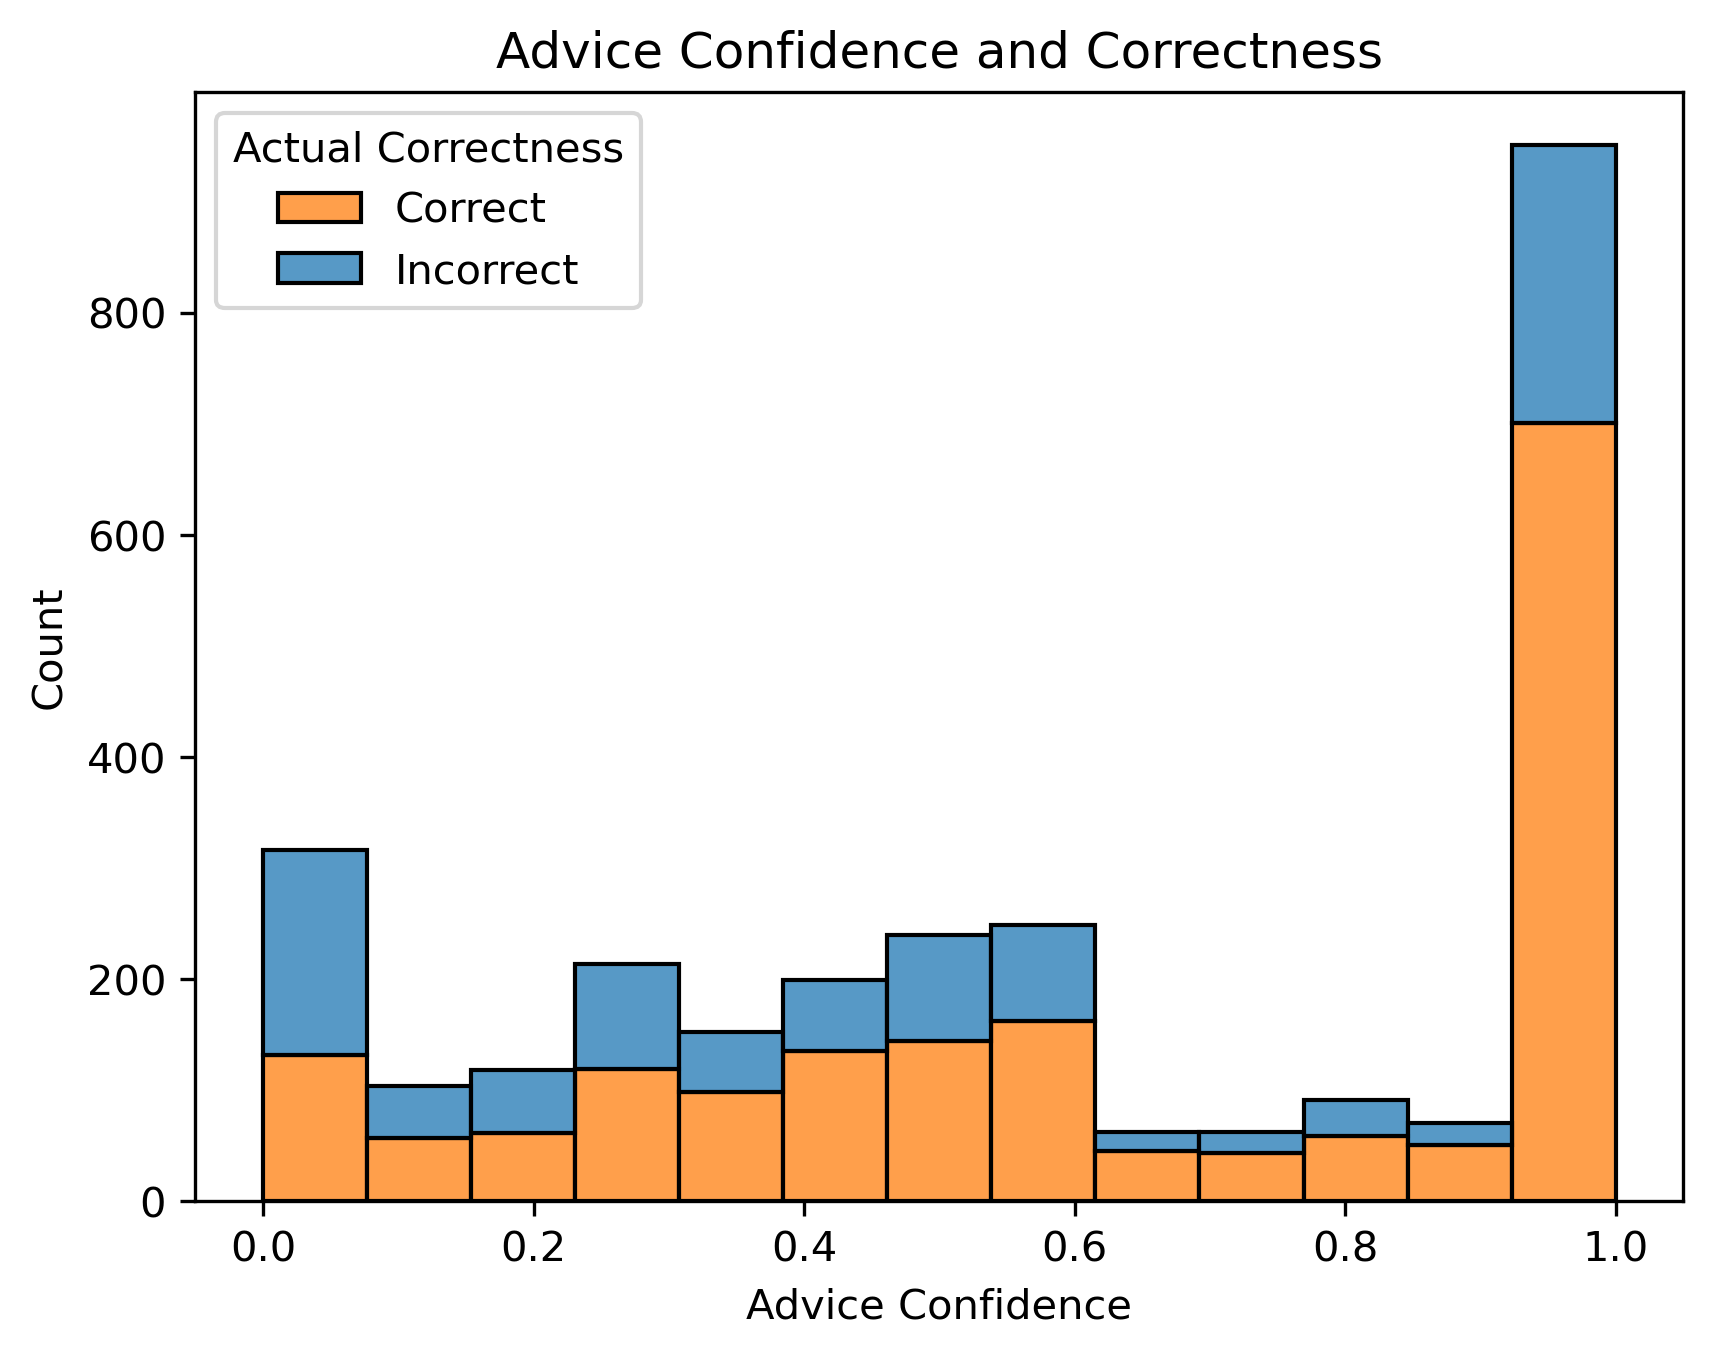

In [26]:
g = sns.histplot(data=question_df, x="advice_confidence", hue="advice_is_correct", multiple="stack")
plt.xlabel("Advice Confidence")
plt.legend(['Correct', 'Incorrect'], title='Actual Correctness')
plt.title('Advice Confidence and Correctness')
plt.savefig('../figures/advice_correctness_belief.png')
plt.show()

## Advice Accuracy Belief

Calculate expected belief in the accuracy of advice.

Mean advice accuracy belief: 62.5%
Standard deviation of advice accuracy belief: 14.4%


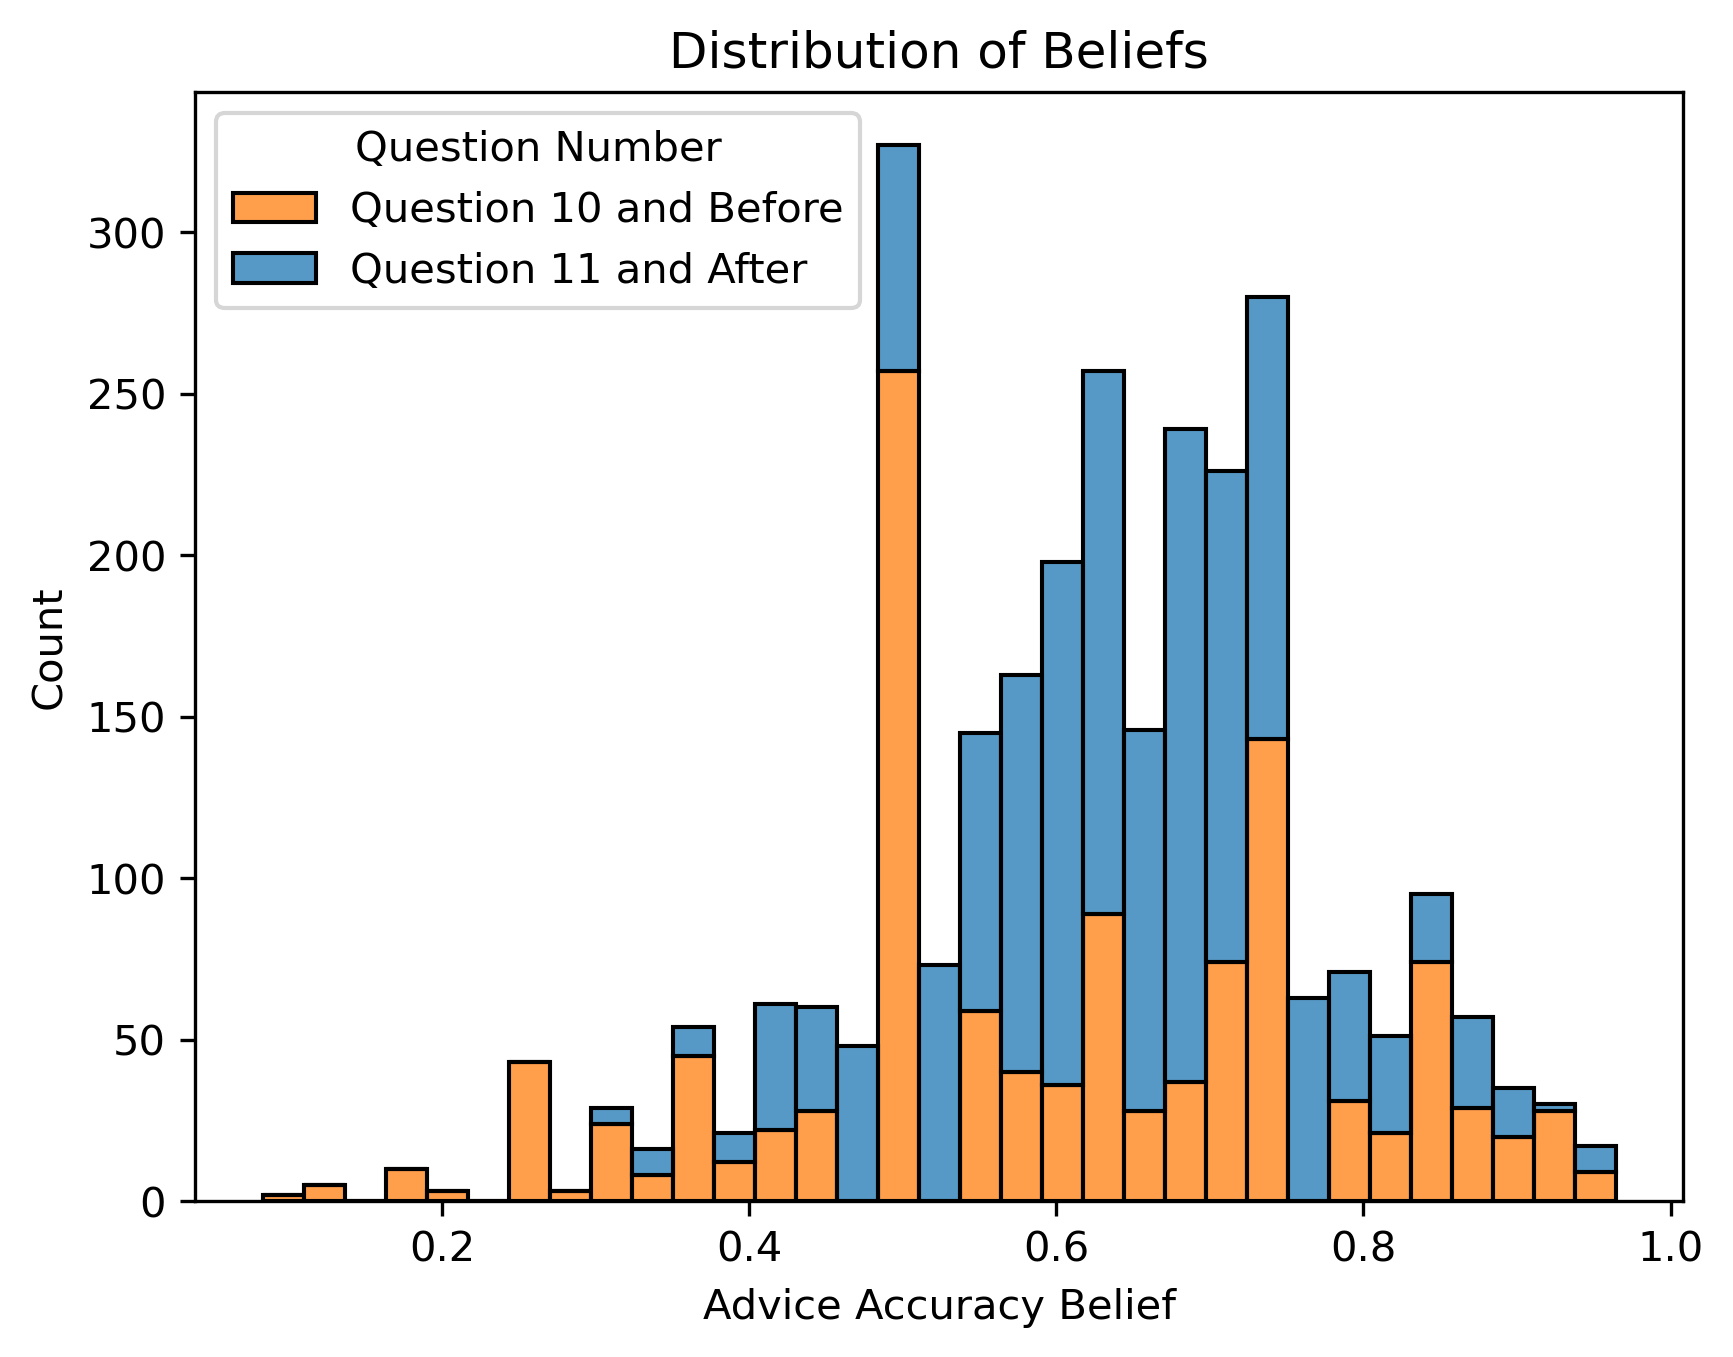

In [27]:
default_prior = (0.5, 0.5)
def beta_posterior(row, prior=default_prior):
    """Calculate the posterior beta distribution for a given row"""
    beta = prior[0] + row['correct_advice_count']
    alpha = prior[1] + row['incorrect_advice_count']
    return beta / (beta + alpha)
question_df['advice_accuracy_belief'] = question_df.apply(beta_posterior, axis=1)

print(f"Mean advice accuracy belief: {question_df['advice_accuracy_belief'].mean():.1%}")
print(f"Standard deviation of advice accuracy belief: {question_df['advice_accuracy_belief'].std():.1%}")
question_df["before_question_10"] = question_df["question_num"] <= 10
sns.histplot(data=question_df, x="advice_accuracy_belief", hue="before_question_10", multiple="stack")
plt.title('Distribution of Beliefs')
plt.legend(['Question 10 and Before', 'Question 11 and After'], title='Question Number')
plt.xlabel('Advice Accuracy Belief')
plt.ylabel('Count')
plt.savefig('../figures/advice_accuracy_belief.png')
plt.show()

# Weight on Advice

Regressions from the section `Weight on Advice`.

In [28]:
regression_results = {}
question_df["group"] = 1 # same group for all, necessary for mixed effects
default_vcf = {"question_id": "0 + C(question_id)",
               "participant_id": "0 + C(participant_id)"}

def eval_spec(formula:str, vcf:dict=default_vcf, spec_name:str=""):
    if spec_name: print(spec_name)
    model = sm.MixedLM.from_formula(formula, groups="group",                                                    
                                vc_formula=vcf, data=question_df)                                                   
    result = model.fit()
    return result

## Regression A

Regressing on the advisor identity and justification with interaction term and no controls.

In [29]:
formula = "weight_on_advice ~ advisor * give_justification"
result = eval_spec(formula)
regression_results["A"] = result
result.summary()

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
======================================================================================
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1116          
Min. group size:          2828            Log-Likelihood:             -1107.5007      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.329    0.044  7.507 0.000  0.243  0.415
advisor[T.expert]                           -0.027    0.059 -0.452 0.651 -0.143  0.090
give_justification[T.yes]                    0.057    0.058  0.988 0.323 -0.056  0.170
advisor[T.expert]:give_justification[T.yes] -0.027    0.079 -0.346 0.729 -0.183  0.128
participant_id Var                           0.041    0.019                           
question_id Var                              0.005    0.006                           
======================================================================================

"""

## Regression B

Regressions on topic familiarity.

In [30]:
formula = "weight_on_advice ~ advisor * give_justification\
    + topic_familiarity"
result = eval_spec(formula)
regression_results["B"] = result
result.summary()

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
======================================================================================
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1117          
Min. group size:          2828            Log-Likelihood:             -1109.1272      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.302    0.045  6.651 0.000  0.213  0.390
advisor[T.expert]                           -0.028    0.059 -0.468 0.640 -0.144  0.089
give_justification[T.yes]                    0.056    0.058  0.964 0.335 -0.057  0.169
topic_familiarity[T.Neutral]                 0.026    0.018  1.459 0.145 -0.009  0.060
topic_familiarity[T.Uncomfortable]           0.061    0.020  3.046 0.002  0.022  0.101
advisor[T.expert]:give_justification[T.yes] -0.021    0.079 -0.265 0.791 -0.176  0.134
participant_id Var                           0.040    0.019                           
question_id Var                              0.004    0.006                           
======================================================================================

"""

In [31]:
# B2
formula = "weight_on_advice ~ advisor * give_justification\
       + topic_familiarity"
regression_results["B2"] = eval_spec(formula=formula)

# B3
formula = "weight_on_advice ~ advisor * give_justification\
       + topic_familiarity * advisor"
vcf = {"question_id": "0 + C(question_id)",
       "participant_id": "0 + C(participant_id)",
       "topic": "0 + C(topic)"}
regression_results["B3"] = eval_spec(formula=formula, vcf=vcf)

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## Regression C

Regress prior usage of AI chatbots.

In [32]:
formula = "weight_on_advice ~ advisor * give_justification\
    + topic_familiarity + usage_level * advisor"
result = eval_spec(formula)
regression_results["C"] = result
result.summary()

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
======================================================================================
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1117          
Min. group size:          2828            Log-Likelihood:             -1112.5200      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.169    0.081  2.072 0.038  0.009  0.329
advisor[T.expert]                            0.056    0.118  0.472 0.637 -0.175  0.286
give_justification[T.yes]                    0.064    0.057  1.116 0.264 -0.048  0.176
topic_familiarity[T.Neutral]                 0.027    0.018  1.521 0.128 -0.008  0.061
topic_familiarity[T.Uncomfortable]           0.062    0.020  3.091 0.002  0.023  0.102
advisor[T.expert]:give_justification[T.yes] -0.025    0.079 -0.321 0.749 -0.180  0.129
usage_level                                  0.050    0.025  1.946 0.052 -0.000  0.099
usage_level:advisor[T.expert]               -0.033    0.036 -0.902 0.367 -0.104  0.039
participant_id Var                           0.040    0.018                           
question_id Var                              0.004    0.006                           
======================================================================================

"""

In [33]:
formulas = [
    "weight_on_advice ~ advisor * give_justification\
        + topic_familiarity + usage_level", # C2
    "weight_on_advice ~ advisor * give_justification\
        + topic_familiarity + C(usage_level)", # C3
    "weight_on_advice ~ advisor * give_justification\
        + topic_familiarity + used * advisor", # C4
]
for i, formula in enumerate(formulas):
    regression_results[f"C{i+2}"] = eval_spec(formula)

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## Regression D

Regress on advice quality, measured by whether the advice is correct.

In [34]:
formula = "weight_on_advice ~ advisor * give_justification\
    + topic_familiarity + usage_level * \
    advisor + advice_is_correct"
result = eval_spec(formula)
regression_results["D"] = result
result.summary()

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
======================================================================================
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1117          
Min. group size:          2828            Log-Likelihood:             -1115.4209      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    0.161    0.082  1.962 0.050  0.000  0.321
advisor[T.expert]                            0.054    0.118  0.463 0.643 -0.176  0.285
give_justification[T.yes]                    0.064    0.057  1.124 0.261 -0.048  0.177
topic_familiarity[T.Neutral]                 0.027    0.018  1.512 0.130 -0.008  0.061
topic_familiarity[T.Uncomfortable]           0.062    0.020  3.096 0.002  0.023  0.102
advisor[T.expert]:give_justification[T.yes] -0.025    0.079 -0.319 0.750 -0.180  0.129
usage_level                                  0.049    0.025  1.946 0.052 -0.000  0.099
usage_level:advisor[T.expert]               -0.033    0.036 -0.896 0.370 -0.104  0.039
advice_is_correct                            0.013    0.015  0.910 0.363 -0.015  0.042
participant_id Var                           0.039    0.018                           
question_id Var                              0.004    0.006                           
======================================================================================

"""

In [35]:
formulas = [
    "weight_on_advice ~ advisor * give_justification\
        + topic_familiarity + usage_level\
        * advisor + advice_is_correct + init_advice_confidence",
    "weight_on_advice ~ advisor * give_justification\
        + topic_familiarity + usage_level\
        * advisor + advice_is_correct\
        + init_advice_confidence + I(init_advice_confidence**2)",
    "weight_on_advice ~ advisor * give_justification\
        + topic_familiarity + usage_level\
        * advisor + advice_is_correct * give_justification\
        + init_advice_confidence + I(init_advice_confidence**2)"
]
for i, formula in enumerate(formulas):
    regression_results[f"D{i+2}"] = eval_spec(formula)

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maxi

In [36]:
formula =  "adjusted_time ~ advisor * give_justification\
        + topic_familiarity + usage_level\
        * advisor + advice_is_correct * give_justification\
        + init_advice_confidence + I(init_advice_confidence**2)"
result = eval_spec(formula)
result.summary()

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
======================================================================================
Model:                     MixedLM          Dependent Variable:          adjusted_time
No. Observations:          2828             Method:                      REML         
No. Groups:                1                Scale:                       56.1820      
Min. group size:           2828             Log-Likelihood:              -9881.3481   
Max. group size:           2828             Converged:                   Yes          
Mean group size:           2828.0                                                     
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                   11.419    1.595  7.161 0.000  8.294 14.545
advisor[T.expert]                            0.871    2.214  0.393 0.694 -3.468  5.210
give_justification[T.yes]                    2.930    1.148  2.552 0.011  0.680  5.180
topic_familiarity[T.Neutral]                -0.326    0.395 -0.825 0.409 -1.101  0.449
topic_familiarity[T.Uncomfortable]          -1.174    0.453 -2.590 0.010 -2.062 -0.285
advisor[T.expert]:give_justification[T.yes] -0.191    1.484 -0.129 0.898 -3.099  2.717
usage_level                                  0.426    0.479  0.889 0.374 -0.513  1.365
usage_level:advisor[T.expert]               -0.455    0.686 -0.664 0.507 -1.799  0.888
advice_is_correct                           -0.587    0.495 -1.185 0.236 -1.558  0.384
advice_is_correct:give_justification[T.yes] -0.682    0.620 -1.099 0.272 -1.897  0.534
init_advice_confidence                      -5.253    1.810 -2.902 0.004 -8.801 -1.705
I(init_advice_confidence ** 2)              -0.904    1.737 -0.520 0.603 -4.308  2.501
participant_id Var                          13.191    0.375                           
question_id Var                              3.354    0.158                           
======================================================================================

"""

## Regression E

Regress on experiences during the survey, include number of questions and beliefs about correctness.

In [37]:
formula = "weight_on_advice ~ advisor * give_justification\
            + topic_familiarity + usage_level * advisor\
            + advice_is_correct + question_num\
            + advice_accuracy_belief * advisor"
result = eval_spec(formula)
regression_results["E"] = result
result.summary()

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
======================================================================================
Model:                    MixedLM         Dependent Variable:         weight_on_advice
No. Observations:         2828            Method:                     REML            
No. Groups:               1               Scale:                      0.1079          
Min. group size:          2828            Log-Likelihood:             -1076.5759      
Max. group size:          2828            Converged:                  Yes             
Mean group size:          2828.0                                                      
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                   -0.159    0.096 -1.652 0.098 -0.347  0.030
advisor[T.expert]                            0.067    0.137  0.486 0.627 -0.202  0.335
give_justification[T.yes]                    0.074    0.055  1.341 0.180 -0.034  0.182
topic_familiarity[T.Neutral]                 0.026    0.017  1.523 0.128 -0.008  0.060
topic_familiarity[T.Uncomfortable]           0.063    0.020  3.181 0.001  0.024  0.102
advisor[T.expert]:give_justification[T.yes] -0.023    0.076 -0.305 0.760 -0.172  0.126
usage_level                                  0.045    0.024  1.828 0.068 -0.003  0.093
usage_level:advisor[T.expert]               -0.019    0.035 -0.532 0.595 -0.087  0.050
advice_is_correct                            0.029    0.014  2.033 0.042  0.001  0.058
question_num                                -0.004    0.001 -5.154 0.000 -0.006 -0.003
advice_accuracy_belief                       0.602    0.088  6.832 0.000  0.429  0.775
advice_accuracy_belief:advisor[T.expert]    -0.097    0.120 -0.815 0.415 -0.332  0.137
participant_id Var                           0.036    0.017                           
question_id Var                              0.005    0.006                           
======================================================================================

"""

In [38]:
formulas = [
    "weight_on_advice ~ advisor * give_justification\
      + topic_familiarity + usage_level * advisor\
      + advice_is_correct + last_advice_is_correct * advisor\
      + question_num",
    "weight_on_advice ~ advisor * give_justification\
      + topic_familiarity + usage_level * advisor\
      + advice_is_correct + last_advice_is_correct * advisor\
      + question_num + advice_accuracy_belief * advisor",
]
for i, formula in enumerate(formulas):
    regression_results[f"E{i+2}"] = eval_spec(formula)

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [39]:
priors = [(0.05, 0.05), # E4
          (0.2, 0.2),   # E5
          (1, 1),       # E6
          (0.25, 0.75), # E7
          (0.75, 0.25)] # E8
reg_numbers = range(4, 9)
formula = "weight_on_advice ~ advisor * give_justification\
            + topic_familiarity + usage_level * advisor\
            + advice_is_correct + question_num\
            + advice_accuracy_belief * advisor"
for prior, reg_num in zip(priors, reg_numbers):
    question_df['advice_accuracy_belief'] = question_df.apply(beta_posterior, prior=prior, axis=1)
    regression_results[f"E{reg_num}"] = eval_spec(formula)

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_lin

In [40]:
result = regression_results["E"]
result.conf_int().loc['question_num']

0   -0.006007
1   -0.002697
Name: question_num, dtype: float64

In [41]:
# standard error on the expert accuracy belief term
col_1 = "advice_accuracy_belief:advisor[T.expert]"
col_2 = "advice_accuracy_belief"
var_1 = result.cov_params()[col_1][col_1]
var_2 = result.cov_params()[col_2][col_2]
cov = result.cov_params()[col_1][col_2]
se = np.sqrt(var_1 + var_2 + 2 * cov)
print(f"SE: {se}")
# test for expert
coef = result.params["advice_accuracy_belief"] + result.params["advice_accuracy_belief:advisor[T.expert]"]
# 95% ci
print(coef)
print(f"95% CI: {coef - 1.96 * se}, {coef + 1.96 * se}")

SE: 0.08244907525544674
0.5048687131430465
95% CI: 0.34326852564237087, 0.6664689006437221


Regressions `E2` and `E3`. Adding a term for the last advice.

In [42]:
result = regression_results["E2"]
result.conf_int().loc['last_advice_is_correct[T.True]']

KeyError: 'last_advice_is_correct[T.True]'

In [ ]:
# standard error on the expert accuracy belief term
col_1 = "last_advice_is_correct[T.True]:advisor[T.expert]"
col_2 = "last_advice_is_correct[T.True]"
var_1 = result.cov_params()[col_1][col_1]
var_2 = result.cov_params()[col_2][col_2]
cov = result.cov_params()[col_1][col_2]
se = np.sqrt(var_1 + var_2 + 2 * cov)
print(f"SE: {se}")
# test for expert
coef = result.params["last_advice_is_correct[T.True]"] + result.params["last_advice_is_correct[T.True]:advisor[T.expert]"]
# 95% ci
print(coef)
print(f"95% CI: {coef - 1.96 * se}, {coef + 1.96 * se}")

SE: 0.018228995024989668
0.04199074203478251
95% CI: 0.006261911785802758, 0.07771957228376225


In [ ]:
result = regression_results["E3"]

In [ ]:
result.conf_int().loc['last_advice_is_correct[T.True]']

0   -0.007440
1    0.077373
Name: last_advice_is_correct[T.True], dtype: float64

In [ ]:
# standard error on the expert accuracy belief term
col_1 = "last_advice_is_correct[T.True]:advisor[T.expert]"
col_2 = "last_advice_is_correct[T.True]"
var_1 = result.cov_params()[col_1][col_1]
var_2 = result.cov_params()[col_2][col_2]
cov = result.cov_params()[col_1][col_2]
se = np.sqrt(var_1 + var_2 + 2 * cov)
print(f"SE: {se}")
# test for expert
coef = result.params["last_advice_is_correct[T.True]"] + result.params["last_advice_is_correct[T.True]:advisor[T.expert]"]
# 95% ci
print(coef)
print(f"95% CI: {coef - 1.96 * se}, {coef + 1.96 * se}")

SE: 0.020170732458334478
-0.008347431898559493
95% CI: -0.04788206751689507, 0.031187203719776083


In [ ]:
result.conf_int().loc['last_advice_is_correct[T.True]']

0   -0.007440
1    0.077373
Name: last_advice_is_correct[T.True], dtype: float64

## Print Tables

In [ ]:
filename2modelnames = {
    "regression_results":["A", "B", "C", "D", "E"],
    "familiarity_regression_results":["B", "B2", "B3"],
    "past_usage_regression_results":["C"] + [f"C{i}" for i in range(2, 5)],
    "correctness_regression_results":["D"] + [f"D{i}" for i in range(2, 5)],
    "experience_regression_results":["E"] + [f"E{i}" for i in range(2, 9)],
}

In [ ]:
for filename, modelnames in filename2modelnames.items():
    summary = summary_col(
        [regression_results[model_name] for model_name in modelnames],
        stars=True,
        float_format='%0.3f',
        regressor_order=modelnames,
        model_names=modelnames)
    latex = summary.as_latex()
    # write latex
    with open(f"../tables/{filename}.tex", 'w') as f:
        f.write(latex)

# Advice Confidence

Create callibration curves for all participant answers.

In [ ]:
def extract_confidence(row: pd.Series, answer_type: str) -> None:
    """Adds ground truth and advice confidence to `y_prob` and `y_true` lists."""
    global y_prob, y_true
    assert answer_type in ['adjusted', 'init']
    for letter in 'ABCD':
        y_prob.append(row[f"{answer_type}_choice{letter}"])
        y_true.append(letter == row['correct_answer'])

ECE initial: 0.18330018109297125
ECE adjusted: 0.1374087492244323


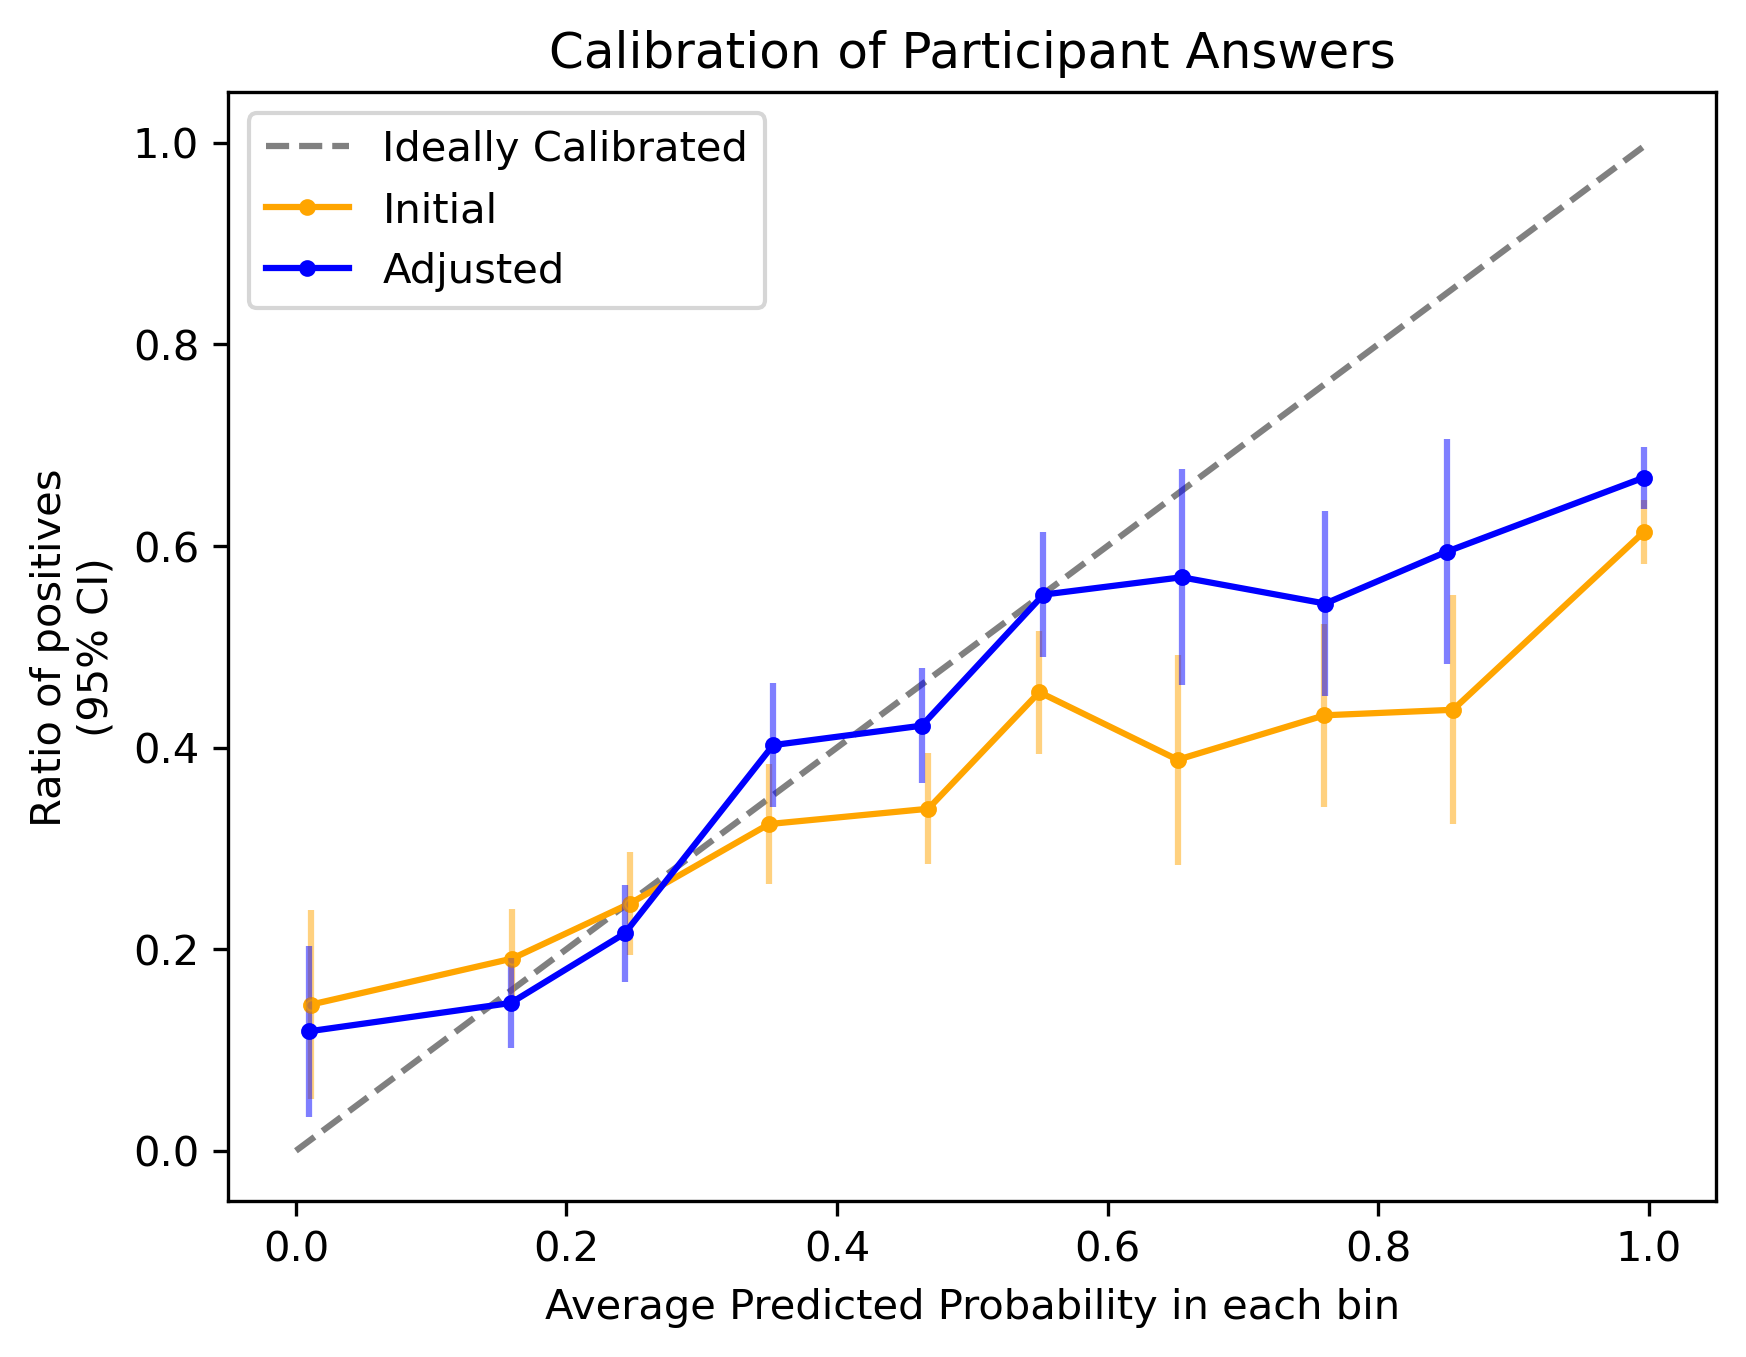

In [ ]:
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated', color="grey")

y_true = []
y_prob = []
question_df.apply(extract_confidence, answer_type='init', axis=1)

prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')

color = "orange"

# add error bars
prob_true_err = []
prob_pred_err = []
bucket_sizes = []
for i in range(len(prob_true)):
    bucket_size = len(question_df[(question_df['advice_confidence'] >= prob_pred[i]) & (question_df['advice_confidence'] < prob_pred[i] + 0.1)])
    prob_true_err.append(1.96*np.sqrt(prob_true[i] * (1 - prob_true[i]) / bucket_size))
    prob_pred_err.append(1.96*np.sqrt(prob_pred[i] * (1 - prob_pred[i]) / bucket_size))
    bucket_sizes.append(bucket_size)

# calculate ece
ece = 0
for i in range(len(prob_true)):
    ece += bucket_sizes[i] * np.abs(prob_true[i] - prob_pred[i])
ece /= len(question_df)
print(f"ECE initial: {ece}")

plt.plot(prob_pred, prob_true, marker = '.', color=color, label="Initial")
plt.errorbar(prob_pred, prob_true, yerr = prob_true_err, color = color, linestyle = '', marker = '.', alpha=.5)
y_true = []
y_prob = []
question_df.apply(extract_confidence, answer_type='adjusted', axis=1)

prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')

color = "blue"

# add error bars
prob_true_err = []
prob_pred_err = []
bucket_sizes = []
for i in range(len(prob_true)):
    bucket_size = len(question_df[(question_df['advice_confidence'] >= prob_pred[i]) & (question_df['advice_confidence'] < prob_pred[i] + 0.1)])
    prob_true_err.append(1.96*np.sqrt(prob_true[i] * (1 - prob_true[i]) / bucket_size))
    prob_pred_err.append(1.96*np.sqrt(prob_pred[i] * (1 - prob_pred[i]) / bucket_size))
    bucket_sizes.append(bucket_size)

# calculate ece
ece = 0
for i in range(len(prob_true)):
    ece += bucket_sizes[i] * np.abs(prob_true[i] - prob_pred[i])
ece /= len(question_df)
print(f"ECE adjusted: {ece}")

plt.plot(prob_pred, prob_true, marker = '.', color=color, label="Adjusted")
plt.errorbar(prob_pred, prob_true, yerr = prob_true_err, color = color, linestyle = '', marker = '.', alpha=.5)

plt.legend()

plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives\n(95% CI)')
plt.title("Calibration of Participant Answers")
plt.savefig('../figures/calibration_curve_participant.png')
plt.show()

Calibration curves on advice only.

ECE advice: 0.20051850429297674


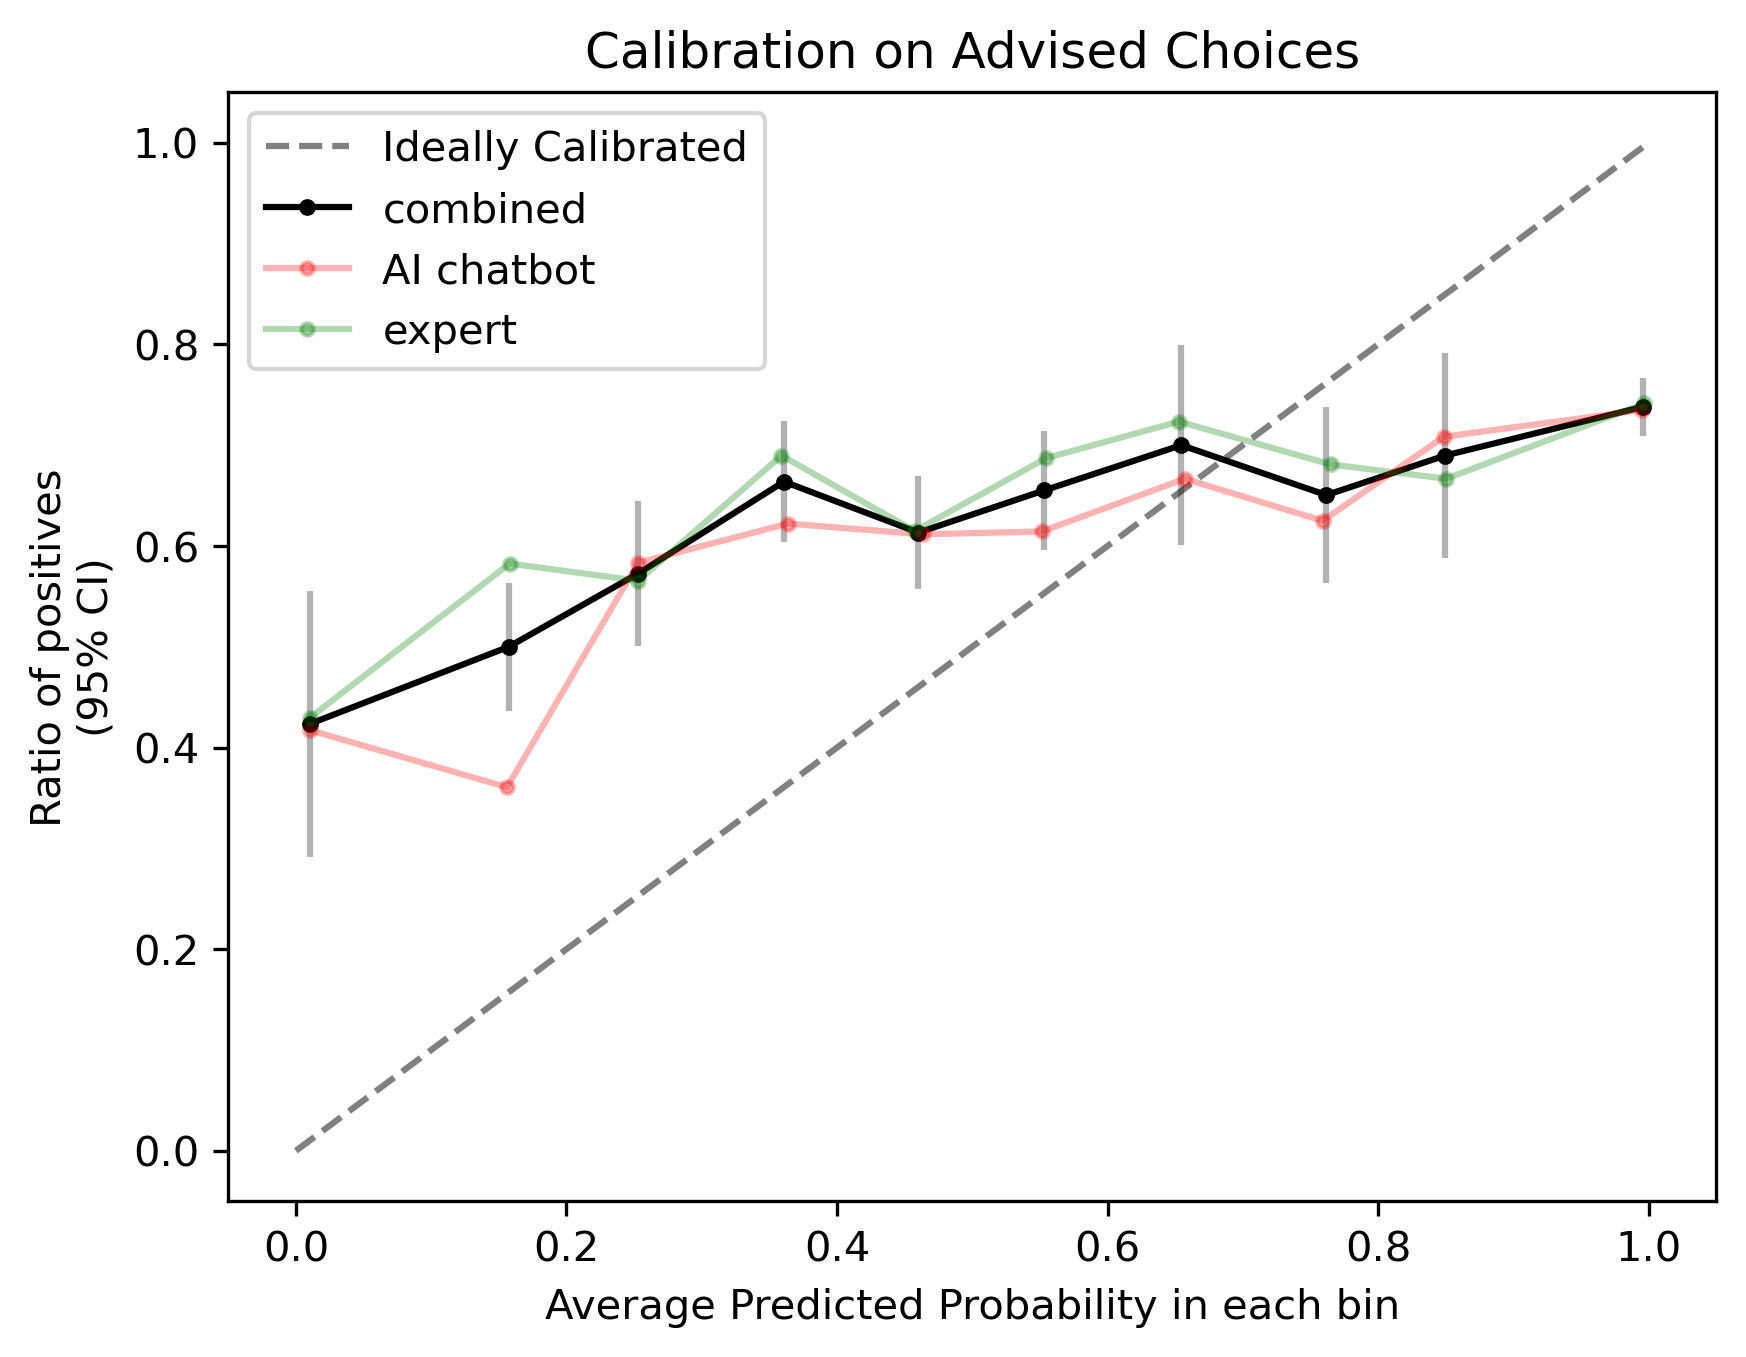

In [ ]:
y_true = question_df['advice_is_correct']
y_prob = question_df['advice_confidence']

plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated', color="grey")

prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')

color = "black"

# add error bars
prob_true_err = []
prob_pred_err = []
bucket_sizes = []
for i in range(len(prob_true)):
    bucket_size = len(question_df[(question_df['advice_confidence'] >= prob_pred[i]) & (question_df['advice_confidence'] < prob_pred[i] + 0.1)])
    prob_true_err.append(1.96*np.sqrt(prob_true[i] * (1 - prob_true[i]) / bucket_size))
    prob_pred_err.append(1.96*np.sqrt(prob_pred[i] * (1 - prob_pred[i]) / bucket_size))
    bucket_sizes.append(bucket_size)

# calcualte ece
ece = 0
for i in range(len(prob_true)):
    ece += bucket_sizes[i] * np.abs(prob_true[i] - prob_pred[i])
ece /= len(question_df)
print(f"ECE advice: {ece}")

plt.plot(prob_pred, prob_true, marker = '.', color=color, label='combined')
plt.errorbar(prob_pred, prob_true, yerr = prob_true_err, color = color, linestyle = '', marker = '.', alpha=0.3)

for advisor, color in zip(['AI chatbot', 'expert'], ['red', 'green']):
    sub_df = question_df[question_df['advisor'] == advisor]
    y_true = sub_df['advice_is_correct'].astype(float)
    y_prob = sub_df['advice_confidence']

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')

    # add error bars
    prob_true_err = []
    prob_pred_err = []
    for i in range(len(prob_true)):
        bucket_size = len(sub_df[(sub_df['advice_confidence'] >= prob_pred[i]) & (sub_df['advice_confidence'] < prob_pred[i] + 0.1)])
        prob_true_err.append(1.96*np.sqrt(prob_true[i] * (1 - prob_true[i]) / bucket_size))
        prob_pred_err.append(1.96*np.sqrt(prob_pred[i] * (1 - prob_pred[i]) / bucket_size))

    plt.plot(prob_pred, prob_true, marker = '.', color=color, label = advisor, alpha = 0.3)

plt.legend()
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives\n(95% CI)')
plt.title("Calibration on Advised Choices")
plt.savefig('../figures/calibration_curve_advice.png')
plt.show()

Actual correctness for the 0% to 10% bucket of confidence.

In [ ]:
high = prob_true[0] + prob_true_err[0]
low = prob_true[0] - prob_true_err[0]
print(f"{prob_true[0]:.1%} 95% CI: [{low:.1%}, {high:.1%}]")
# calculate expected calibration error
print(np.average(np.abs(prob_true - prob_pred), weights=bucket_sizes))

42.9% 95% CI: [24.6%, 61.3%]
0.2465286652112468


Estimate ECE for each question group and bootstrap a confidence interval.

In [ ]:
def calculate_ece(df):
    prob_true, prob_pred = calibration_curve(df['advice_is_correct'].astype(float), df['advice_confidence'], n_bins=10, strategy='uniform')
    bucket_sizes = []
    for i in range(len(prob_true)):
        bucket_size = len(df[(df['advice_confidence'] >= prob_pred[i]) & (df['advice_confidence'] < prob_pred[i] + 0.1)])
        bucket_sizes.append(bucket_size)
    return np.average(np.abs(prob_true - prob_pred), weights=bucket_sizes)

RESAMPLES = 1000
CI = 0.95

# calculate ece by question group
ece_data = []
for question_group, group_df in question_df.groupby('question_group'):
    ece_obs = {'question_group':question_group}
    ece_obs['ece'] = calculate_ece(group_df)

    # bootstrap 95% confidence interval
    estimates = []
    for i in range(RESAMPLES):
        sample = group_df.sample(frac=1, replace=True)
        estimates.append(calculate_ece(sample))
    estimates = np.array(estimates)
    ece_obs['ece_ci'] = (np.quantile(estimates, (1-CI)/2), np.quantile(estimates, CI + (1-CI)/2))
    ece_data.append(ece_obs)

ece_df = pd.DataFrame(ece_data)

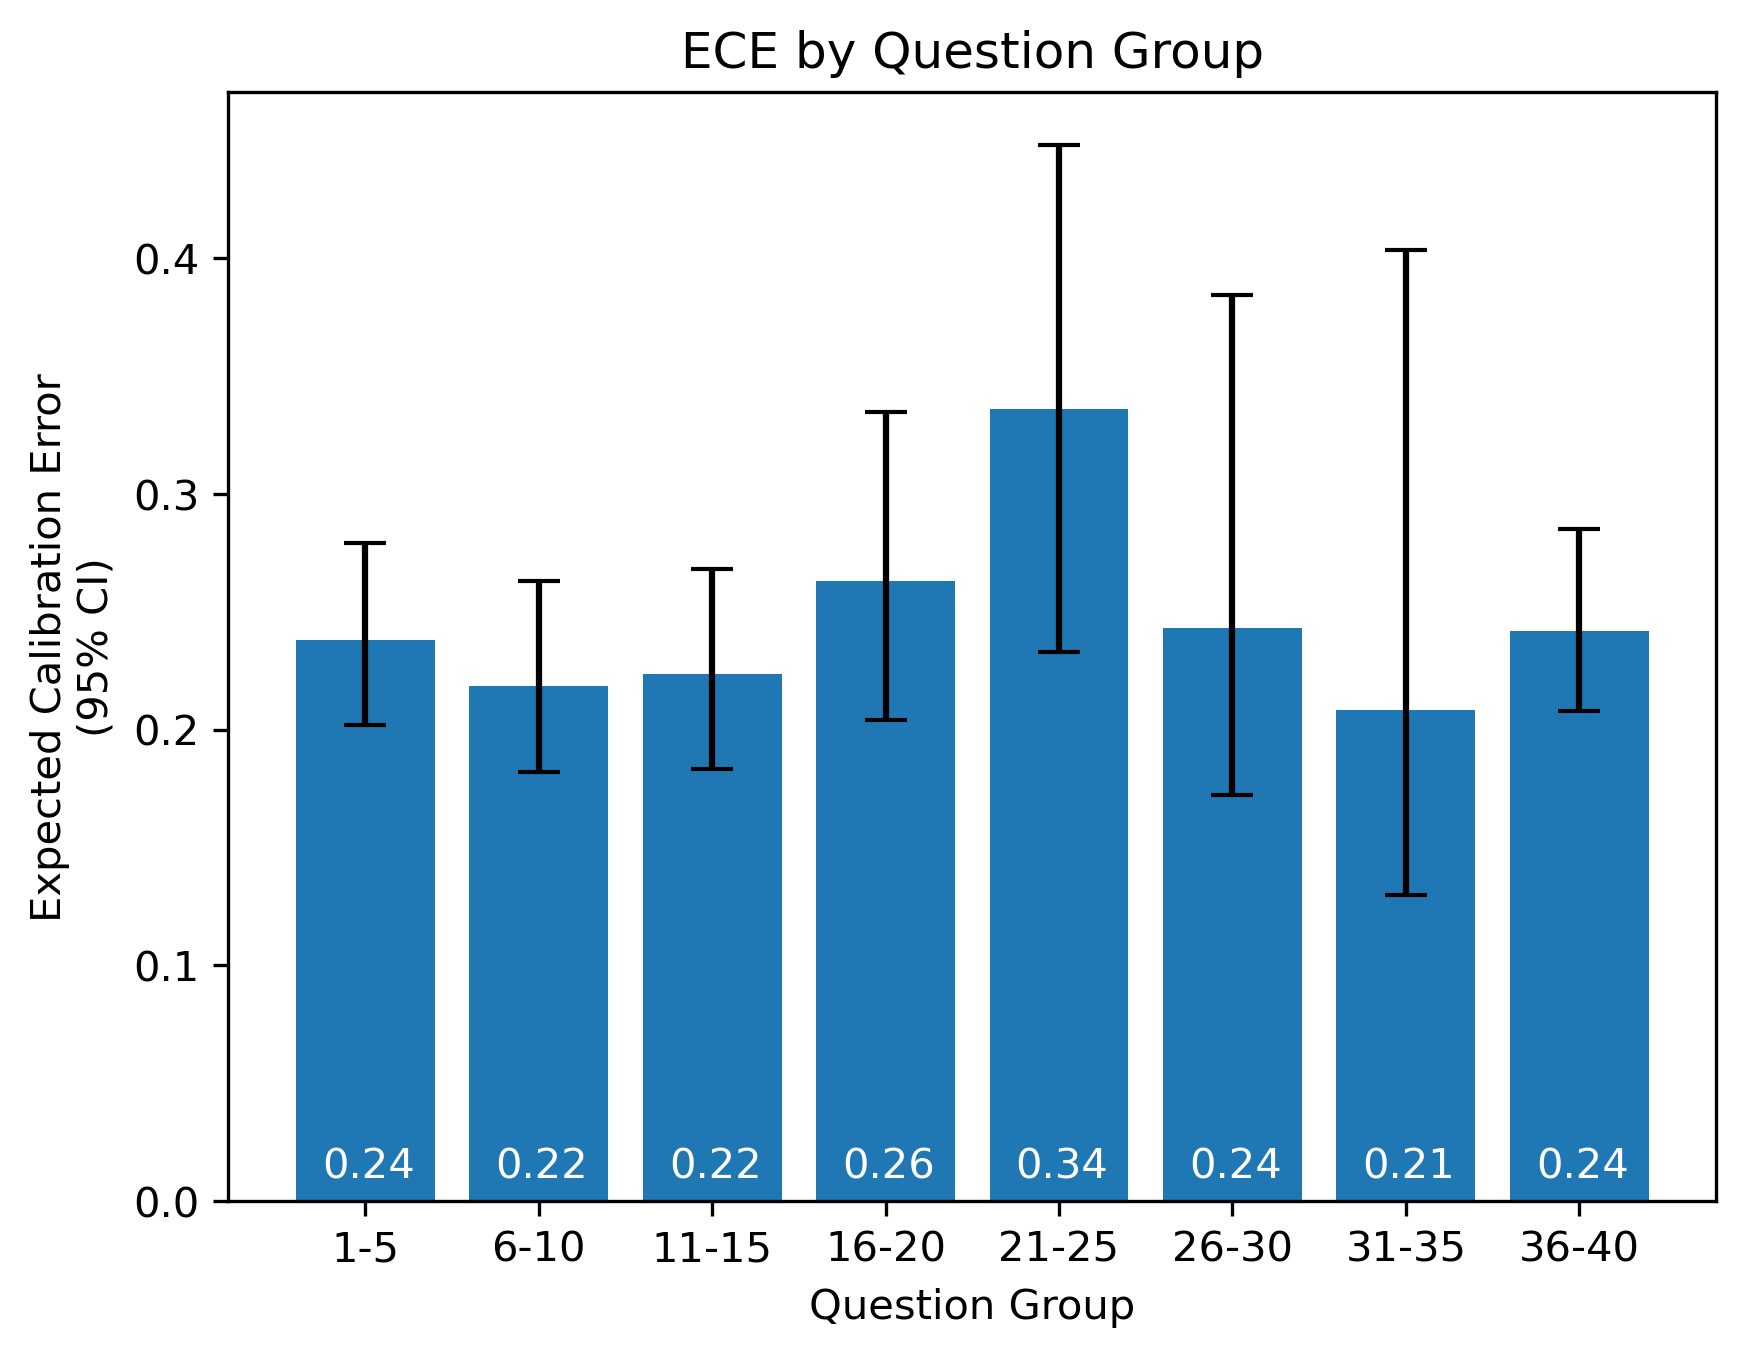

In [ ]:
# plot barplot
plt.bar([f'{i}-{i+4}' for i in range(1, 41, 5)],
        ece_df['ece'],
        yerr=[ece_df['ece'] - ece_df['ece_ci'].apply(lambda x: x[0]),
              ece_df['ece_ci'].apply(lambda x: x[1]) - ece_df['ece']],
              capsize=5,
        ecolor='black')
plt.xlabel('Question Group')
plt.ylabel('Expected Calibration Error\n(95% CI)')
plt.title('ECE by Question Group')
# add data labels
for i, v in enumerate(ece_df['ece']):
    plt.text(i - 0.25, 0.01, f"{v:.2f}", color='white')
plt.savefig('../figures/ece_by_question_group.png')

From here on, use just `chatbot_df`, which are responses for people told it is ChatGPT. Analysis by topic.

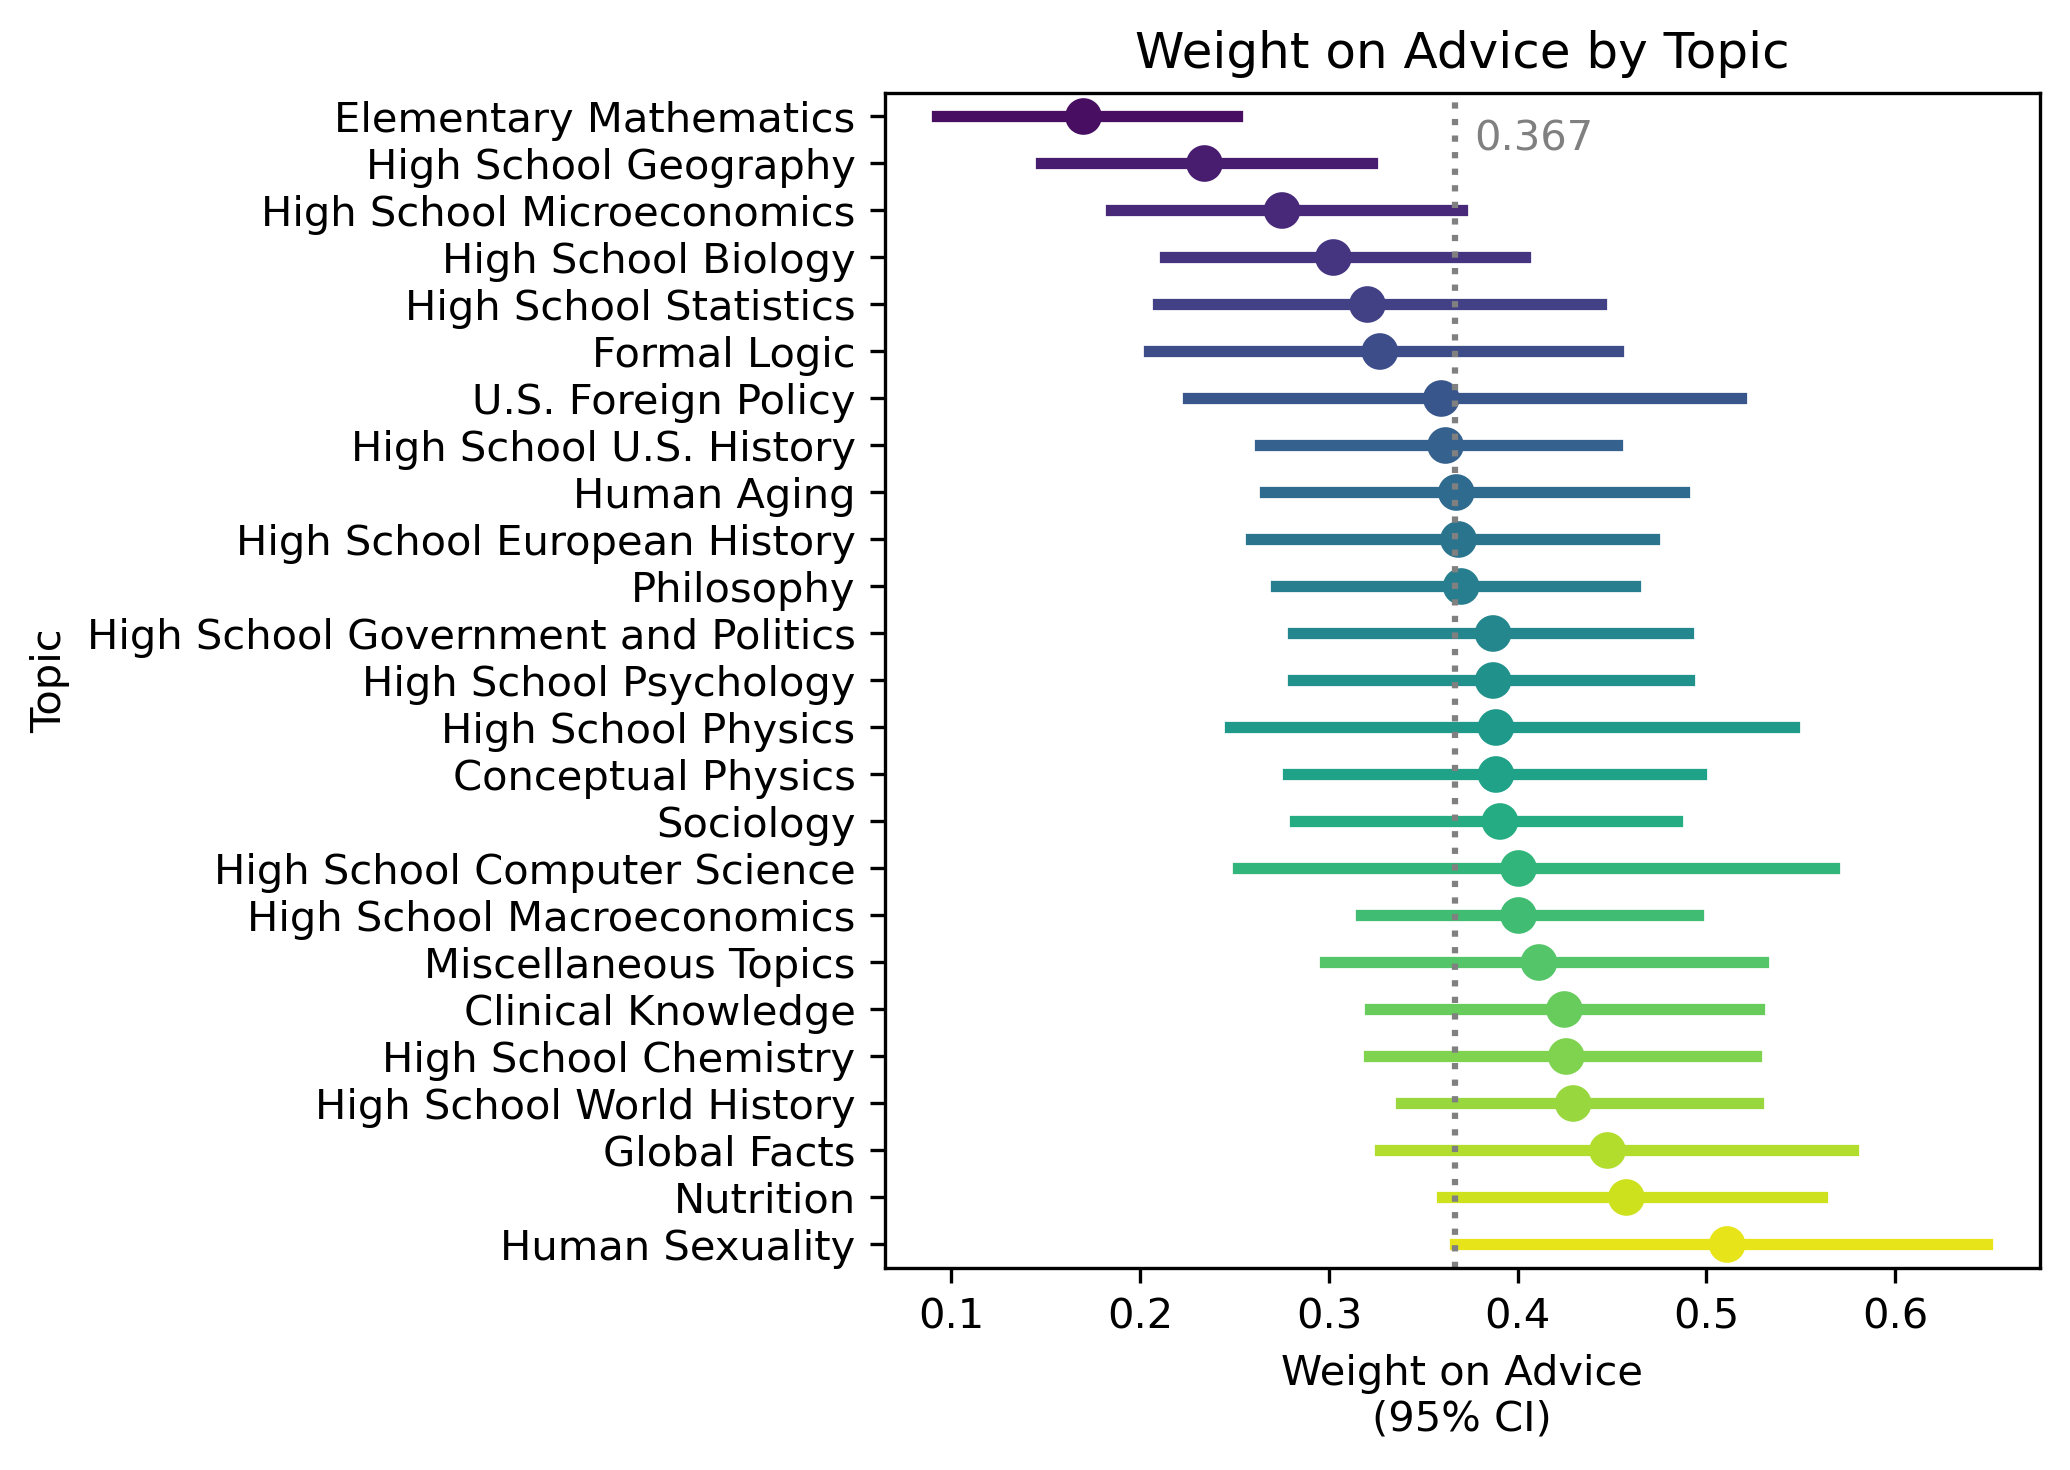

In [ ]:
chatbot_df = question_df[question_df['advisor'] == 'AI chatbot']

plt.figure(figsize=(7, 5))
 # list of topics by mean weight on advice
sorted_topics = chatbot_df.groupby('topic')['weight_on_advice'].mean().sort_values().index
# color by woa
ax = sns.pointplot(data=chatbot_df, x="weight_on_advice", y="topic", join=False, seed=0, orient='h', order = sorted_topics, errorbar=('ci',95), palette='viridis')
topic_labels = list(map(lambda t: config.topic2display[t._text], ax.get_yticklabels()))
ax.set_yticklabels(topic_labels)


average_woa = chatbot_df['weight_on_advice'].mean()
plt.axvline(average_woa, color='grey', linestyle='dotted', label='Average Weight on Advice')

plt.text(average_woa + 0.01, 0.5, str(round(average_woa, 3)), color='grey', verticalalignment='center')

plt.xlabel('Weight on Advice\n(95% CI)')
plt.ylabel('Topic')
plt.title('Weight on Advice by Topic')
plt.tight_layout()
plt.savefig("../figures/woa_by_topic.png")
plt.show()

In [ ]:
chatbot_df['supercategory'] = chatbot_df['topic'].apply(config.topic2category.get)

/var/folders/xd/l62jq5mx63qdtc0pktr47qrh0000gn/T/ipykernel_60516/4171539101.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chatbot_df['supercategory'] = chatbot_df['topic'].apply(config.topic2category.get)


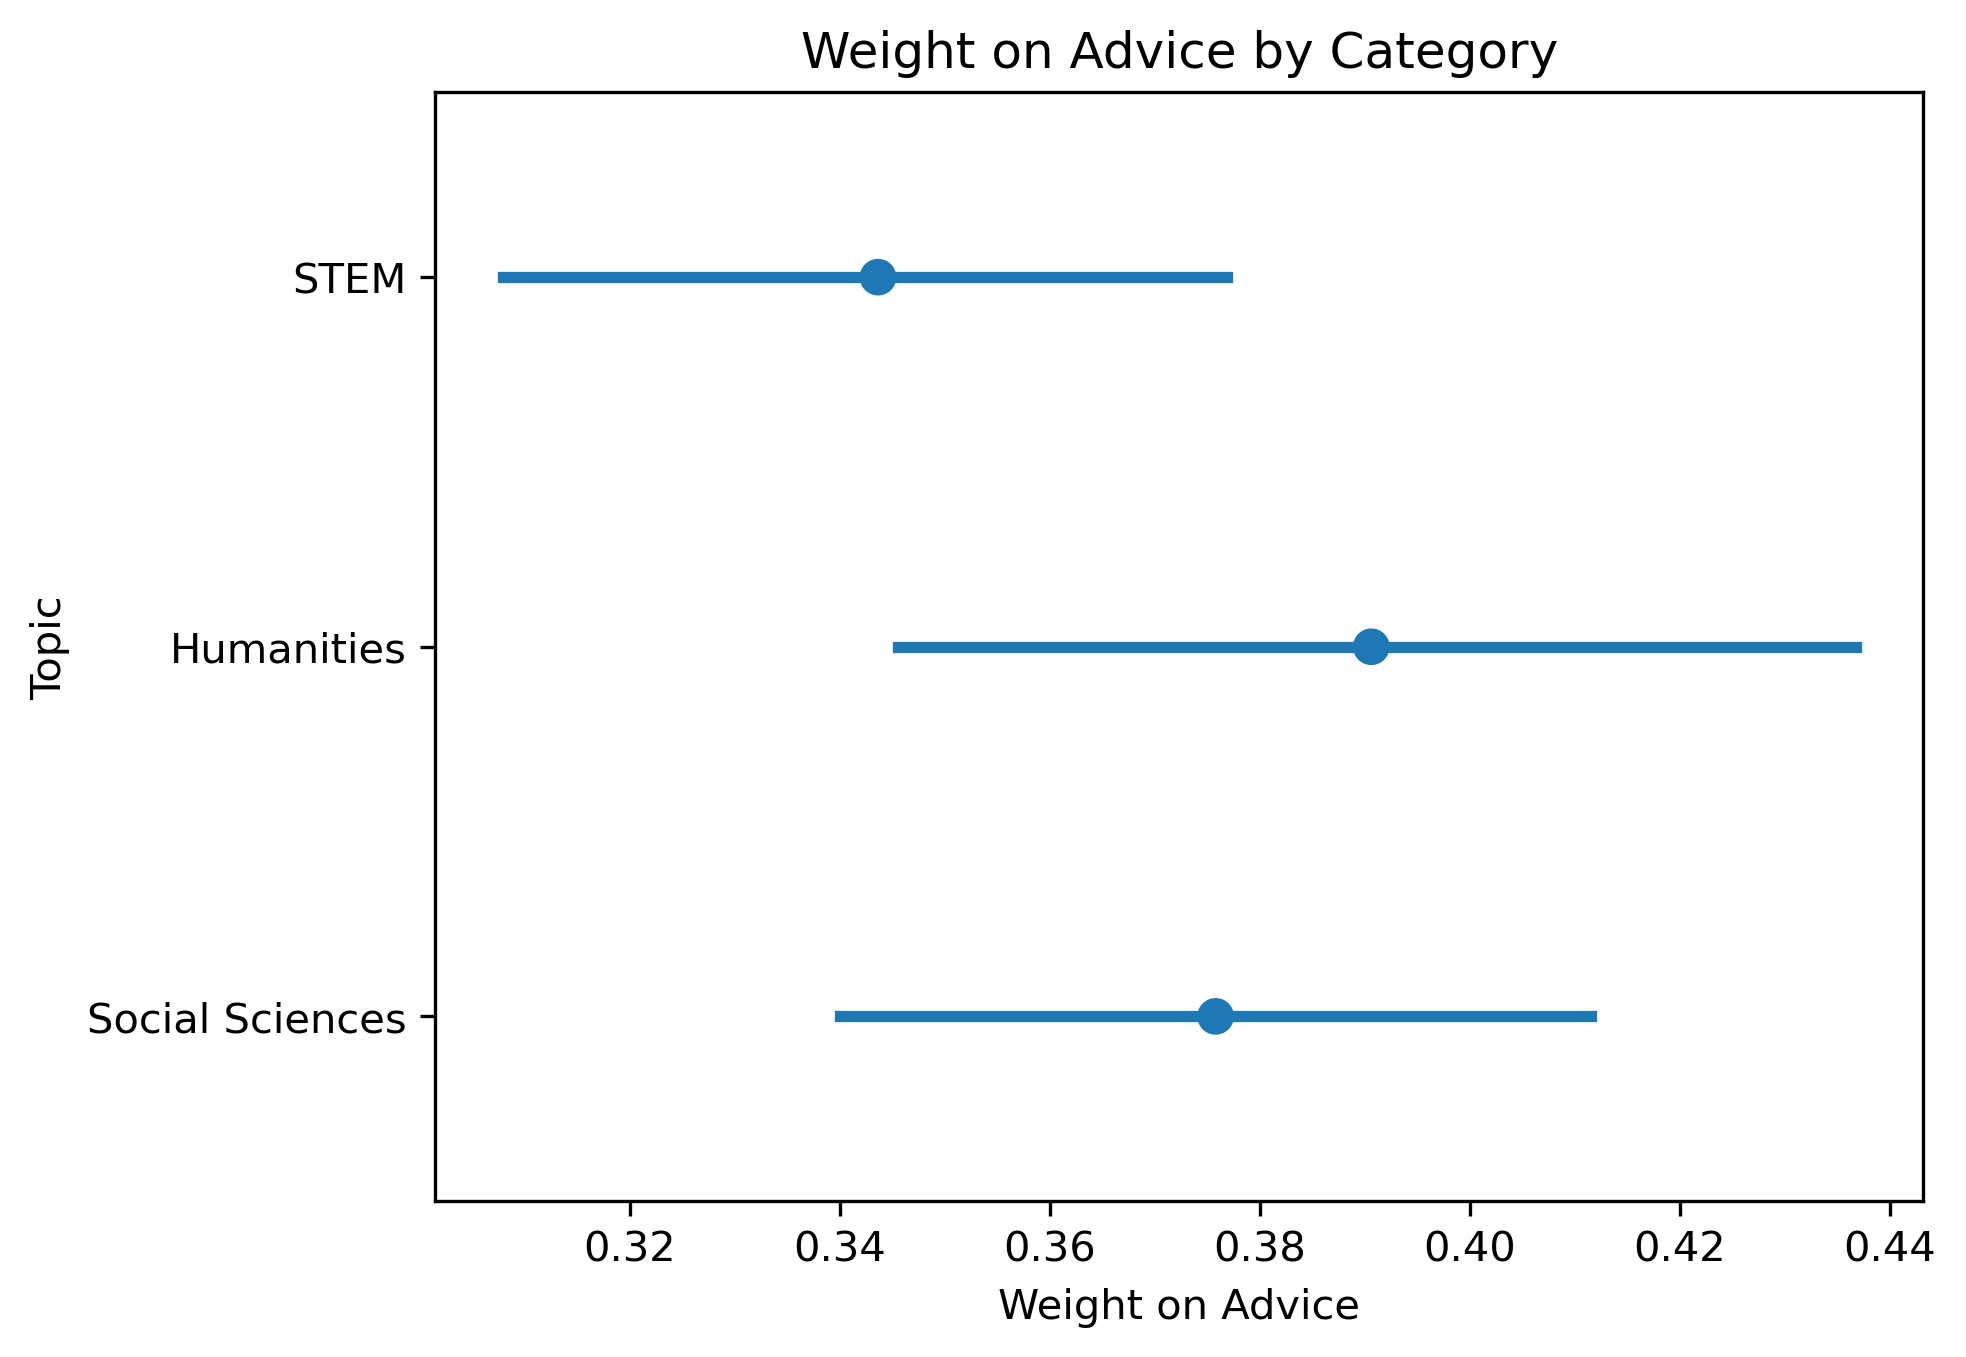

In [ ]:
ax = sns.pointplot(data=chatbot_df, x="weight_on_advice", y="supercategory", join=False, seed=0, orient='h', errorbar=('ci',95))
topic_labels = list(map(lambda t: config.category2display[t._text], ax.get_yticklabels()))
ax.set_yticklabels(topic_labels)
plt.xlabel('Weight on Advice')
plt.ylabel('Topic')
plt.title('Weight on Advice by Category')
plt.show()

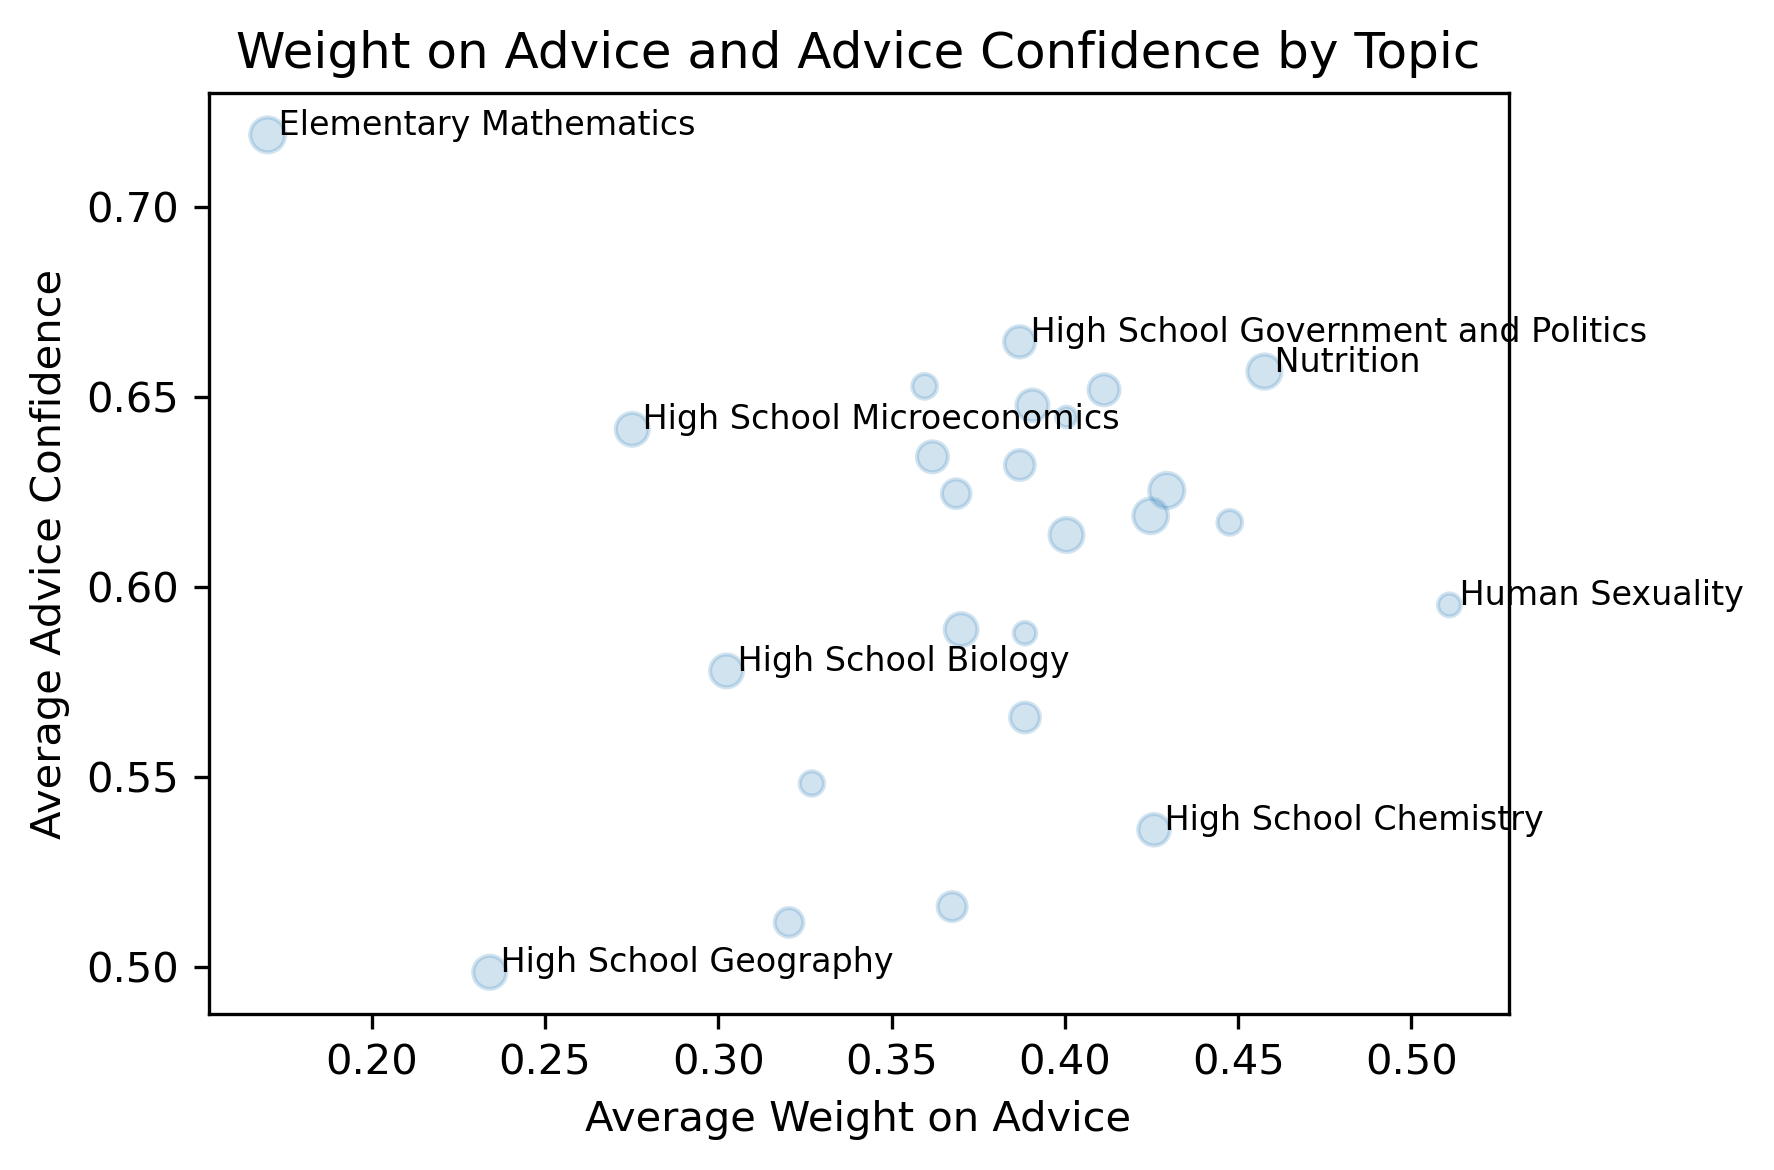

In [ ]:
plt.figure(figsize=(6, 4))
woa_and_correctness_df = chatbot_df.groupby('topic')[['weight_on_advice', 'advice_confidence']].agg(['mean','count'])
# scatterplot
plt.scatter(woa_and_correctness_df['weight_on_advice']['mean'],
            woa_and_correctness_df['advice_confidence']['mean'],
            s=woa_and_correctness_df['advice_confidence']['count'], 
            alpha=.2)
# annotate
keep_topics = ['elementary_mathematics','high_school_microeconomics','high_school_geography','human_sexuality','nutrition','high_school_government_and_politics', 'high_school_chemistry', 'high_school_biology']

for i, topic in enumerate(woa_and_correctness_df.index):
    if topic not in keep_topics:
        continue
    x = woa_and_correctness_df['weight_on_advice']['mean'][i]
    y = woa_and_correctness_df['advice_confidence']['mean'][i]
    display_text = " " + config.topic2display[topic]
    plt.annotate(display_text, (x, y), fontsize=8)

plt.xlabel('Average Weight on Advice')
plt.ylabel('Average Advice Confidence')
plt.title('Weight on Advice and Advice Confidence by Topic')
plt.tight_layout()
plt.savefig('../figures/woa_and_correctness.png')
plt.show()

Correlation between weight on advice and advice confidence.

In [ ]:
pearsonr(chatbot_df['weight_on_advice'], chatbot_df['advice_confidence'])

(0.6389001129370883, 1.6893166747104265e-150)

In [ ]:
model_result_df = pd.read_csv('../data/model_output/results_0425.csv')
model_result_df = model_result_df[model_result_df['topic'].isin(config.topics)]
model_result_df['answer_correct'] = model_result_df['answer'] == model_result_df['correct_answer']

In [ ]:
# conduct t-tests by topic
topic2significance = {}
all_correctness, all_beliefs = [], []
for topic in config.topics:
    correctness = model_result_df[model_result_df['topic'] == topic]['answer_correct']
    beliefs = chatbot_df[chatbot_df['topic'] == topic]['advice_confidence']
    t, p = brunnermunzel(correctness, beliefs)
    topic2significance[topic] = p
    all_correctness.append(correctness.mean())
    all_beliefs.append(beliefs.mean())

# FDR correction
rejections = fdrcorrection(list(topic2significance.values()))
topic2reject = dict(zip(topic2significance.keys(), rejections[0]))
pearsonr(all_correctness, all_beliefs)

(0.33922364858631343, 0.09713771625082952)

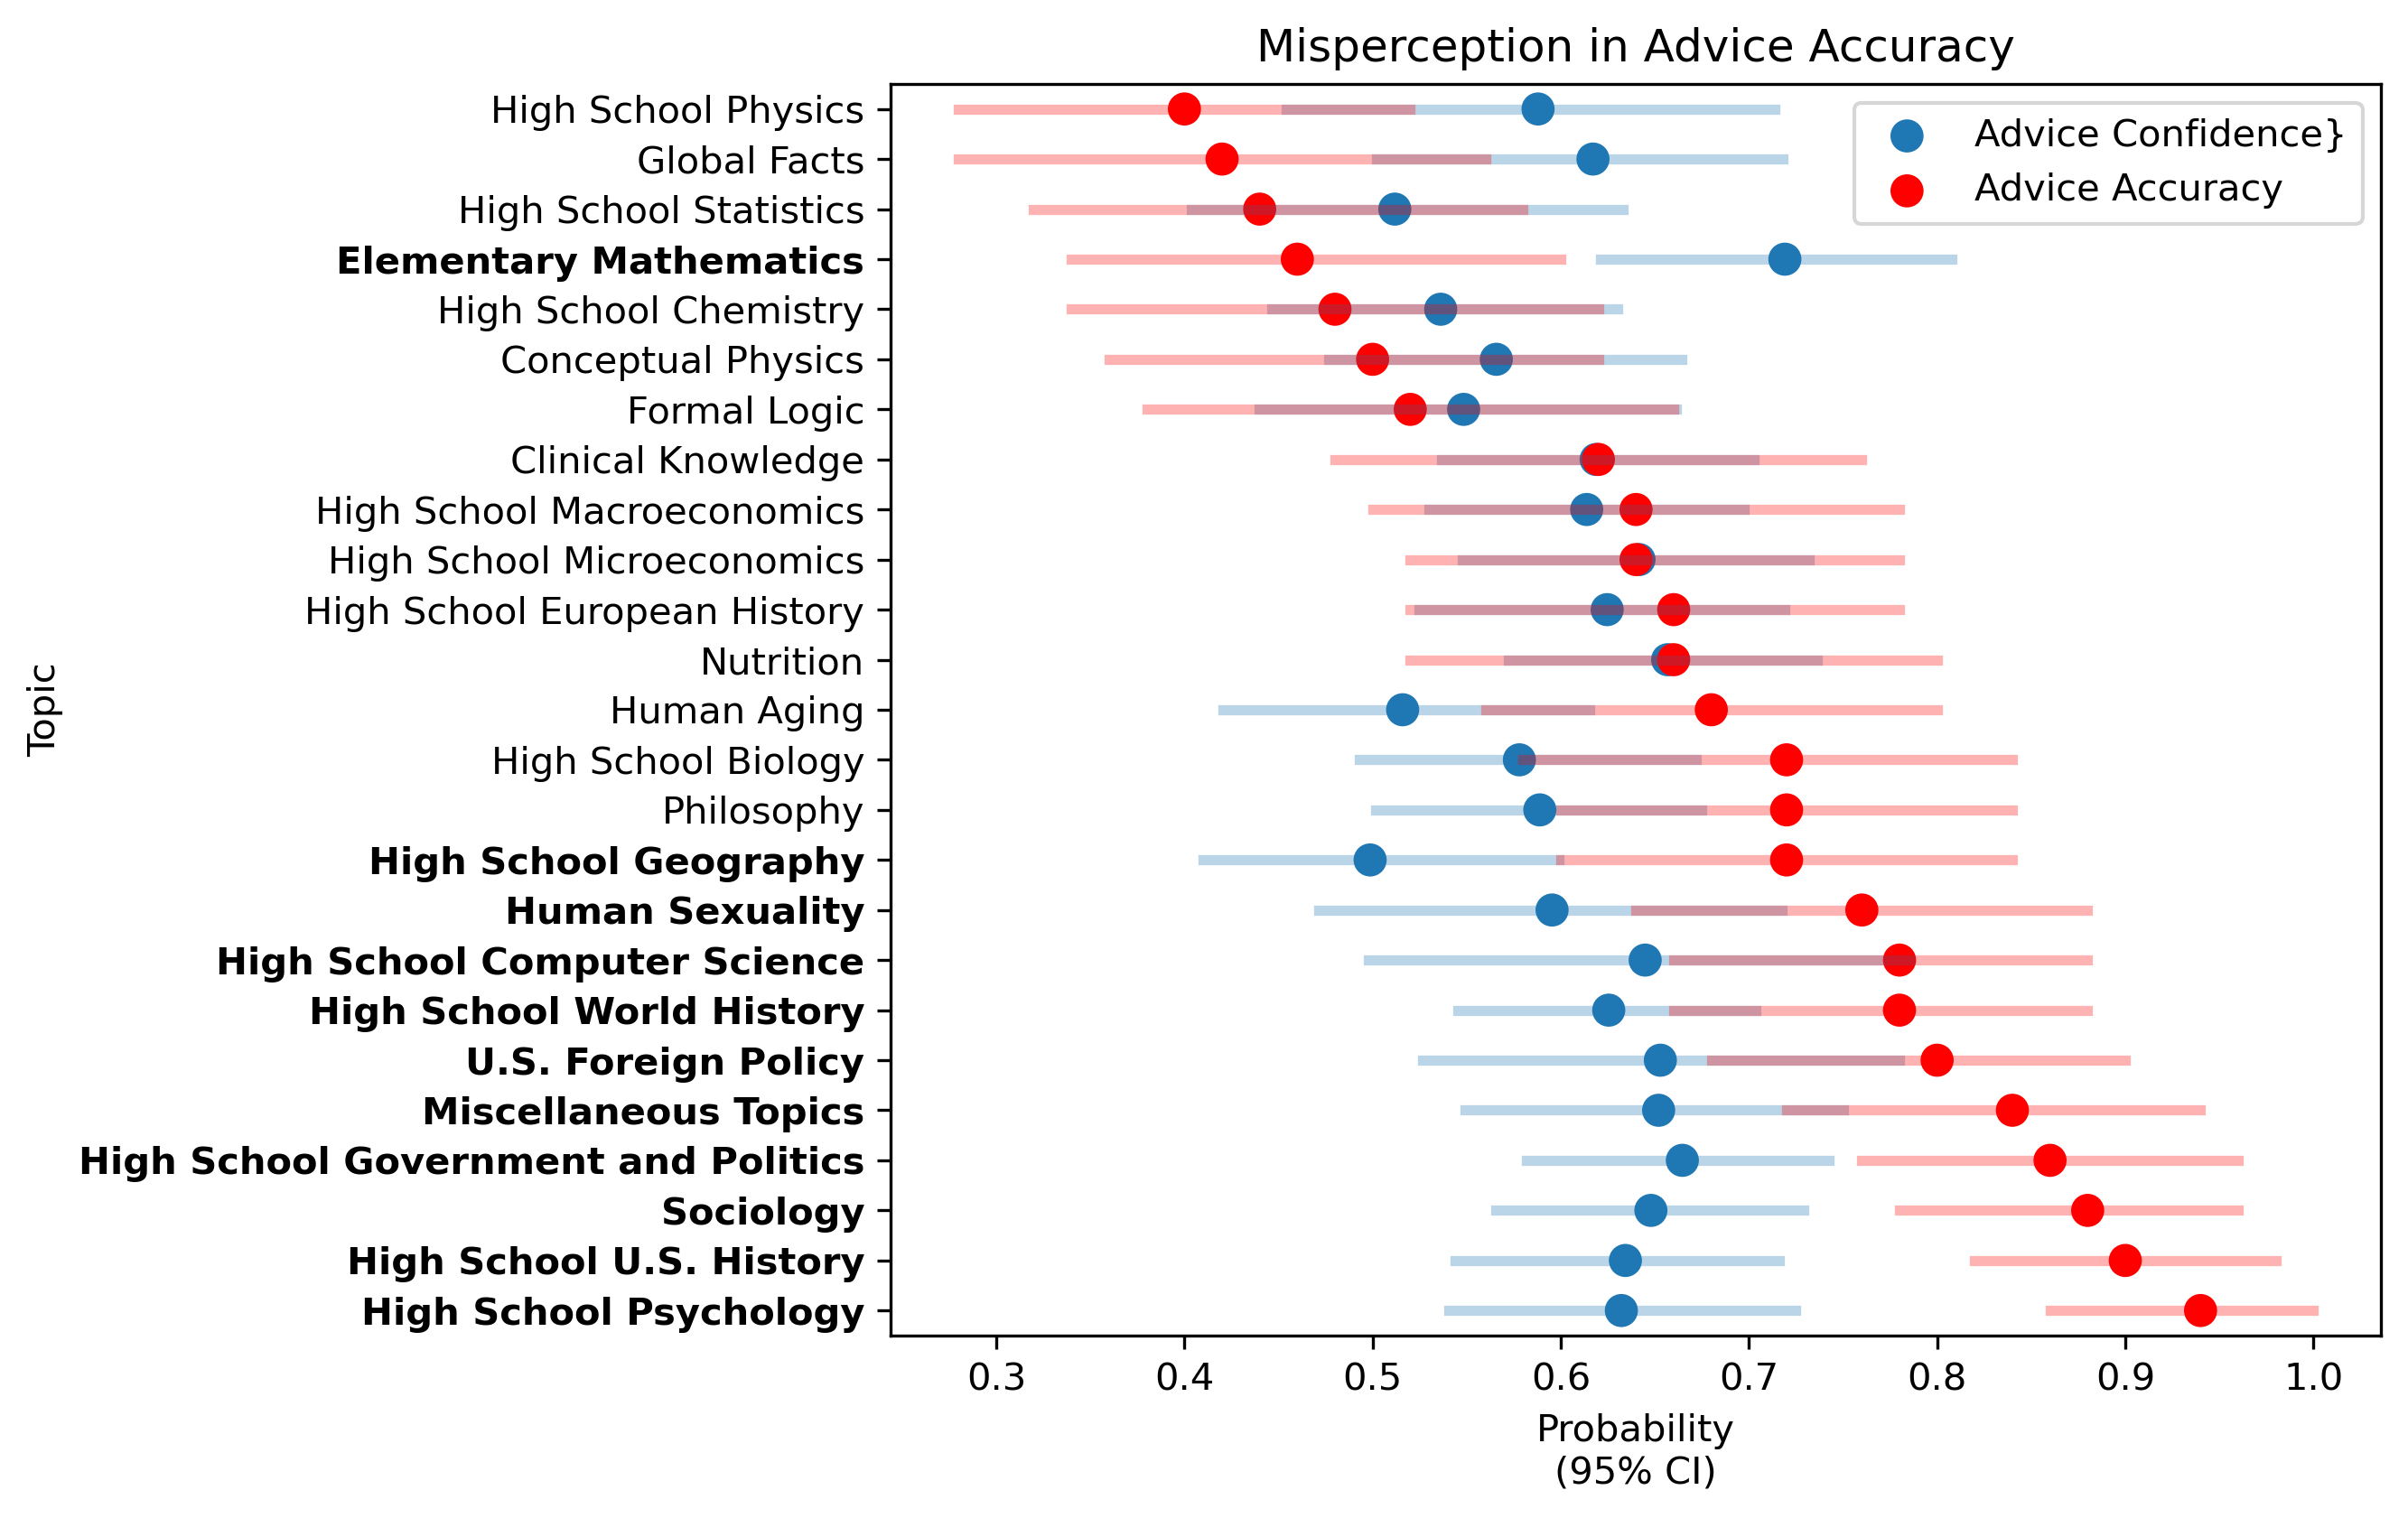

In [ ]:
SIG_LEVEL = 0.05
plt.figure(figsize=(10, 6))
sorted_topics = model_result_df.groupby('topic')['answer_correct'].mean().sort_values().index
ax1 = sns.pointplot(data=chatbot_df, x="advice_confidence", y="topic", label='Advice Confidence}', errorbar=('ci', 95), join=False, orient='h', order = sorted_topics)
ax2 = sns.pointplot(data=model_result_df, x="answer_correct", y="topic", label='Advice Accuracy', color='red', errorbar=('ci', 95), join=False, orient='h', order = sorted_topics)
topic_labels = list(map(lambda t: config.topic2display[t._text], ax1.get_yticklabels()))

ax1.set_yticklabels(topic_labels)

display2topic = {v:k for k,v in config.topic2display.items()}

for tick in ax1.get_yticklabels():
    topic = display2topic[tick._text]
    if topic2reject[topic]:
        tick.set_fontweight('bold')
    else:
        tick.set_fontweight('normal')

for line in ax1.lines:
    line.set_alpha(0.3)
for line in ax2.lines:
    line.set_alpha(0.3)

plt.subplots_adjust(left=0.35)
plt.xlabel('Probability\n(95% CI)')
plt.ylabel(f"Topic")
plt.title('Misperception in Advice Accuracy')
plt.legend()

# set sigdif topics to be bold
ax = plt.gca()
plt.savefig('../figures/misperception_in_advice_accuracy.png')

plt.show()

Calculating optimal weight on advice.

In [ ]:
def brier_score(row: pd.Series, type: str) -> float:
    """Calculate the Brier score for a single row."""
    assert type in ['init', 'adjusted', 'simulated']
    return sum((row[f"{type}_choice{letter_choice}"] - int(letter_choice == row['correct_answer'])) ** 2 for letter_choice in "ABCD")

In [ ]:
def take_advice(row: pd.Series, weight_on_advice_logg: float):
    """Simulate taking advice from the AI chatbot."""
    assert 0 <= weight_on_advice_logg <= 1
    
    simulated_choices = []
    advice_choice = row[f"advice_answer"]

    if advice_choice not in "ABCD":
        return pd.Series(list(row[[f"init_choice{letter_choice}" for letter_choice in "ABCD"]]))

    advice_gap = 1 - row[f"init_choice{advice_choice}"]
    scale_factor = advice_gap * weight_on_advice_logg
    
    for letter_choice in "ABCD":
        weight = row[f"init_choice{letter_choice}"] * (1 - scale_factor)
        if letter_choice == advice_choice:
            weight += scale_factor
        simulated_choices.append(weight)

    return pd.Series(simulated_choices)

In [ ]:
WOAs = np.linspace(0, 1, 101)
brier_scores = []
for woa in tqdm(WOAs):
    simulated_df = chatbot_df.apply(take_advice, weight_on_advice_logg=woa, axis=1)
    simulated_df.columns = [f"simulated_choice{letter_choice}" for letter_choice in "ABCD"]
    chatbot_df[simulated_df.columns] = simulated_df
    chatbot_df['simulated_answer'] =  chatbot_df.apply(pick_answer, axis=1, type='simulated')
    chatbot_df['simulated_answer_correct'] = chatbot_df['simulated_answer'] == chatbot_df['correct_answer']
    chatbot_df['simulated_brier_score'] = chatbot_df.apply(brier_score, type='simulated', axis=1)
    brier_scores.append(chatbot_df['simulated_brier_score'].mean())

  0%|          | 0/101 [00:00<?, ?it/s]/var/folders/xd/l62jq5mx63qdtc0pktr47qrh0000gn/T/ipykernel_29451/2106658627.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chatbot_df[simulated_df.columns] = simulated_df
/var/folders/xd/l62jq5mx63qdtc0pktr47qrh0000gn/T/ipykernel_29451/2106658627.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chatbot_df[simulated_df.columns] = simulated_df
/var/folders/xd/l62jq5mx63qdtc0pktr47qrh0000gn/T/ipykernel_29451/2106658627.py:6: SettingWithCopyWarning: 
A value is try

In [ ]:
# adjusted brier score
chatbot_df['adjusted_brier_score'] = chatbot_df.apply(brier_score, type='adjusted', axis=1)
average_bs = chatbot_df['adjusted_brier_score'].mean()

/var/folders/xd/l62jq5mx63qdtc0pktr47qrh0000gn/T/ipykernel_29451/2456146870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chatbot_df['adjusted_brier_score'] = chatbot_df.apply(brier_score, type='adjusted', axis=1)


In [ ]:
optimal_woa = WOAs[np.argmin(brier_scores)]
print(f"Optimal WOA: {optimal_woa:.3f}\nOptiaml Brier score: {min(brier_scores):.3f}")
average_woa = chatbot_df['weight_on_advice'].mean()
print(f"Average WOA: {average_woa:.3f}\nAverage Brier score: {average_bs:.3f}")

Optimal WOA: 0.610
Optiaml Brier score: 0.556
Average WOA: 0.367
Average Brier score: 0.673


In [ ]:
# closest woa to average woa
closest_index = np.argmin(np.abs(WOAs - average_woa))
closest_woa = WOAs[closest_index]
print(f"Closest WOA to average WOA: {closest_woa:.3f}, Brier score: {brier_scores[closest_index]:.3f}")

Closest WOA to average WOA: 0.370, Brier score: 0.588


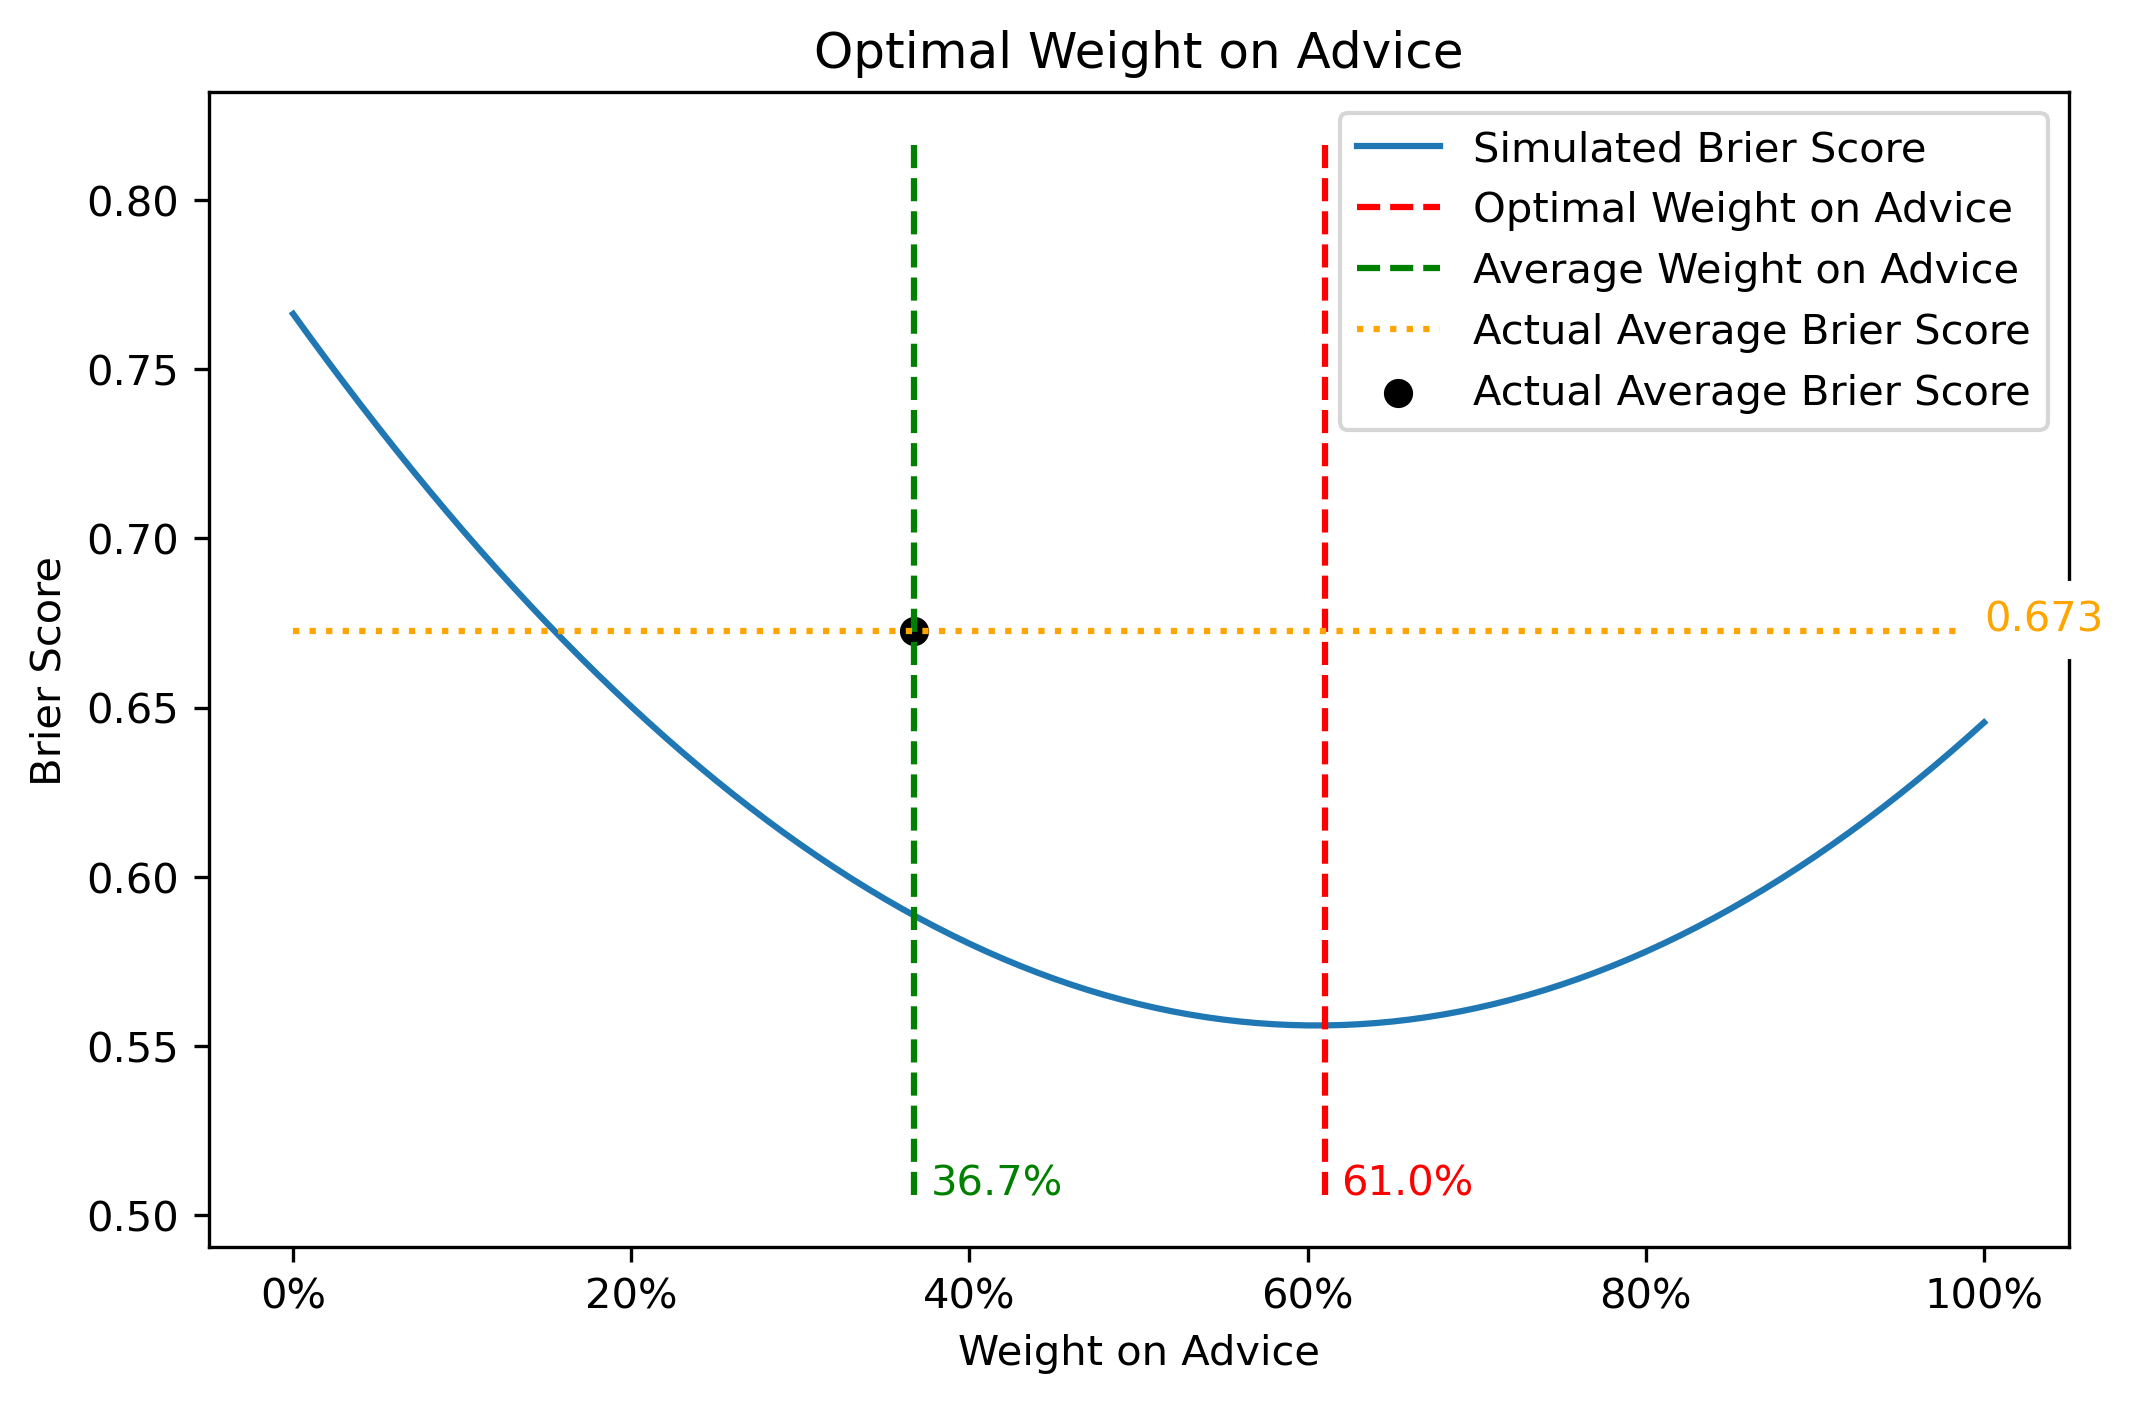

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(WOAs, brier_scores, label='Simulated Brier Score')
plt.xlabel('Weight on Advice')
plt.ylabel('Brier Score')
plt.vlines(optimal_woa, min(brier_scores) - .05, max(brier_scores) + .05, linestyles='dashed', colors='red', label='Optimal Weight on Advice')
plt.annotate(f"{optimal_woa:.1%}", (optimal_woa + .01, min(brier_scores) - .05), fontsize=10, color='red')
plt.vlines(average_woa, min(brier_scores) - .05, max(brier_scores) + .05, linestyles='dashed', colors='green', label='Average Weight on Advice')
plt.annotate(f"{average_woa:.1%}", (average_woa + .01, min(brier_scores) - .05), fontsize=10, color='green')
plt.hlines(average_bs, 0, max(WOAs), linestyles='dotted', colors='orange', label='Actual Average Brier Score')
plt.annotate(f"{average_bs:.3f}", (max(WOAs), average_bs), fontsize=10, color='orange', backgroundcolor='white')
plt.scatter(x=[average_woa], y=[average_bs], color='black', label='Actual Average Brier Score')
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.title('Optimal Weight on Advice')
plt.legend()
plt.savefig('../figures/woa_brier_score.png')
plt.show()

In [ ]:
sim_df = chatbot_df.copy()
def sim_proportionate(row):
    new_row = row.copy()
    advice_answer = row['advice_answer']
    if advice_answer not in "ABCD":
        return new_row

    abs_change = (1 - row[f"init_choice{advice_answer}"]) * row['weight_on_advice']
    
    new_row['simulated_choiceA'] = row['init_choiceA'] * (1 - abs_change)
    new_row['simulated_choiceB'] = row['init_choiceB'] * (1 - abs_change)
    new_row['simulated_choiceC'] = row['init_choiceC'] * (1 - abs_change)
    new_row['simulated_choiceD'] = row['init_choiceD'] * (1 - abs_change)
    new_row[f"simulated_choice{row['advice_answer']}"] += abs_change
    return new_row
sim_df = sim_df.apply(sim_proportionate, axis=1)
sim_df['brier_score'] = sim_df.apply(brier_score, type='simulated', axis=1)
sim_df['brier_score'].mean()

0.6367172922296083

In [ ]:
avg_woa = chatbot_df['weight_on_advice'].mean()
sim_df = chatbot_df.copy()
def sim_depolarize(row, scale=.5):
    """
    Simulate a shrinking of the weight on advice towards average but
    proportionately maintaining other adjusted answers.
    """
    new_row = row.copy()

    advice_answer = row['advice_answer'] 
    if advice_answer not in "ABCD":
        for letter in "ABCD":
            new_row[f"simulated_choice{letter}"] = row[f"init_choice{letter}"]
        return new_row

    advice_weight = row[f"adjusted_choice{advice_answer}"]
    woa = row['weight_on_advice'] * (1 - row[f"init_choice{advice_answer}"])
    new_woa = avg_woa * (1 - scale) + woa * scale
    new_row['weight_on_advice'] = new_woa
    new_advice_weight = new_woa + row[f"init_choice{advice_answer}"]

    if advice_weight != 1:
        for letter in "ABCD":
            new_row[f"simulated_choice{letter}"] = row[f"adjusted_choice{letter}"]  / (1-advice_weight) * (1-new_advice_weight)
    else:
        for letter in "ABCD":
            new_row[f"simulated_choice{letter}"] = (1-new_advice_weight) / 3
    new_row[f"simulated_choice{advice_answer}"] = new_advice_weight

    return new_row

In [ ]:
Ss = np.linspace(0, 1, 101)
brier_scores = []
for s in tqdm(Ss):
    sim_df = sim_df.apply(sim_depolarize, axis=1, scale=s)
    sim_df['brier_score'] = sim_df.apply(brier_score, type='simulated', axis=1)
    bs = sim_df['brier_score'].mean()
    brier_scores.append(bs)

100%|██████████| 101/101 [00:17<00:00,  5.84it/s]


In [ ]:
# calculate optimal s
optimal_s = Ss[np.argmin(brier_scores)]
print(f"Optimal s: {optimal_s:.3f}\nOptiaml Brier score: {min(brier_scores):.3f}")

Optimal s: 0.620
Optiaml Brier score: 0.578


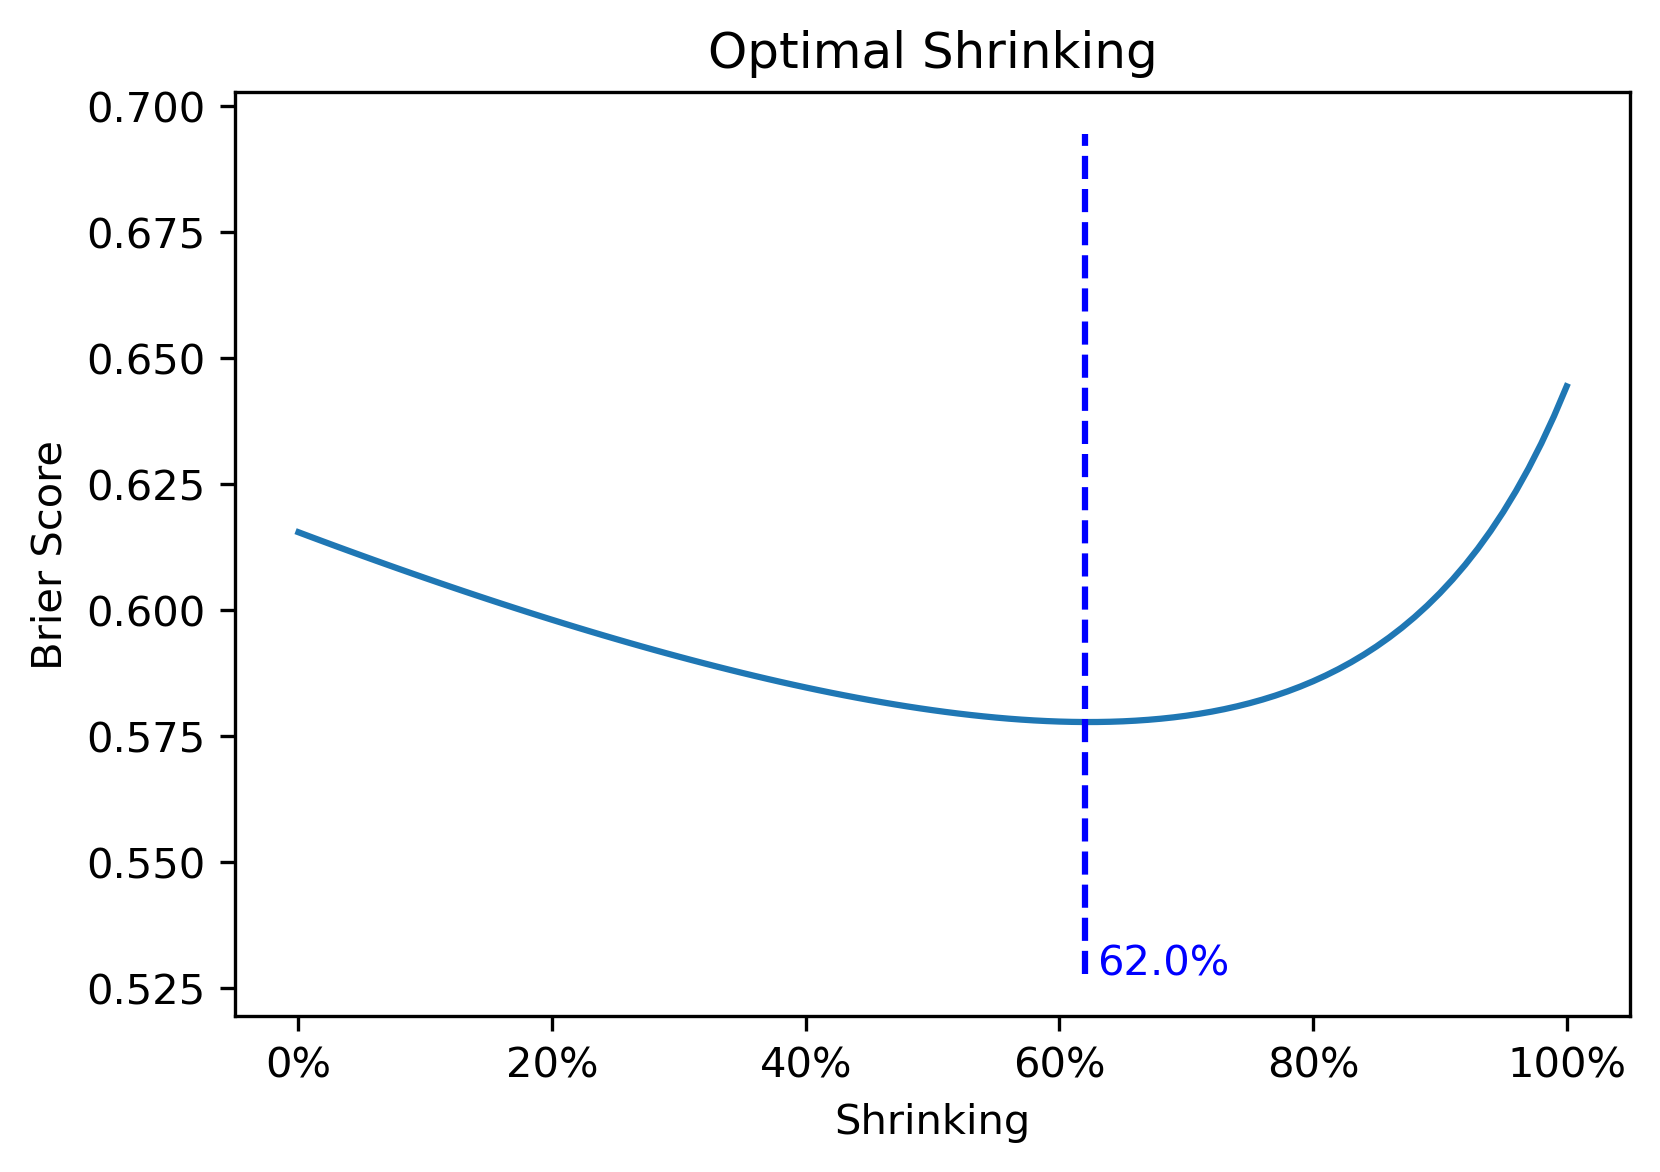

In [ ]:
# plot scaling
plt.figure(figsize=(6, 4))
plt.plot(Ss, brier_scores, label='Simulated Brier Score')
plt.xlabel('Shrinking')
plt.ylabel('Brier Score')
plt.vlines(optimal_s, min(brier_scores) - .05, max(brier_scores) + .05, linestyles='dashed', colors='blue', label='Optimal Scaling')
plt.annotate(f"{optimal_s:.1%}", (optimal_s + .01, min(brier_scores) - .05), fontsize=10, color='blue')
plt.title('Optimal Shrinking')
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.savefig('../figures/shrinking_brier_score.png')

In [ ]:
Ss = np.linspace(0, 1, 101)
brier_scores = []
for s in tqdm(Ss):
    sim_df = sim_df.apply(sim_depolarize, axis=1, scale=s).apply(sim_proportionate, axis=1)
    sim_df['brier_score'] = sim_df.apply(brier_score, type='simulated', axis=1)
    bs = sim_df['brier_score'].mean()
    brier_scores.append(bs)

100%|██████████| 101/101 [00:31<00:00,  3.25it/s]


In [ ]:
# calculate optimal s
optimal_s = Ss[np.argmin(brier_scores)]
print(f"Optimal s: {optimal_s:.3f}\nOptiaml Brier score: {min(brier_scores):.3f}")

Optimal s: 0.000
Optiaml Brier score: 0.589


# Miscellaneous

## Visualization of Usages

Visualize open-ended responses.

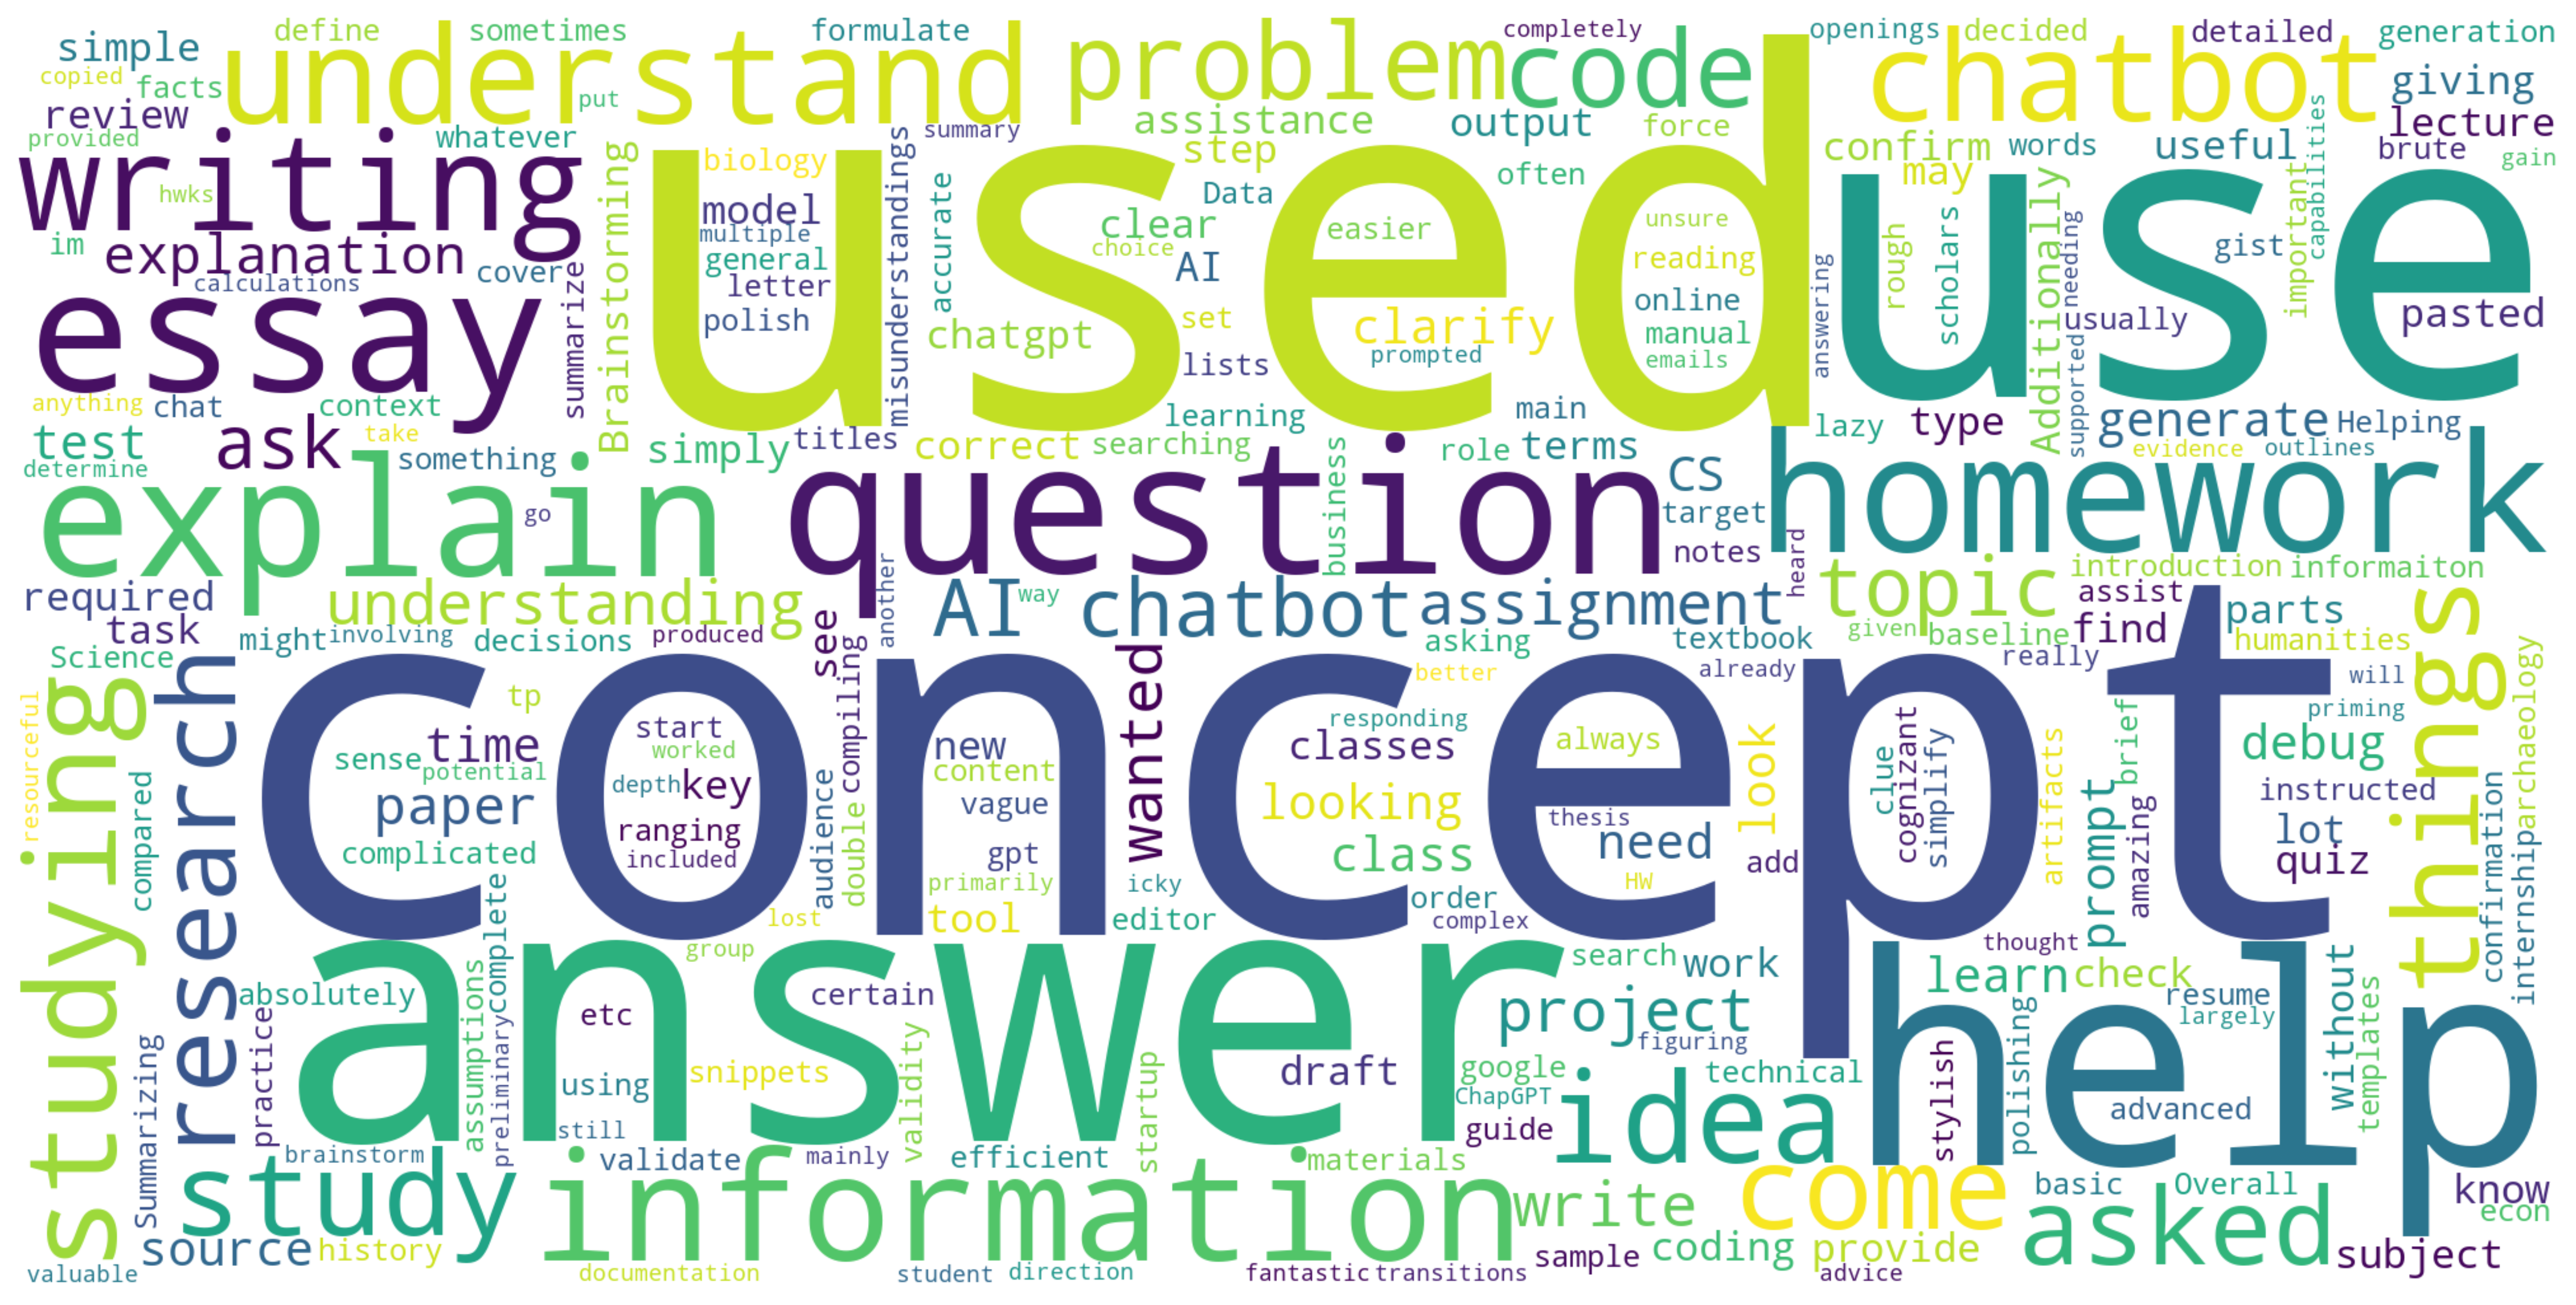

In [ ]:
usages = list(map(str, participant_df["usage_description"].dropna()))
# word cloud with bigrams
wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color="white",
                      max_words=300,
                      contour_width=3,
                      contour_color='steelblue',
                      collocations=True,
                      random_state=3)
wordcloud.generate(" ".join(usages))
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('../figures/usage_wordcloud.png')

## Power Analysis

For conclusion section.

In [ ]:
participant_df = question_df.groupby('participant_id').agg({
    'weight_on_advice':'mean',
    'advisor':'first',
    'give_justification':'first',
    })

In [ ]:
import statsmodels.stats.power as smp

power_analysis = smp.TTestIndPower()
effect_size = power_analysis.solve_power(nobs1=len(participant_df), power=0.8, alpha=0.05)
effect_size

0.3662403217295611

In [ ]:
# calculate cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
x = participant_df[participant_df['advisor'] == 'AI chatbot']['weight_on_advice']
y = participant_df[participant_df['advisor'] == 'expert']['weight_on_advice']
advisor_effect_size = cohen_d(x, y)
print(f"Advisor effect size: {advisor_effect_size:.3f}")
advisor_sample_size = power_analysis.solve_power(effect_size=advisor_effect_size, power=0.8, alpha=0.05)
print(f"Advisor sample size: {advisor_sample_size:.0f}")

Advisor effect size: 0.195
Advisor sample size: 412


In [ ]:
x = participant_df[participant_df['give_justification'] == "yes"]['weight_on_advice']
y = participant_df[participant_df['give_justification'] == "no"]['weight_on_advice']
justification_effect_size = cohen_d(x, y)
print(f"Justification effect size: {justification_effect_size:.3f}")
justification_sample_size = power_analysis.solve_power(effect_size=justification_effect_size, power=0.8, alpha=0.05)
print(f"Justification sample size: {justification_sample_size:.0f}")

Justification effect size: 0.190
Justification sample size: 436
